In [1]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

from PIL import Image

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join
from functools import reduce
from operator import mul

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model
from module_update_phycobilisomes import add_OCP

In [2]:
from functions_custom_steady_state_simulator import simulate_to_steady_state_custom, _find_steady_state, get_response_coefficients, get_response_coefficients_array, get_response_coefficients_df, calculate_ss_Q_red, get_steadystate_y0

In [3]:
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

In [4]:
# Set to True to recalculate the results of analyses that take a long time
# Set to False to use pre-calculated results
settings = {
    "general":{
        # Set to True to plot/ recalculate all figures (VERY TIME INTENSIVE!)
        # Set to False to plot/ recalculate no figure
        # Set to None to use figure specific settings (below)

        "plot_all": True, 
        "recalculate_all": False,

        # Use multiprocessing
        "multiprocessing": True,
        "max_workers": os.cpu_count() - 2,
    },
    # Figure specific settigs (overwritten by above settings)
    # Recalculation time with Intel Core i7, 16 cores, 64 GB memory
    "MCA":                          {"recalculate": False, "plot": True}, # Recalculation time: 30 min
    "CO2_fluxes_spectral":          {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "open_PS2s":                    {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "state_transitions_PAM":        {"recalculate": True, "plot": True}, # Recalculation time: 3 min
    "state_transitions_analysis":   {"recalculate": True, "plot": True}, # Recalculation time: 150 min
    "CO2_fluxes_monochrom":         {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "CO2_fluxes_monochrom_adapted": {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "sink_production_monochrom":    {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "PAM_blue_light":               {"recalculate": False, "plot": True}, # Recalculation time: 2 min
    "PAM_all_lights":               {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "electron_pathways":            {"recalculate": False, "plot": True}, # Recalculation time: 7 min
    "O2_CO2_fluxes":                {"recalculate": False, "plot": True}, # Recalculation time: 1 min
}

# Set the paths to save figures and objects
figure_path = Path("../Figures/bestMC_visualisation")
results_path = Path("../Results/bestNonValidationMC")

plot_format = ["svg", "png"]

# Reduce or increase the number of simulated points in appropriate analyses (1=default amount)
fraction_simulated_points = 0.3

In [5]:
# Apply general settings
for k,v in settings.items():
    if k!= "general":
        if settings["general"]["recalculate_all"] is not None:
            v["recalculate"] = settings["general"]["recalculate_all"]
        if settings["general"]["plot_all"] is not None:
            v["plot"] = settings["general"]["plot_all"]
        settings[k] = v

## Get new parameters

In [6]:
# run = "montecarlo_202405131529"  # Variation by factor 2
run = "montecarlo_202405141750"  # Variation by +- 10%

# SImulations with different state transition models
# run = "montecarlo_202406061819_mspill"  # Variation by +- 10%
# run = "montecarlo_202406061819_mpbsd"  # Variation by +- 10%

mcpar = pd.read_csv(Path("../Results")/ (run + "_params.csv"), index_col=0)
mcres = pd.read_csv(Path("../Results")/ (run + "_results.csv"), index_col=0)

# Exclude validation data from results
mcres = mcres.loc[:,[
    'LET_fraction',
    'LET_flux',
    # 'Schuurmans_O2',
    'Benschop_O2',
    "PAMSP435_Fm'",
    'PAMSP435_left',
    'PAMSP435_right',
    # 'PAMSPval_Fm'',
    # 'PAMSPval_left',
    # 'PAMSPval_right',
]]

# new_parameters = get_fitting_parameter_dict(fit.x, p_names)

# Summary
mcres_outcomes = pd.DataFrame(index=mcres.index, columns=["success", "failed", "timeout"])

mcres_outcomes["timeout"] = np.isnan(mcres).any(axis=1)
mcres_outcomes["failed"] = np.isinf(mcres).any(axis=1)
mcres_outcomes["success"] = mcres_succ = np.invert(np.logical_or(mcres_outcomes["timeout"], mcres_outcomes["failed"]))

print(f"""Full runs: {mcres_outcomes['success'].sum()}
Time-outs: {mcres_outcomes['timeout'].sum()}
Failed: {mcres_outcomes['failed'].sum()}"""
)

# Find simulations with improved objective functions
mcres_improved = mcres.copy()
mcres_improved = mcres_improved - mcres_improved.iloc[0,:]

# Find simulations with improvement in all objective functions
mcres_outcomes["total_better"] = (mcres_improved < 0).all(axis=1)

# Find simulations with improvement in all objective functions
mcres_outcomes["similar_pareto"] = (mcres_improved < 0.1).all(axis=1)

print(f"""
Better runs (all residuals lower): {mcres_outcomes['total_better'].sum()}
Similar runs (all residuals max + 10%): {mcres_outcomes['similar_pareto'].sum()}"""
)

# Get the best parameter set no including validation data
mcres_best = mcres.mean(axis=1)[mcres_outcomes["total_better"]].sort_values()
print(mcres_best.head())
best_idx = mcres_best.index[0]

# Set the new parameters
new_parameters = mcpar.loc[best_idx, :].to_dict()
new_parameters["fluo_influence"] = eval(new_parameters["fluo_influence"])

# MANUALLY ADAPTED THE PARAMETERS TO THE NEW PARAMETERS

Full runs: 9562
Time-outs: 439
Failed: 0

Better runs (all residuals lower): 510
Similar runs (all residuals max + 10%): 2565
2325    0.880288
7050    0.889605
2031    0.900530
7841    0.906819
3715    0.907582
dtype: float64


In [7]:
# Function for setting the default figure size
def figsize(rel_width, rel_height):
    default_width = 15 # inches

    return (rel_width * default_width, rel_height * default_width)

# Function for labelling figures with letters
def label_figure(fig, pos, label):
    if isinstance(pos, str):
        if pos == "top left":
            pos = (0,1.01)
        elif pos == "top right":
            pos = (0.98,1.01)
    
    if isinstance(pos, tuple):
        fig.text(*pos, label, size=30)

In [8]:
# Create the Main figure layouts
paper_figs = {}

plt.rcParams["figure.max_open_warning"] = 30

# Create figure 1
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.7))
gs = fig.add_gridspec(5)

sfig1 = fig.add_subfigure(gs[:3])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[3:])
label_figure(sfig2, pos="top left", label="B")
label_figure(sfig2, pos="top right", label="C")

paper_figs["fig1"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
    }
}


# Create figure 2
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 1.2))
gs = fig.add_gridspec(4,1)

sfig1 = fig.add_subfigure(gs[:1])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[1:3])
label_figure(sfig2, pos="top left", label="B")
sfig3 = fig.add_subfigure(gs[3])
label_figure(sfig3, pos="top left", label="C")

paper_figs["fig2"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
        "C": sfig3,
    }
}


# Create figure 3
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.6))
gs = fig.add_gridspec(3,3)

sfig1 = fig.add_subfigure(gs[:1, :])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[1:, :1])
label_figure(sfig2, pos="top left", label="B")
sfig3 = fig.add_subfigure(gs[1:, 1:])
label_figure(sfig3, pos="top right", label="C")

paper_figs["fig3"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
        "C": sfig3,
    }
}


# Create figure 4
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.6))
gs = fig.add_gridspec(2,3)

sfig1 = fig.add_subfigure(gs[:, 0])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[0, 1:])
label_figure(sfig2, pos="top left", label="B")
sfig3 = fig.add_subfigure(gs[1, 1])
label_figure(sfig3, pos="top left", label="C")
sfig4 = fig.add_subfigure(gs[1, 2])
label_figure(sfig4, pos="top right", label="D")

paper_figs["fig4"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
        "C": sfig3,
        "D": sfig4,
    }
}


# Create figure 5
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.7))
gs = fig.add_gridspec(5,3)

sfig1 = fig.add_subfigure(gs[0, :])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[1:3, :])
label_figure(sfig2, pos="top left", label="B")
sfig3 = fig.add_subfigure(gs[3:, :])
label_figure(sfig3, pos="top left", label="C")

paper_figs["fig5"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
        "C": sfig3,
    }
}


# Create figure S1
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.5))
gs = fig.add_gridspec(1, 2)

sfig1 = fig.add_subfigure(gs[0])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[1])
label_figure(sfig2, pos="top right", label="B")

paper_figs["figS1"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
    }
}


# Create figure S2
paper_figs["figS2"] = {"main": plt.figure(figsize=figsize(0.6, 0.5))}

# Create figure S3
paper_figs["figS3"] = {"main": plt.figure(figsize=figsize(1, 0.4))}

# Create figure S4
paper_figs["figS4"] = {"main": plt.figure(figsize=figsize(1, 0.5))}

# Create figure S5
paper_figs["figS5"] = {"main": plt.figure(figsize=figsize(0.6, 0.5))}

# Create figure S6
paper_figs["figS6"] = {"main": plt.figure(figsize=figsize(1, 0.4))}

# Create figure S7
paper_figs["figS7"] = {"main": plt.figure(figsize=figsize(1, 0.4))}

# Create figure S8
paper_figs["figS8"] = {"main": plt.figure(figsize=figsize(1, 0.8))}


# Create figure S9
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.5))
gs = fig.add_gridspec(1, 2)

sfig1 = fig.add_subfigure(gs[0])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[1])
label_figure(sfig2, pos="top right", label="B")


paper_figs["figS9"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
    }
}


# Create figure S10
paper_figs["figS10"] = {"main": plt.figure(figsize=figsize(1, 0.6))}

# Create figure S11
paper_figs["figS11"] = {"main": plt.figure(figsize=figsize(1, 0.6))}

# Create figure S12
paper_figs["figS12"] = {"main": plt.figure(figsize=figsize(1, 0.5))}

# Create figure S13
paper_figs["figS13"] = {"main":  plt.figure(figsize=figsize(1, 0.5))}

# Create figure S14
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 1))
gs = fig.add_gridspec(2,2)

sfig1 = fig.add_subfigure(gs[0,0])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[0, 1])
label_figure(sfig2, pos="top left", label="B")
sfig3 = fig.add_subfigure(gs[1, 0])
label_figure(sfig3, pos="top left", label="C")
sfig4 = fig.add_subfigure(gs[1, 1])
label_figure(sfig4, pos="top right", label="D")

paper_figs["figS14"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
        "C": sfig3,
        "D": sfig4,
    }
}

# Create figure S15
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.5))
gs = fig.add_gridspec(1, 2)

sfig1 = fig.add_subfigure(gs[0])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[1])
label_figure(sfig2, pos="top right", label="B")


paper_figs["figS15"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
    }
}

# Create figure S16
paper_figs["figS16"] = {"main": plt.figure(figsize=figsize(0.6, 0.5))}


<Figure size 1500x1050 with 0 Axes>

<Figure size 1500x1800 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x1050 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 900x750 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 900x750 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

<Figure size 900x750 with 0 Axes>

# Metabolic Control Analysis (MCA) (Figures 3a, 10, & 11)

In [9]:
m,y0 = get_model()

# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

# Set the parameters to be perturbed in MCA and the target reactions/metabolites 
mca_parameters = {
    'PSIItot' : "PS2",
    'PSItot' : "PS1", 
    'k_Q' : "Cb$_6$f",
    'k_FN_fwd' : "FNR$^{fwd}$",
    # 'k_FN_rev' : "FNR$^{rev}$",
    # 'k_pass' : "Proton Leak",
    'k_SDH' : "SDH",
    'k_NDH' : "NDH",
    "k_NQ" if "k_NQ" in m_MCA.parameters else "vNQ_max" : "NQ",
    'kRespiration' : "Resp",
    # 'kO2out' : "O$_2$ outflux",
    'kATPsynth': "ATP synthase",
    # 'kATPconsumption' : "ATP consumption",
    # 'kNADHconsumption' : "NADPH consumption",
    'vCBB_max' : "RuBisCO$^{carb}$",
    'vOxy_max' : "RuBisCO$^{oxy}$",
    # 'kPR': "PR",
    'k_O2' : "Flv",
    # 'kCBBactivation': "CBB activation",
    # 'kExch_3PGA' : "3PGA Exchange",
    # 'threshExch_3PGA': "3PGA Exchange threshold",
    'k_O2' : "Flv",
    'k_ox1' : "bd",
    'k_aa' : "aa",
}

mca_compounds = {
    'PSII' : "PS2",
    'Q_red': "Q$_{red}$",
    'Hi': "H$_i$",
    'Ho': "H$_o$",
    'PC_red' : "PC$_{red}$",
    'Fd_red' : "Fd$_{red}$",
    'NADPH' : "NADPH",
    'NADH': "NADH",
    'succinate': "Succinate",
    'fumarate' : "fumarate",
    'ATP' : "ATP",
    '3PGA': "3PGA",
    'PG' : "2PG",
    'CBBa': "CBB$_a$",
    'O2' : "O$_2$",
    'CO2' : "CO$_2$",
}
mca_reactions = {
    'vPS2' : "PS2",
    'vb6f' : "Cb$_6$f",
    'vPS1' : "PS1",
    'vFNR' : "FNR",
    'vCBB' : "CBB",
    'vOxy' : "Oxy",
    'vPR' : "PR",
    'vFlv' : "Flv",
    'vbd' : "bd",
    'vaa' : "aa",
    'vNQ' : "NQ",
    'vRespiration' : "Resp",
    'vSDH' : "SDH",
    'vNDH' : "NDH",
    'vATPsynthase' : "ATPsynthase",
    "vExch_3PGA" : "net 3PGA",
}

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False
updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten


## Results of metabolic control analysis under illumination with monochromatic Gaussian LEDs (Figure 11)

In [10]:
def spectrum(*args, **kwargs):
    return lip.light_spectra(*args,**kwargs)

def monochromatic(*args, **kwargs):
    return lip.light_gaussianLED(*args, spread=1e-3, **kwargs)

# Functions to calculate the response coefficients
def _calculate_coefficients(m, y0, parameters, lightfun, savepath, simulation_kwargs, rel_norm, integrator_kwargs, light_param):
        light = lightfun(*light_param)
        m = m.copy()
        m.update_parameter("pfd", light)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # _ccc, _fcc = mca.get_response_coefficients_df(
            _ccc, _fcc = get_response_coefficients_df(
                m,
                parameters,
                y=y0,
                displacement=0.01,
                tolerance=None,
                disable_tqdm=True, 
                multiprocessing=False,
                rel_norm=rel_norm,
                simulation_kwargs=simulation_kwargs,
                **integrator_kwargs,
            )
            _ccc.to_csv(savepath / f'ccc_{light_param[0]}_{light_param[1]}.csv')
            _fcc.to_csv(savepath / f'fcc_{light_param[0]}_{light_param[1]}.csv')

def calculate_coefficients(m, y0, parameters, light_params, lightfun, savepath=Path(results_path / "coefficients"), simulation_kwargs={"t_end":1e6, "tolerances":[[None, 1e-6]]},rel_norm=False, multiprocessing=False, max_workers=None, **integrator_kwargs):
    _calculate_coefficients_prt = partial(_calculate_coefficients, m, y0, parameters, lightfun, savepath, simulation_kwargs, rel_norm, integrator_kwargs)

    if sys.platform in ["win32", "cygwin"] or not multiprocessing:
        res = list(map(_calculate_coefficients_prt, light_params))
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as pe:
            res = pe.map(_calculate_coefficients_prt, light_params)

# Load the data
def load_coefficients(parameter, responder, type, lights, intensities, path=results_path / "coefficients"):
    res = pd.DataFrame(index=intensities, columns=lights, dtype=float)

    for light in lights:
        for intensity in intensities:
            try:
                res.loc[intensity, light] = pd.read_csv(f"{path}/{type}_{light}_{intensity}.csv", index_col=0).astype(float).loc[parameter, responder]
            except FileNotFoundError as e:
                print(e)
    return res

# Summarise coefficients into pathways
# def get_coefficientsum(DF, parameters, target, abs=False):
#     if abs: 
#         return DF.loc[parameters, target].abs().sum(skipna=False)
#     else:
#         return DF.loc[parameters, target].sum(skipna=False)

def get_coefficientmean(DF, parameters, target, abs=False):
    if abs: 
        return DF.loc[parameters, target].abs().mean(skipna=False)
    else:
        return DF.loc[parameters, target].mean(skipna=False)

def light_ETC (DF, reaction, abs):
    param =  ['PSIItot', 'k_Q', "k_NQ" if "k_NQ" in m_MCA.parameters else "vNQ_max", 'PSItot', "k_FN_fwd"] # 'kATPsynth'
    return get_coefficientmean(DF, param, reaction, abs)

def Cbb (DF, reaction, abs):
    param = ["vCBB_max"]
    return get_coefficientmean(DF, param, reaction, abs)

def alt_EF (DF, reaction, abs):
    param = ["k_O2", "k_ox1", "k_aa"] 
    return get_coefficientmean(DF, param, reaction, abs)

def _respiration_ (DF, reaction, abs):
    param = ["k_SDH", "kRespiration", "k_NDH"] 
    return get_coefficientmean(DF, param, reaction, abs)

def Photosystems (DF, reaction, abs):
    param = ['PSIItot', "PSItot"] 
    return get_coefficientmean(DF, param, reaction, abs)

def createDF_spectra (func, dictionary, r, type, lights, intensities, abs=False):
    solar = []
    fluorescent = []
    cool = []
    warm = []
    for l in lights: 
        if l == "solar":
            for i in intensities:
                solar.append(func(dictionary[f"{type}_{l}_{i}"], r, abs))
        if l == "fluorescent_lamp":
            for i in intensities:
                fluorescent.append(func(dictionary[f"{type}_{l}_{i}"], r, abs))
        if l == "cool_white_led":
            for i in intensities:
                cool.append(func(dictionary[f"{type}_{l}_{i}"], r, abs))
        if l == "warm_white_led":
            for i in intensities:
                warm.append(func(dictionary[f"{type}_{l}_{i}"], r, abs))

    d = {
        "solar": pd.Series(solar, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "fluorescent": pd.Series(fluorescent, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "cool white": pd.Series(cool, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "warm white": pd.Series(warm, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
    }

    df = pd.DataFrame(d)
    return df


def createDF_mono (func, dictionary, r, type, lights, intensities, abs=False):
    _405 = []
    _440 = []
    _480 = []
    _550 = []
    _590 = []
    _624 = []
    _674 = []
    for wl in lights:
        if wl == "405":
            for i in intensities:
                _405.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
        if wl == "440":
            for i in intensities:
                _440.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
        if wl == "480":
            for i in intensities:
                _480.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
        if wl == "550":
            for i in intensities:
                _550.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
        if wl == "590":
            for i in intensities:
                _590.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
        if wl == "624":
            for i in intensities:
                _624.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
        if wl == "674":
            for i in intensities:
                _674.append(func(dictionary[f"{type}_{wl}_{i}"], r, abs))
    
    d = {
        "405": pd.Series(_405, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "440": pd.Series(_440, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "480": pd.Series(_480, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "550": pd.Series(_550, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "590": pd.Series(_590, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "624": pd.Series(_624, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
        "674": pd.Series(_674, index=['80', '160', '240', '320', '400', '480', '560', '640', '720', '800']),
    }

    df = pd.DataFrame(d)
    return df

In [11]:
# Define the conditions checked in MCA
intensities = np.linspace(80, 800, 10)
wavelengths = [405, 440, 480, 550, 590, 624, 674]
lights = ["solar", "fluorescent_lamp", "cool_white_led", "warm_white_led"]

In [12]:
if settings["MCA"]["recalculate"]:
    # Calculate parameters for monochromatic lights
    light_params = np.meshgrid(wavelengths, intensities)
    light_params = list(zip(*[x.flatten() for x in light_params]))
    calculate_coefficients(
        m_MCA,
        y0,
        mca_parameters,
        light_params,
        monochromatic,
        multiprocessing=settings["general"]["multiprocessing"],
        max_workers=settings["general"]["max_workers"],
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True,
        **fnc.simulator_kwargs["loose"]
    )

    # Calculate parameters for common spectra
    light_params = np.meshgrid(lights, intensities)
    light_params = list(zip(*[x.flatten() for x in light_params]))
    calculate_coefficients(
        m_MCA,
        y0,
        mca_parameters,
        light_params,
        spectrum,
        multiprocessing=settings["general"]["multiprocessing"],
        max_workers=settings["general"]["max_workers"],
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True,
        **fnc.simulator_kwargs["loose"]
    )

In [13]:
intens = np.linspace(80, 800, 10)

# PLOT HEATMAPS
# Define the figure
if settings["MCA"]["plot"]:
    fig = paper_figs["figS10"]["main"]
    axes = fig.subplots(3, 3, sharex=True, sharey=True)

    single_coefficients = {
        "Concentration Control of PS1 over ATP": load_coefficients("PSItot", "ATP", "ccc", wavelengths, intensities),
        "Concentration Control of PS1 over NADPH": load_coefficients("PSItot", "NADPH", "ccc", wavelengths, intensities),
        "Concentration Control of PS1 over PG": load_coefficients("PSItot", "PG", "ccc", wavelengths, intensities),
        "Concentration Control of PS2 over ATP": load_coefficients("PSIItot", "ATP", "ccc", wavelengths, intensities),
        "Concentration Control of PS2 over NADPH": load_coefficients("PSIItot", "NADPH", "ccc", wavelengths, intensities),
        "Concentration Control of PS2 over PG": load_coefficients("PSIItot", "PG", "ccc", wavelengths, intensities),
        "Concentration Control of CBB over ATP": load_coefficients("vCBB_max", "ATP", "ccc", wavelengths, intensities),
        "Concentration Control of CBB over NADPH": load_coefficients("vCBB_max", "NADPH", "ccc", wavelengths, intensities),
        "Concentration Control of CBB over PG": load_coefficients("vCBB_max", "PG", "ccc", wavelengths, intensities),
    }

    totalmax = np.max([x.abs().max().max() for x in single_coefficients.values()])
    allNorm = TwoSlopeNorm(0, vmax=totalmax, vmin=-totalmax)

    for (title, df), ax in zip(single_coefficients.items(), axes.flatten("F")):
        fig, ax, qm = mca.plot_coefficient_heatmap(
            df.T,
            title=title,
            rows=reversed(intensities),
            annotate=False,
            ax=ax,
            norm=allNorm,
            colorbar=False
        )
        ax = fnc.add_na_annotation(ax, df, 6)
        ax.set_xticklabels(wavelengths, rotation=0, ha="center")

    axes[1,0].set_ylabel("Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    axes[-1,1].set_xlabel("Wavelength [nm]")

    fig.tight_layout()

    fig.subplots_adjust(right=0.95)
    cax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
    cb = fig.colorbar(qm, cax=cax)
    cb.outline.set_linewidth(0)
    cb.ax.tick_params(labelsize=14)


    # Save the plot
    # fnc.savefig_dated(fig, "FigureS1", type=plot_format, path=figure_path, bbox_inches="tight")

## Results of metabolic control analysis performed with different light sources (Figure 3)



In [14]:
# Comparison of Photosystems and RuBisCo
if settings["MCA"]["plot"]:
    intensities = np.linspace(80, 800, 10)
    wavelength = [405, 440, 480, 550, 590, 624, 674]
    light = ["solar", "fluorescent_lamp", "cool_white_led", "warm_white_led"]
    cres = {}
    fres = {}

    for wl in wavelength:
        for i in intensities:
            cres[f"ccc_{wl}_{i}"] =  pd.read_csv(results_path / fr'coefficients/ccc_{wl}_{i}.csv', index_col = [0])
            fres[f"fcc_{wl}_{i}"] = pd.read_csv(results_path / fr'coefficients/fcc_{wl}_{i}.csv', index_col = [0])
            
    for l in light:
        for i in intensities:
            cres[f"ccc_{l}_{i}"] =  pd.read_csv(results_path / fr'coefficients/ccc_{l}_{i}.csv', index_col = [0])
            fres[f"fcc_{l}_{i}"] = pd.read_csv(results_path / fr'coefficients/fcc_{l}_{i}.csv', index_col = [0])
        
    
    # list for label of x-axis of heatmap
    lights = {"solar": "Solar Light", "fluorescent_lamp": "Fluorescent Lamp", "cool_white_led": "Cool White LED", "warm_white_led": "Warm White LED"}
    i = {intensities[i]: str(int(intensities[i])) for i in np.arange(9,-1,-1)}

    # Calculate the pathway fluxes for CBB under compound lights
    r = "vCBB"
    abs = True

    photosys = createDF_spectra(Photosystems, fres, r, "fcc", lights, intensities, abs=abs)
    cbb = createDF_spectra(Cbb, fres,  r, "fcc", lights, intensities, abs=abs)

    a = {"Photosystems": photosys, "CBB": cbb,}

    # Define the figure
    fig = paper_figs["fig3"]["subs"]["C"]
    axes = fig.subplots(1, 2, sharey=True)
    axes = axes.flatten()

    # Plot the heatmaps

    totalmax = np.max([x.abs().max().max() for x in a.values()])
    if not abs:
        allNorm = TwoSlopeNorm(0, vmax=totalmax, vmin=-totalmax)
        cmap = 'RdBu_r'
    else:
        allNorm = Normalize(0, totalmax)
        cmap = "Reds"

    fig, ax, qm = mca.plot_coefficient_heatmap(
        photosys.T,
        title="Photosystems (Source)",
        rows=i.values(),
        annotate=False,
        ax=axes[0],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )

    fig, ax, qm = mca.plot_coefficient_heatmap(
        cbb.T,
        title="Calvin Benson Basshan cycle (Sink)",
        rows=i.values(),
        annotate=False,
        ax=axes[1],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )

    #Replace the tick labels
    axes[0].set_xticklabels(lights.values(), rotation=30, ha="right", rotation_mode='anchor', size=14)
    axes[0].set_yticklabels(i.values(), size=14)
    axes[0].set_ylabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", size=14)
    axes[0].set_title(axes[0].get_title(), size = 15)
    axes[1].set_xticklabels(lights.values(), rotation=30, ha="right", rotation_mode='anchor', size=14)
    axes[1].set_title(axes[1].get_title(), size = 15)

    # #Add letters to the axes
    # for i,ax in enumerate(axes.flatten()):
    #     if i%2 == 0: # Set if the number should be left or right
    #         xpos = ax.get_xlim()[0] - np.sum(ax.get_xlim()*np.array([-1,1])) * 0.1
    #     else:
    #         xpos = ax.get_xlim()[1] + np.sum(ax.get_xlim()*np.array([-1,1])) * 0.1
    #     ypos = ax.get_ylim()[1] + np.sum(ax.get_ylim()*np.array([-1,1])) * 0.05
    #     ax.text(xpos, ypos, chr(65+i), size=30)

    fig.subplots_adjust(right=0.95)
    cax = fig.add_axes([0.97, 0.15, 0.015, 0.77])
    cb = fig.colorbar(qm, cax=cax)
    cb.outline.set_linewidth(0)
    cb.set_label("Mean absolute flux control coefficent", size=14)

    fig.subplots_adjust(wspace=0.07)

    fig.suptitle("Mean control over the steady-state CBB flux", fontsize=20, y=1.04)

In [15]:
# Comparison of electron pathways
if settings["MCA"]["plot"]:
    intensities = np.linspace(80, 800, 10)
    wavelength = [405, 440, 480, 550, 590, 624, 674]
    light = ["solar", "fluorescent_lamp", "cool_white_led", "warm_white_led"]
    cres = {}
    fres = {}

    for wl in wavelength:
        for i in intensities:
            cres[f"ccc_{wl}_{i}"] =  pd.read_csv(results_path / fr'coefficients/ccc_{wl}_{i}.csv', index_col = [0])
            fres[f"fcc_{wl}_{i}"] = pd.read_csv(results_path / fr'coefficients/fcc_{wl}_{i}.csv', index_col = [0])
            
    for l in light:
        for i in intensities:
            cres[f"ccc_{l}_{i}"] =  pd.read_csv(results_path / fr'coefficients/ccc_{l}_{i}.csv', index_col = [0])
            fres[f"fcc_{l}_{i}"] = pd.read_csv(results_path / fr'coefficients/fcc_{l}_{i}.csv', index_col = [0])
        
    
    # list for label of x-axis of heatmap
    lights = {"solar": "Solar Light", "fluorescent_lamp": "Fluorescent Lamp", "cool_white_led": "Cool White LED", "warm_white_led": "Warm White LED"}
    i = {intensities[i]: str(int(intensities[i])) for i in np.arange(9,-1,-1)}

    # Calculate the pathway fluxes for CBB under compound lights
    r = "vCBB"
    abs = True

    lightETC = createDF_spectra(light_ETC, fres, r, "fcc", lights, intensities, abs=abs)
    altEF = createDF_spectra(alt_EF, fres, r, "fcc", lights, intensities, abs=abs)
    respi = createDF_spectra(_respiration_, fres,  r, "fcc", lights, intensities, abs=abs)

    a = {"PETC": lightETC, "AEF": altEF, "Respiration": respi}

    # Define the figure
    fig = paper_figs["figS12"]["main"]
    axes = fig.subplots(1,3, sharey=True)
    axes = axes.flatten()

    # Plot the heatmaps

    totalmax = np.max([x.abs().max().max() for x in a.values()])
    if not abs:
        allNorm = TwoSlopeNorm(0, vmax=totalmax, vmin=-totalmax)
        cmap = 'RdBu_r'
    else:
        allNorm = Normalize(0, totalmax)
        cmap = "Reds"

    fig, ax, qm = mca.plot_coefficient_heatmap(
        lightETC.T,
        title="Light driven electron flow",
        rows=i.values(),
        annotate=False,
        ax=axes[0],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )
    ax = fnc.add_na_annotation(ax, lightETC, 6)

    fig, ax, qm = mca.plot_coefficient_heatmap(
        altEF.T,
        title="Alternate electron flow",
        rows=i.values(),
        annotate=False,
        ax=axes[1],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )
    ax = fnc.add_na_annotation(ax, altEF, 6)

    fig, ax, qm = mca.plot_coefficient_heatmap(
        respi.T,
        title="Respiration",
        rows=i.values(),
        annotate=False,
        ax=axes[2],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )
    ax = fnc.add_na_annotation(ax, respi, 6)

    #Replace the tick labels
    axes[0].set_xticklabels(lights.values(), rotation=30, ha="right", rotation_mode='anchor', size=14)
    axes[0].set_title(axes[0].get_title(), size = 15)
    axes[1].set_xticklabels(lights.values(), rotation=30, ha="right", rotation_mode='anchor', size=14)
    axes[1].set_title(axes[1].get_title(), size = 15)
    axes[2].set_xticklabels(lights.values(), rotation=30, ha="right", rotation_mode='anchor', size=14)
    axes[2].set_title(axes[2].get_title(), size = 15)

    fig.subplots_adjust(right=0.95)
    cax = fig.add_axes([0.97, 0.15, 0.015, 0.7])
    cb = fig.colorbar(qm, cax=cax)
    cb.outline.set_linewidth(0)
    cb.set_label("Mean absolute flux control coefficent", size=14)

    # #Add letters to the axes
    # for i,ax in enumerate(axes.flatten()):
    #     if i%2 == 0: # Set if the number should be left or right
    #         xpos = ax.get_xlim()[0] - np.sum(ax.get_xlim()*np.array([-1,1])) * 0.1
    #     else:
    #         xpos = ax.get_xlim()[1] + np.sum(ax.get_xlim()*np.array([-1,1])) * 0.1
    #     ypos = ax.get_ylim()[1] + np.sum(ax.get_ylim()*np.array([-1,1])) * 0.05
    #     ax.text(xpos, ypos, chr(65+i), size=30)

    # Wrap up the plot
    fig.suptitle("Mean control over the steady-state CBB flux", fontsize=20, y=1)
    fig.subplots_adjust(wspace=0.07)


    # Save the figure
    fnc.savefig_dated(fig, "FigureS2_FC", type=plot_format, path=figure_path, bbox_inches="tight")

## Results of metabolic control analysis performed with monochromatic lights (Figure 10)


In [16]:
if settings["MCA"]["plot"]:
    i = {intensities[i]: str(int(intensities[i])) for i in np.arange(9,-1,-1)}
    mono_lights = {"405": "405", "440": "440", "480": "480", "550": "550", "590": "590", "624": "624", "674": "674"}
    
    # # Calculate the pathway fluxes for CBB under compound lights    
    # r = "vCBB"
    # abs=True
    # m_lightETC = createDF_mono(light_ETC, fres, r, "fcc", mono_lights, intensities, abs)
    # m_cbb = createDF_mono(Cbb, fres, r, "fcc", mono_lights, intensities, abs)
    # m_altEF = createDF_mono(alt_EF, fres, r, "fcc", mono_lights, intensities, abs)
    # m_respi = createDF_mono(_respiration_, fres,  r, "fcc", mono_lights, intensities, abs)

    # Calculate the pathway fluxes for CBB under compound lights
    r = "vCBB"
    abs = True

    photosys = createDF_mono(Photosystems, fres, r, "fcc", mono_lights, intensities, abs=abs)
    cbb = createDF_mono(Cbb, fres,  r, "fcc", mono_lights, intensities, abs=abs)

    a = {"Photosystems": photosys, "CBB": cbb,}

    # Define the figure
    fig = paper_figs["figS11"]["main"]
    axes = fig.subplots(1, 2, sharey=True)
    axes = axes.flatten()

    # Plot the heatmaps

    totalmax = np.max([x.abs().max().max() for x in a.values()])
    if not abs:
        allNorm = TwoSlopeNorm(0, vmax=totalmax, vmin=-totalmax)
        cmap = 'RdBu_r'
    else:
        allNorm = Normalize(0, totalmax)
        cmap = "Reds"

    fig, ax, qm = mca.plot_coefficient_heatmap(
        photosys.T,
        title="Photosystems (Source)",
        rows=i.values(),
        annotate=False,
        ax=axes[0],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )

    fig, ax, qm = mca.plot_coefficient_heatmap(
        cbb.T,
        title="Calvin Benson Basshan cycle (Sink)",
        rows=i.values(),
        annotate=False,
        ax=axes[1],
        norm=allNorm,
        cmap=cmap,
        colorbar=False
    )
    
    fig.tight_layout()

    #Replace the tick labels
    axes[0].set_xticklabels(mono_lights.values(), rotation=0, ha="center", rotation_mode='anchor', size=14)
    axes[0].set_yticklabels(i.values(), size=14)
    axes[0].set_ylabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", size=14)
    axes[0].set_title(axes[0].get_title(), size = 15)
    axes[1].set_xticklabels(mono_lights.values(), rotation=0, ha="center", rotation_mode='anchor', size=14)
    axes[1].set_title(axes[1].get_title(), size = 15)

    # #Add letters to the axes
    # for i,ax in enumerate(axes.flatten()):
    #     if i%2 == 0: # Set if the number should be left or right
    #         xpos = ax.get_xlim()[0] - np.sum(ax.get_xlim()*np.array([-1,1])) * 0.1
    #     else:
    #         xpos = ax.get_xlim()[1] + np.sum(ax.get_xlim()*np.array([-1,1])) * 0.1
    #     ypos = ax.get_ylim()[1] + np.sum(ax.get_ylim()*np.array([-1,1])) * 0.05
    #     ax.text(xpos, ypos, chr(65+i), size=30)

    fig.subplots_adjust(right=0.95)
    cax = fig.add_axes([0.97, 0.15, 0.015, 0.77])
    cb = fig.colorbar(qm, cax=cax)
    cb.outline.set_linewidth(0)
    cb.set_label("Mean absolute flux control coefficent", size=14)

    fig.subplots_adjust(wspace=0.07)

    fig.suptitle("Mean control over the steady-state CBB flux", fontsize=20, y=1.04)
    fig.text(x=0.5, y=0, s="Wavelength [nm]", ha="center", va="center", fontsize=14)

    # Save the figure
    fnc.savefig_dated(fig, "Monochrom_Figure6_FC", type=plot_format, path=figure_path, bbox_inches="tight")
    

    
    # Plot the spectrum
    fig = paper_figs["fig5"]["subs"]["A"]
    ax = fig.subplots()

    names = {
        "chla": "Chlorophyll a",
        "beta_carotene": "Beta carotene",
        "allophycocyanin": "Allophycocyanin",
        "phycocyanin": "Phycocyanin"
    }

    for (i, dat), ls in zip(lip.absorption_Fuente.T.iterrows(), ["-", "--", "-.", ":"]):
        ax.plot(dat, c="k", ls=ls, label=names[dat.name[0]])

    ax2 = ax.twinx()
    for wl in wavelengths:
        light = lip.light_gaussianLED(wl,1,1)
        ax2.plot(light.loc[wl-1:wl+1], c=fnc.wavelength_to_rgb(wl))

    ax2.set_yticks([])
    ax2.set_yticks([])
    ax.set_ylabel("Absorption [rel.]")
    ax.set_xlabel("Wavelength [nm]")

    ax.legend(loc="upper right")

    # Save the figure
    # fnc.savefig_dated(fig, "spectra_monochrom", type=plot_format, path=figure_path, bbox_inches="tight")

# Carbon Dioxide Fluxes under Different Light Sources (Figure 3b)

In [17]:
def get_ssflux(m, y0, lightfun, target, light_params, tolerance=1e-4, rel_norm=False):
    light = lightfun(*light_params)
    s = Simulator(m.copy())
    s.update_parameter("pfd", light)
    s.initialise(y0)
    # t,y = s.simulate_to_steady_state(tolerance=tolerance, rel_norm=rel_norm, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        return float(s.get_fluxes_dict()[target])

def get_ssfluxes(m, y0, lightfun, target, lightparam1, lightparam2, multiprocessing=True, max_workers=None):
    light_params = np.meshgrid(lightparam1, lightparam2)
    _light_params = zip(*[x.flatten() for x in light_params])

    _get_ssflux = partial(get_ssflux, m, y0, lightfun, target)

    if sys.platform in ["win32", "cygwin"] or not multiprocessing:
        res = np.array(list(map(_get_ssflux, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as pe:
            res = np.array(list(pe.map(_get_ssflux, _light_params)), dtype=float)

    res = res.reshape(-1,len(lightparam1))
    return pd.DataFrame(res, index=lightparam2, columns=lightparam1)

In [18]:
lights = {"solar": "Solar Light", "fluorescent_lamp": "Fluorescent Lamp", "cool_white_led": "Cool White LED", "warm_white_led": "Warm White LED"}
intens = np.linspace(20, 500, int(50 * fraction_simulated_points))
if settings["CO2_fluxes_spectral"]["recalculate"]:
    CO2s = get_ssfluxes(
        m_MCA, 
        y0, 
        lip.light_spectra, 
        "vCCM", 
        list(lights.keys()), 
        intens,
        multiprocessing = settings["general"]["multiprocessing"],
        max_workers = settings["general"]["max_workers"],
    )

    fnc.save_obj_dated(CO2s, "spectra_ss_CO2s", results_path)

In [19]:
if settings["CO2_fluxes_spectral"]["plot"]:
    CO2s = fnc.load_obj_dated("spectra_ss_CO2s", results_path)

    labels = lights.values()
    colors = ["gold", "brown", "cornflowerblue", "darkorange"]

    fig = paper_figs["fig3"]["subs"]["B"]
    ax = fig.subplots()
    ax.set_prop_cycle('color',colors)
    ax.plot(CO2s * prm.unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', "s-1 -> min-1"]), label = labels)
    ax.set_ylabel('Flux [mmol g(Chl)$^{-1}$ min$^{-1}$]')
    ax.set_xlabel('Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]')
    ax.set_title("CO$_2$ consumption under common light spectra")
    ax.legend(loc="center right", fontsize=10)
    ax.set_ylim(ymin=0)
    # fig.tight_layout()
    # fnc.savefig_dated(fig, "CO2underspectrallight", type=plot_format, path=figure_path)

In [20]:
# Spectra of the polychromatic light sources
light_sources = {
    "Solar": "solar",
    # "Incandescent bulb": "incandescent_bulb",
    "Fluorescent lamp": "fluorescent_lamp",
    # "Halogen lamp": "halogen_lamp",
    "Cool white LED": "cool_white_led",
    "Warm white LED": "warm_white_led",
}
lights = {k:lip.light_spectra(v,1)for k,v in light_sources.items()}
# lights["Gaussian LED"] = lip.light_gaussianLED(560,1)

lights = {k:v/v.max() for k,v in lights.items()}

fig = paper_figs["fig3"]["subs"]["A"]
axes = fig.subplots(1, len(lights), sharey=True)
spectralmap = fnc.make_spectralmap()

for (nam,light), ax in zip(lights.items(), axes.flatten()):
    ax.imshow(
        np.arange(400, 701, 1).reshape(1, -1),
        cmap=spectralmap,
        extent=(400,700,0,1),
        aspect="auto",
        alpha=0.5
    )
    ax.fill_between(light.index.to_numpy(),light,1.05, color="w")
    ax.plot(light,c="k")
    ax.set_title(nam)#, weight='bold')

    ax.set_ylim(0,1.05)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.d'))

    if nam == "Gaussian LED":
        ax.text(x=0.05, y=0.95, s="Peak:\n560 nm", transform=ax.transAxes, ha="left", va="top",weight='normal')

axes[0].set_ylabel("Light intensity [rel.]")#, weight='bold')
fig.text(0.5,0,"Light wavelength [nm]", ha="center",va="center")# ,weight='bold')

Text(0.5, 0, 'Light wavelength [nm]')

# Open Photosystems Ratio (Figure 7)
Comparison to Miller *et al.* (2021)

In [21]:
if settings["open_PS2s"]["recalculate"]:
    lights = np.append(0, np.linspace(100, 700, 30))
    sims = {}
    openPSII = pd.Series(index=lights, dtype=float)
    for i, j in enumerate(lights):
        m,y0 = get_model(check_consistency=False, verbose=False)
        m = fnc.add_exchange(m)
        s = Simulator(m)
        s.initialise(y0)
        s.update_parameter("pfd", lip.light_spectra("fluorescent_lamp", j))
        # t,y = s.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
        s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
        sims[i] = s

        if t is not None:
            openPSII.iloc[i] = s.get_full_results_df().loc[:,["B0", "B1"]].sum(axis=1, skipna=False) / m.get_parameter("PSIItot")
    
    fnc.save_obj_dated(openPSII, "openps2s", results_path)

In [22]:
if settings["open_PS2s"]["plot"]:
    openPSII = fnc.load_obj_dated("openps2s", results_path)

    fig = paper_figs["figS5"]["main"]
    ax = fig.subplots()
    ax.plot(openPSII)
    ax.set_ylim(ymin=0)
    ax.set_xlabel("Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.set_ylabel("Fraction of open PSII reaction centers [rel.]")
    ax.set_title("Open PS2 RCs under increasing light intensities")
    fnc.savefig_dated(fig, "openps2s", type=plot_format, path=figure_path)

# Test State Transition Models (Figures 4b, 4c, & 12)

## State Transition Models PAM (Figure 4b)

In [23]:
m, y0 = get_model()

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


In [24]:
def create_protocol_ssanalysis(dark_adj, low_blue_adj, high_blue_adj, orange_adj, pulse_orange_adj, pulse_blue_adj):
    protocol_NPQ = fnc.create_protocol_PAM(
        init=0,
        actinic=(dark_adj, 20-0.3), # Actinic light intensity and duration
        saturating=(pulse_orange_adj, 0.3), # Saturating pulse light intensity and duration
        cycles=2,
        first_actinic_time=20,
        final_actinic_time=18
    )

    # Create the low blue light phase with 6 pulses
    protocol_NPQ = fnc.create_protocol_PAM(
        init=protocol_NPQ,
        actinic=(low_blue_adj, 20-0.3), # Actinic light intensity and duration
        saturating=(pulse_blue_adj, 0.3), # Saturating pulse light intensity and duration
        cycles=3,
        first_actinic_time=2,
        final_actinic_time=18
    )

    # Create the orange light phase with 9 pulses
    protocol_NPQ = fnc.create_protocol_PAM(
        init=protocol_NPQ,
        actinic=(orange_adj, 20-0.3), # Actinic light intensity and duration
        saturating=(pulse_orange_adj, 0.3), # Saturating pulse light intensity and duration
        cycles=15,
        first_actinic_time=2,
        final_actinic_time=18
    )

    # Create the low blue light phase with 9 pulses
    protocol_NPQ = fnc.create_protocol_PAM(
        init=protocol_NPQ,
        actinic=(low_blue_adj, 20-0.3), # Actinic light intensity and duration
        saturating=(pulse_blue_adj, 0.3), # Saturating pulse light intensity and duration
        cycles=15,
        first_actinic_time=2,
        final_actinic_time=18
    )
    return protocol_NPQ

In [25]:

# Alter models with the tested state transition mechanisms
def remove_statetransitions_default(m, y0):
    m.remove_reactions(["vPSIIunquench", "vPSIIquench"])

    # Adapt y0
    y0["PSII"] = m.get_parameter("PSIItot")
    return m, y0


# PBS detachment model
def vPBS_detach(Q_ox, PBS_free, Q_red, kPBS_detach, kPBS_attach, PBS_freemax):
    return rf.reversible_mass_action_2_2((PBS_freemax-PBS_free), Q_ox, PBS_free, Q_red, kPBS_detach, kPBS_attach)

def update_statetransitions_detachpbs1(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_detach":1e-3,
        "kPBS_attach":1e-3,
        "PBS_freemax":0.5
    })

    m.add_reaction_from_args(
        rate_name="vPBS_detach",
        function=vPBS_detach,
        stoichiometry={"PBS_PS1": -1, "PBS_PS2":-1},
        args=["Q_ox", "PBS_free", "Q_red", "kPBS_detach", "kPBS_attach", "PBS_freemax"],
    )

    return m, y0

# PBS mobile model
def vPBS_mobile(Q_ox, PBS_PS1, Q_red, PBS_PS2, kPBS_toPS1, kPBS_toPS2, PBS_PS1min, PBS_PS2min):
    return rf.reversible_mass_action_2_2(
        (PBS_PS2 - PBS_PS2min), Q_red, 
        (PBS_PS1 - PBS_PS1min), Q_ox, 
        kPBS_toPS1, kPBS_toPS2
    )

def update_statetransitions_mobilepbs(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_toPS1":1e-3,
        "kPBS_toPS2":1e-3,
        "PBS_PS1min": 0.35, 
        "PBS_PS2min": 0.45,
    })

    m.add_reaction_from_args(
        rate_name="vPBS_mobile",
        function=vPBS_mobile,
        stoichiometry={"PBS_PS1": 1, "PBS_PS2":-1},
        args=["Q_ox", "PBS_PS1", "Q_red", "PBS_PS2", "kPBS_toPS1", "kPBS_toPS2", "PBS_PS1min", "PBS_PS2min"],
    )

    return m, y0

# Spillover model
def vspillover(spill, Q_red, Q_ox, kspill, kunspill, spillmax):
    return rf.reversible_mass_action_2_2(spillmax-spill, Q_red, spill, Q_ox, kspill, kunspill)

def ps_normabsorption_spill(time, PBS_PS1, PBS_PS2, spill, complex_abs, PSItot, PSIItot, lcf):
    light_ps1 = (complex_abs["ps1"] + complex_abs["pbs"] * PBS_PS1) / PSItot
    light_ps2 = (complex_abs["ps2"] + complex_abs["pbs"] * PBS_PS2) / PSIItot

    if isinstance(light_ps2, float) and isinstance(time, np.ndarray):
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return (light_ps1 + spill * light_ps2) * lcf, ((1-spill) * light_ps2) * lcf

def update_statetransitions_spillover(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Add new parameters and functions
    m.add_compound("spill")
    y0["spill"] = 0

    m.add_parameters({
        "kspill": 1e-5,
        "kunspill" :1e-5,
        "spillmax": 0.1  
    })

    m.add_reaction_from_args(
        rate_name="vspillover",
        function=vspillover,
        stoichiometry={"spill": 1},
        args=["spill", "Q_red", "Q_ox", "kspill", "kunspill", "spillmax"],
    )

    m.update_algebraic_module(
        module_name="ps_normabsorption",
        function=ps_normabsorption_spill,
        args=["time", "PBS_PS1", "PBS_PS2", "spill", "complex_abs", "PSItot", "PSIItot", "lcf"],
        check_consistency=False,
    )

    m.update_algebraic_module(  # >> changed: added <<
        module_name="ps_normabsorption_ML",
        function=ps_normabsorption_spill,
        args=[
            "time",
            "PBS_PS1",
            "PBS_PS2",
            "spill",
            "complex_abs_ML",
            "PSItot",
            "PSIItot",
            "lcf"
        ],
        check_consistency=False,
    )

    return m, y0

In [26]:
def calculate_ss_outputs(m, y0, light, p={}):
    # Outputs: Steady-state PQ reduction state, ATP synthase rate, CBB rate, and change in fluorescence
    m = m.copy()
    m = fnc.add_exchange(m)
    s = Simulator(m)
    s.initialise(y0)

    s.update_parameters(p)
    s.update_parameter("pfd", light)

    # t,y = s.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        qred = float(s.get_full_results_df()["Q_red"])
        
        # Also output the ATP synthase rate and the CO2 fixation
        atps, cbb = s.get_fluxes_df()[["vATPsynthase", "vCBB"]].iloc[0]

        # Calculate the Fm
        s.update_parameter("pfd", lip.light_gaussianLED(625,15000))
        t,y = s.simulate(t+0.3)

        if t is None:
            return (qred, atps, cbb, np.nan)
        else:
            return (qred, atps, cbb, float(s.get_full_results_df().iloc[-1,:].loc["Fluo"]))

def _get_parameter_variations(p_bounds, n):
    params = {k:np.linspace(*p, n) for k,p in p_bounds.items()}

    params_mesh = np.meshgrid(*params.values())
    _params_mesh = list(zip(*[x.flatten() for x in params_mesh]))
    _params_mesh = [{k:v for k,v in zip(params, x)} for x in _params_mesh]
    return _params_mesh

def _get_parametervariant_outputs(s, p_bounds, n, light, multiprocessing, max_workers):
    # Create a combination of the parameter values
    _params_mesh = _get_parameter_variations(p_bounds, n)

    # Return the steady-state Q_red value with each parameter combination
    y0 = s.get_results_df().iloc[0,:].to_dict()
    _calculate_ss_outputs = partial(calculate_ss_outputs, s.model, y0, light)

    if sys.platform in ["win32", "cygwin"] or not multiprocessing:
        res = np.array(list(map(_calculate_ss_outputs, _params_mesh)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as pe:
            res = np.array(list(pe.map(_calculate_ss_outputs, _params_mesh)), dtype=float)
    return res

def get_parametervariant_outputs(models, sims, n, multiprocessing, max_workers, orange_light_intensity=200):
    Q_reds = {}
    vATPs = {}
    vCBBs = {}
    Fm_res = {}
    for nam, model in models.items():
        s = sims[nam]

        if nam == "mnost":
            Q_reds[nam], vATPs[nam], vCBBs[nam], _ = calculate_ss_outputs(s.model, s.get_results_df().iloc[0,:].to_dict(), make_lights(orangeInt=orange_light_intensity)[3])
        else:
            res_orn = _get_parametervariant_outputs(s, model["param_bounds"], n, make_lights(orangeInt=orange_light_intensity)[3], multiprocessing, max_workers)
            Q_reds[nam], vATPs[nam], vCBBs[nam], Fm_orn = [x.flatten() for x in np.split(res_orn,4, axis=1)]
            res_blue = _get_parametervariant_outputs(s, model["param_bounds"], n, make_lights(orangeInt=orange_light_intensity)[1], multiprocessing, max_workers)
            Fm_blue = res_blue[:,-1]
            Fm_res[nam] = (Fm_blue - Fm_orn) / Fm_blue
    return Q_reds, vATPs, vCBBs, Fm_res

# Recalculate a run simulation with altered parameters
# Intended only for recalculating fluorescence under different measuring light
def recalculate_with_altered_parameters(sim, parameters, recalc_fluxes=False, recalc_full_results=False):
    s = sim.copy()
    s.full_results = None

    for i in range(len(s.simulation_parameters)):
        new_param = s.simulation_parameters[i].copy()
        new_param.update(parameters)
        s.simulation_parameters[i] = new_param
    
    if recalc_fluxes:
        s.fluxes = None
        s._calculate_fluxes()
    
    if recalc_full_results:
        s.full_results = None
        s._calculate_full_results()

    return s

# Calculate the relative difference in fluorescence with altered measuring light
def relative_fluo_diff(sims, sims_blueML):
    res = {}
    for nam in sims:
        # Get the relative fluorescences and calculate the RMSE
        fluo = sims[nam].get_full_results_df()["Fluo"]
        fluo_blueML = sims_blueML[nam].get_full_results_df()["Fluo"]

        fluo_diff = (fluo/fluo.max()) - (fluo_blueML/fluo_blueML.max())
        rmse = np.sqrt(np.mean(fluo_diff**2))
        res[nam] = rmse
    return res

# Simulate a PAM experiment for the state transitions models
def dummy(m,y0):
    return m, y0

def simulate_statetransition_models(models, loadsim = False, savesim=False, orange_light_intensity=200):
    sims = {}
    for nam, model in models.items():
        if not loadsim:
            m,y0 = get_model(check_consistency=False, verbose=False, pbs_behaviour=model["pbs_behaviour"])
            m,y0 = model["fun"](m, y0)

            m.update_parameters(model["param"])
            y0 = get_steadystate_y0(m, y0)

            # Initialise the model
            s=Simulator(m)
            s.initialise(y0)

            # Simulate the appropriate protocol
            protocol = create_protocol_NPQ_short(*make_lights(orangeInt=orange_light_intensity))

            s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)
            if savesim:
                fnc.save_Simulator_dated(s, f"pamsim_{nam}", results_path)
        else:
            s = fnc.load_Simulator_dated(f"pamsim_{nam}", results_path)

        sims[nam] = s
    return sims


In [27]:
# Plotting functions
def add_phasebox(ax, t_start, t_end, text, height, ylow=1, adj_plotheight=False, fontsize=7):
    box = Rectangle(
        [t_start, ylow],
        t_end-t_start,
        height,
        fill=False,
        ec="k",
    )
    ax.add_patch(box)
    ax.text(
        t_start + 0.5*(t_end-t_start),
        ylow+0.5*height,
        text,
        ha="center",
        va="center",
        fontsize=fontsize
    )
    if adj_plotheight:
        ax.set_ylim(ymax=ax.get_ylim()[1]+height)
    return ax

def add_insetbox(ax, xmin, xmax, ymin, ymax, adj_plotheight=None):
    height = ymax-ymin
    box = Rectangle(
        [xmin, ymin],
        xmax-xmin,
        height,
        fill = False,
        fc="w",
        ec="k",
        transform = ax.transAxes
    )
    ax.add_patch(box)
    if adj_plotheight is not None:
        adj_y = np.array(ax.get_ylim()) + np.array(adj_plotheight)
        ax.set_ylim(adj_y)
    return ax

def annotate_phases_statetrans(ax):
    cycles = np.array([3,3,15,15])
    times = np.cumsum(cycles * 20)
    ax = add_phasebox(ax, 0, times[0], "D", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, times[0], times[1], "S1", 0.05, 1.02)
    ax = add_phasebox(ax, times[1], times[2], "S2", 0.05, 1.02)
    ax = add_phasebox(ax, times[2], times[3], "S1", 0.05, 1.02)

    return ax

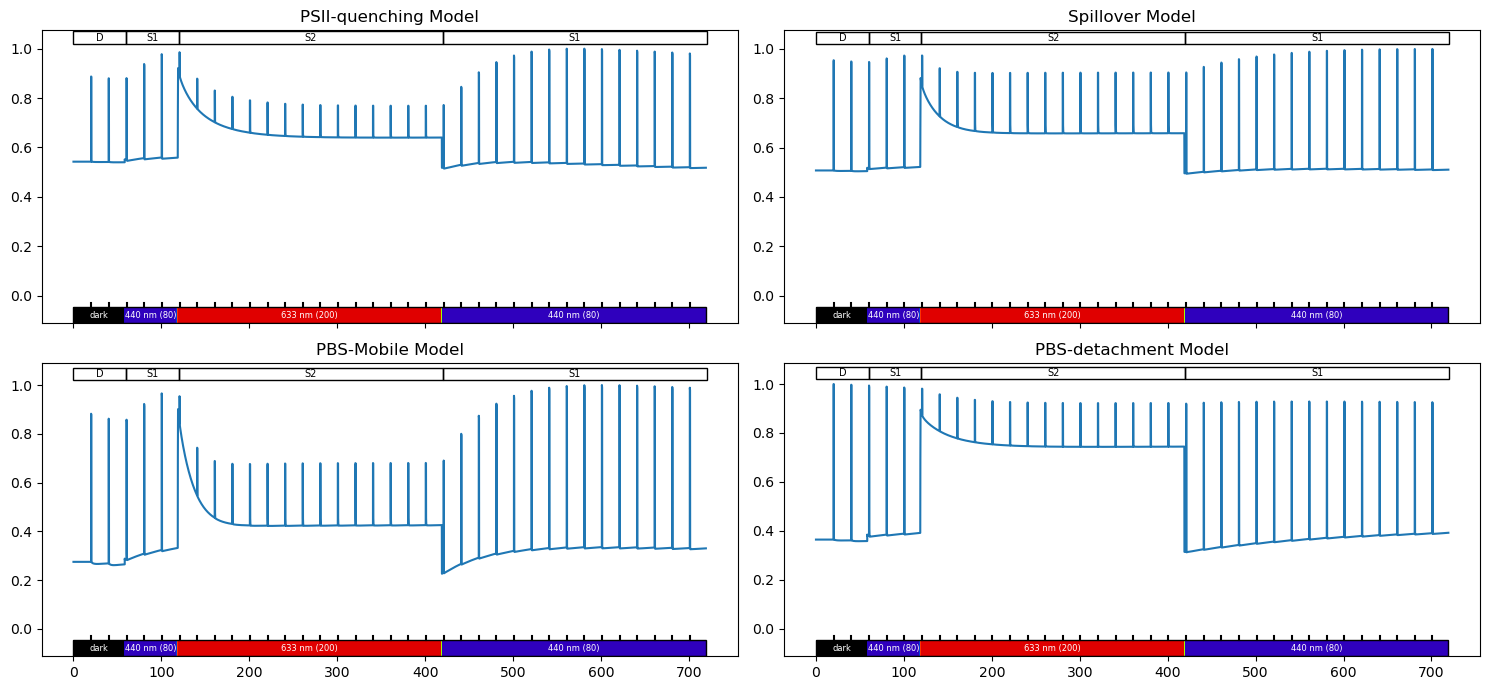

In [28]:
# Define the state transition models with the necessary parameters
models = {
    "mnost":{
        "pbs_behaviour": "static",
        "fun": remove_statetransitions_default,
        "param":{},
        "param_bounds":{}
    },
    "m0":{
        "pbs_behaviour": "static",
        "fun": dummy,
        "param":{
            "kUnquench": 0.1,
            "kQuench": 2e-3,
            "KMUnquench": 0.2,
        },
        "param_bounds":{
            "kUnquench": (0.01, 1),
            "kQuench": (2e-2, 2e-4),
            "KMUnquench": (0.01,0.3) ,
        }
    },
    "mspill":{
        "pbs_behaviour": "static",
        "fun": update_statetransitions_spillover,
        "param":{
            "kspill": 5e-3,
            "kunspill" :5e-4,
            "spillmax": 0.3 
        },
        "param_bounds":{
            "kspill": (5e-4, 5e-2),
            "kunspill": (5e-5, 5e-3),
            "spillmax": (0.1,0.6) ,
        }
    },
    "mpbsd":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_detachpbs1,
        "param":{
            "kPBS_detach":1e-4,
            "kPBS_attach":1e-3,
            "PBS_freemax":0.1
        },
        "param_bounds":{
            "kPBS_detach": (1e-5, 1e-3),
            "kPBS_attach": (1e-4, 1e-2),
            "PBS_freemax": (0.01,0.3),
        }
    },
    "mpbsm":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_mobilepbs,
        "param":{
            "kPBS_toPS1":5e-3,
            "kPBS_toPS2":1e-3,
            "PBS_PS1min": 0.25, 
            "PBS_PS2min": 0.35,
        },
        "param_bounds":{
            "kPBS_toPS1": (5e-4, 5e-2),
            "kPBS_toPS2": (1e-4, 1e-2),
            "PBS_PS1min": (0, 0.5),
            "PBS_PS2min": (0, 0.5)
        }
    }
}

orange_light_intensity = 200

# Simulate the models
sims = simulate_statetransition_models(
    models, 
    loadsim=not settings["state_transitions_PAM"]["recalculate"], 
    savesim=settings["state_transitions_PAM"]["recalculate"]
)

if settings["state_transitions_PAM"]["plot"]:
    titles = {
        "m0": "PSII-quenching Model",
        "mspill": "Spillover Model",
        "mpbsm": "PBS-Mobile Model",
        "mpbsd": "PBS-detachment Model",
    }

    # Plot of PAM traces
    fig, axes = plt.subplots(2,2, figsize=(15,7), sharey=False, sharex = True)

    axdims = pd.DataFrame(index=range(4), columns=["ymin","ymax"])

    for i, (ax, nam) in enumerate(zip(axes.flatten(), titles)):
        s = sims[nam]
        if nam == "mnost":
            continue

        # Fluorescence plot
        fluo = s.get_full_results_df()["Fluo"]
        ax.plot(fluo / fluo.max())
        axdims.iloc[i] = ax.get_ylim()
        ax.set_title(titles[nam])

        ax = annotate_phases_statetrans(ax)
        yadj = 0.08
        ax.set_ylim(ymin=0)
        # ax = add_insetbox(ax, 0.69, 0.975, 0.01 + yadj, 0.2 + yadj, adj_plotheight=[-0.15, 0])
        ax = fnc.add_lightbar(s, ax, 1000, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, spectrum_maskalpha=0, pad_top=0.08, annotation_twoline=False, annotation_light_c="w", annotation_size = 6)
    fig. tight_layout()

    fnc.savefig_dated(fig, "stmodels_pam", type=plot_format, path=figure_path)

## State Transition Models Analysis (Figure 4c & 12)

In [29]:

# Calculate steady state Q_reds under a range of parameter values
if settings["state_transitions_analysis"]["recalculate"]:
    print("Calculating Qreds and Fms...")
    Q_reds, vATPs, vCBBs, Fms = get_parametervariant_outputs( # Took 12h with 10 sample points
        models, 
        sims, 
        n=int(10 * fraction_simulated_points), 
        multiprocessing=settings["general"]["multiprocessing"],
        max_workers=settings["general"]["max_workers"],
        orange_light_intensity=orange_light_intensity,  #uE
    ) 
    # Recalculate the fluorescence trace with blue measuring light
    sims_blueML = {k:recalculate_with_altered_parameters(s, {"pfd_ML": lip.light_gaussianLED(450,1,1e-3)}, recalc_full_results=True) for k,s in sims.items()}

    fnc.save_obj_dated(Q_reds, "stmodels_Qreds", results_path)
    fnc.save_obj_dated(vATPs, "stmodels_vATPs", results_path)
    fnc.save_obj_dated(vCBBs, "stmodels_vCBBs", results_path)
    fnc.save_obj_dated(Fms, "stmodels_Fms", results_path)
    fnc.save_Simulator_dated(sims_blueML, "stmodels_blueML", results_path)
elif settings["state_transitions_analysis"]["plot"]:
    print("Loading Qreds and Fms...")
    Q_reds = fnc.load_obj_dated("stmodels_Qreds", results_path)
    vATPs = fnc.load_obj_dated("stmodels_vATPs", results_path)
    vCBBs = fnc.load_obj_dated("stmodels_vCBBs", results_path)
    Fms = fnc.load_obj_dated("stmodels_Fms", results_path)
    sims_blueML = fnc.load_Simulator_dated("stmodels_blueML", results_path)

if settings["state_transitions_analysis"]["plot"]:
    # Calculate the relative alleviation in PQ reduction
    Q_reds_rel = {k:(Q_reds["mnost"]-v[np.invert(np.isnan(v))])/Q_reds["mnost"] for k,v in Q_reds.items() if k != "mnost"}
    vATPs_rel = {k:(v[np.invert(np.isnan(v))] - vATPs["mnost"])/vATPs["mnost"] for k,v in vATPs.items() if k != "mnost"}
    vCBBs_rel = {k:(v[np.invert(np.isnan(v))] - vCBBs["mnost"])/vCBBs["mnost"] for k,v in vCBBs.items() if k != "mnost"}

    # Calculate the RMSE of fluorescence under dfferent measuring lights
    bluefluo_rmse = relative_fluo_diff(sims, sims_blueML)

Loading Qreds and Fms...


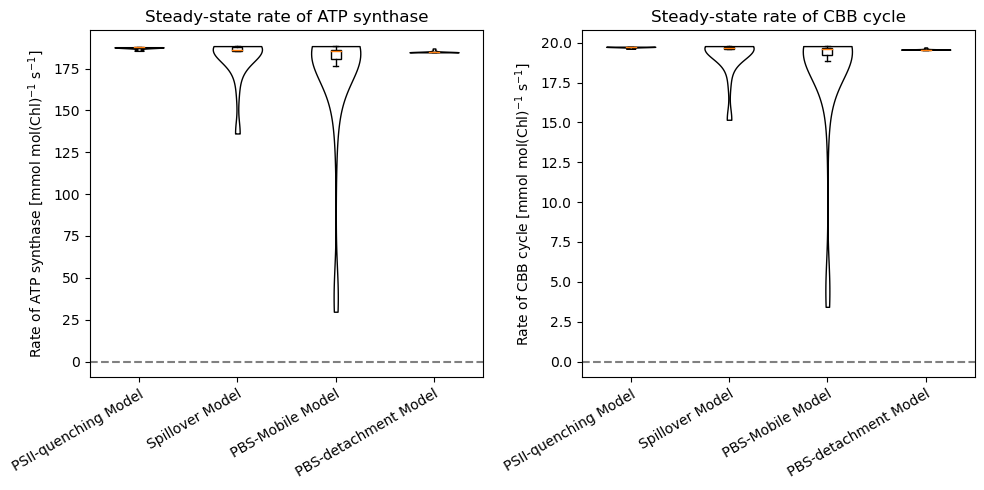

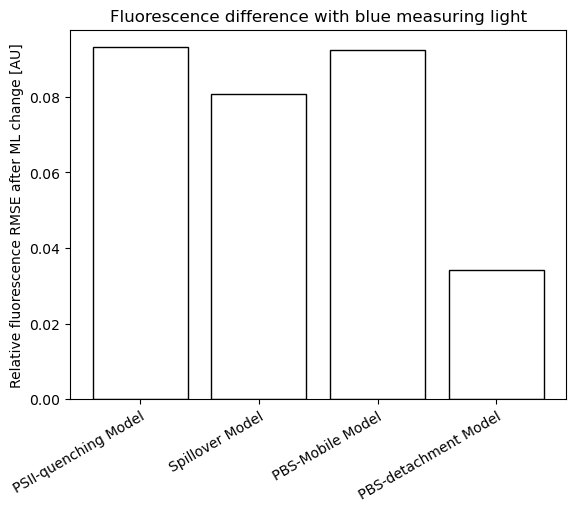

In [30]:
if settings["state_transitions_analysis"]["plot"]:
    # Plot of PQ reduction alleviation
    fig = paper_figs["fig4"]["subs"]["B"]
    axes = fig.subplots(1,2)
    ax=axes[0]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot([Q_reds_rel[x] for x in titles], patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 4)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot([Q_reds_rel[x] for x in titles], showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Alleviation of PQ reduction")
    ax.set_xticks(range(1,5), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative decrease in PQ reduction [rel.]")

    # Plot of reduction in fluorescence level
    ax=axes[1]
    data = [Fms[x][np.invert(np.isnan(Fms[x]))] for x in titles]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot(data, patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 4)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot(data, showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Fm' decrease during state 2")
    ax.set_xticks(range(1,5), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative Fm reduction from state 1 to state 2 [rel.]")

    # fig.tight_layout()
    fig. subplots_adjust(wspace=0.25)
    # fnc.savefig_dated(fig, "stmodels_analysis", type=plot_format, path=figure_path)


    # Plot of ATPsynthase and CBB rates
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    ax=axes[0]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot([vATPs[x] for x in titles], patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 4)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot([vATPs[x] for x in titles], showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Steady-state rate of ATP synthase")
    ax.set_xticks(range(1,5), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Rate of ATP synthase [mmol mol(Chl)$^{-1}$ s$^{-1}$]")

    # Plot of CBB rates
    ax=axes[1]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot([vCBBs[x] for x in titles], patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 4)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot([vCBBs[x] for x in titles], showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Steady-state rate of CBB cycle")
    ax.set_xticks(range(1,5), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Rate of CBB cycle [mmol mol(Chl)$^{-1}$ s$^{-1}$]")

    fig.tight_layout()
    fig. subplots_adjust(wspace=0.25)
    fnc.savefig_dated(fig, "stmodels_ATPsCBBanalysis", type=plot_format, path=figure_path)


    # Plot of RMSE from Fluorescence calculation with blue ML
    fig, ax = plt.subplots()
    ax.bar(range(4) ,[bluefluo_rmse[x] for x in titles], fill=False) 

    ax.set_title("")
    ax.set_xticks(range(4),list(titles.values()),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative fluorescence RMSE after ML change [AU]")
    ax.set_title("Fluorescence difference with blue measuring light")
    fnc.savefig_dated(fig, "stmodels_FblueRMSE", type=plot_format, path=figure_path, bbox_inches="tight")

In [31]:
# Repeat the analysis with different light intensities
# Calculate steady state Q_reds under a range of parameter values
intensities = [20, 50, 100, 300, 500]

if settings["state_transitions_analysis"]["recalculate"]:
    print("Calculating Qreds and Fms...")
    Q_reds_ivar = {}
    vATPs_ivar = {}
    vCBBs_ivar = {}
    Fms_ivar = {}
    
    for i in intensities:
        (
            Q_reds_ivar[i],
            vATPs_ivar[i],
            vCBBs_ivar[i],
            Fms_ivar[i]
        ) = get_parametervariant_outputs( 
            models, 
            sims, 
            n=3, 
            multiprocessing=settings["general"]["multiprocessing"],
            max_workers=settings["general"]["max_workers"],
            orange_light_intensity=i,  #uE
        ) 

    fnc.save_obj_dated(Q_reds_ivar, "stmodels_Qreds_ivar", results_path)
    fnc.save_obj_dated(vATPs_ivar, "stmodels_vATPs_ivar", results_path)
    fnc.save_obj_dated(vCBBs_ivar, "stmodels_vCBBs_ivar", results_path)
    fnc.save_obj_dated(Fms_ivar, "stmodels_Fms_ivar", results_path)
elif settings["state_transitions_analysis"]["plot"]:
    print("Loading Qreds and Fms...")
    Q_reds_ivar = fnc.load_obj_dated("stmodels_Qreds_ivar", results_path)
    vATPs_ivar = fnc.load_obj_dated("stmodels_vATPs_ivar", results_path)
    vCBBs_ivar = fnc.load_obj_dated("stmodels_vCBBs_ivar", results_path)
    Fms_ivar = fnc.load_obj_dated("stmodels_Fms_ivar", results_path)

if settings["state_transitions_analysis"]["plot"]:
    # Calculate the relative alleviation in PQ reduction, ATPsynthase rate and CBB rate
    stmodel_relative_changes = {}

    # The Q_red measurements are multiplied by -1 as lower is better
    for var, var_single, nam, factor in zip([Q_reds_ivar, vATPs_ivar, vCBBs_ivar], [Q_reds_rel, vATPs_rel, vCBBs_rel], ["Q_reds", "vATPs", "vCBBs"], [-1,1,1]):
        var_rel_ivar = {l:{k:(v[np.invert(np.isnan(v))] - Q_reds["mnost"])/Q_reds["mnost"] * factor for k,v in Q_reds.items() if k != "mnost"} for l,Q_reds in var.items()}
        var_rel_ivar.update({orange_light_intensity:var_single})

        stmodel_relative_changes[nam] = var_rel_ivar

    # var_rel_ivar = {l:{k:(Q_reds["mnost"]-v[np.invert(np.isnan(v))])/Q_reds["mnost"] for k,v in Q_reds.items() if k != "mnost"} for l,Q_reds in Q_reds_ivar.items()}
    # var_rel_ivar.update({orange_light_intensity:Q_reds_rel})

    # # Calculate the RMSE of fluorescence under dfferent measuring lights
    # bluefluo_rmse = relative_fluo_diff(sims, sims_blueML)

Loading Qreds and Fms...


In [32]:
fig = paper_figs["fig4"]["subs"]["C"]
axes = fig.subplots(2, sharex=True, height_ratios=[3,1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

colors = {
    'm0' : "black",
    'mspill': "red",
    'mpbsd': "blue",
    'mpbsm': "orange",
}

# Plot violin plots on two axes to exclude outliers
for ax in axes.flatten():
    for a, (i, Q_reds) in enumerate(stmodel_relative_changes["Q_reds"].items()):
        for j,mdl in enumerate(titles):
            if mdl == "mnost":
                continue
            else:
                dat = Q_reds[mdl]
                # ax.plot(np.repeat(i + (j-2.5) * 5 len(dat)), dat, c=colors[mdl], ls="", marker=".")
                bp = ax.violinplot(dat, [i + (j-1.5) * 7], showextrema=False, widths=5)
                for pc in bp['bodies']:
                    pc.set_facecolor('white')
                    pc.set_edgecolor(colors[mdl])
                    pc.set_alpha(1)

# Set ylim
axes[0].set_ylim(-0.2,1)
axes[1].set_ylim(None, -0.2)

# Hide the lines between both axes
axes[0].spines.bottom.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop=False)  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

# Add "cut axis marker lines"
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

# Set the plot annotation
# axes[0].set_ylabel("Relative decrease in PQ reduction [rel.]")
fig.text(0.03, 0.5, "Relative decrease in PQ reduction [rel.]", va='center', rotation='vertical')
axes[1].set_xlabel("Orange light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
axes[0].axhline(0, c="k", ls="--", alpha=0.5)

# Set the x-axis ticks
axes[1].set_xticks(list(stmodel_relative_changes["Q_reds"].keys()))

labels = []
for mdl, color in colors.items():
    labels.append((mpatches.Patch(color=color), titles[mdl]))
axes[1].legend(*zip(*labels), loc="lower right")

# Mark the used light intensity
rect = mpatches.Rectangle((175, -0.12), 50, 1.1, linewidth=1, edgecolor='k', facecolor='none')
axes[0].add_patch(rect)
axes[0].text(200, -0.18, "chosen intensity", ha="center")

fig.suptitle("Alleviation of PQ reduction at different light intensities", y=0.93)
# fnc.savefig_dated(fig, f"stmodels_pqivar", type=plot_format, path=figure_path)

Text(0.5, 0.93, 'Alleviation of PQ reduction at different light intensities')

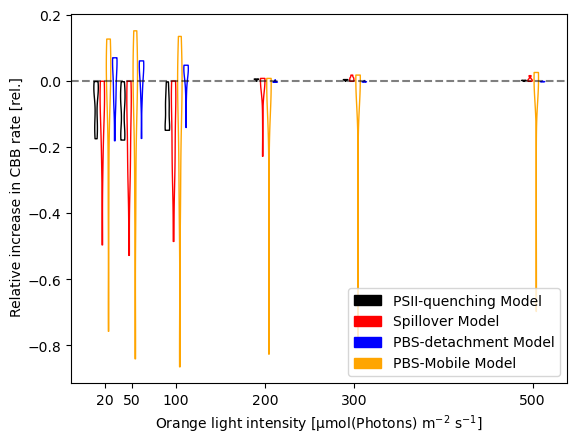

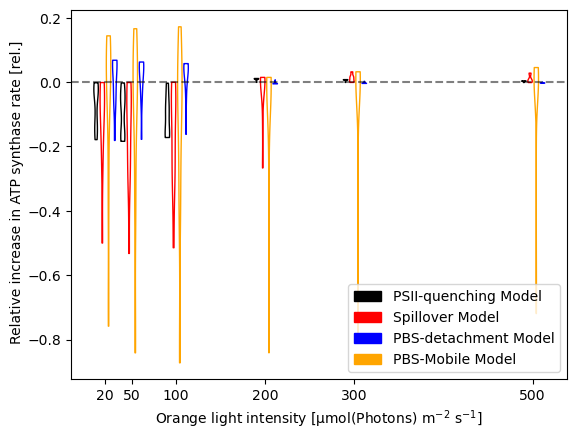

In [33]:
colors = {
    'm0' : "black",
    'mspill': "red",
    'mpbsd': "blue",
    'mpbsm': "orange",
}

# Plot violin plots on two axes to exclude outliers
for var_nam, var_title in zip(["vCBBs", "vATPs"], ["Relative increase in CBB rate [rel.]", "Relative increase in ATP synthase rate [rel.]"]):
    fig, ax = plt.subplots()
    for a, (i, Q_reds) in enumerate(stmodel_relative_changes[var_nam].items()):
        for j,mdl in enumerate(titles):
            if mdl == "mnost":
                continue
            else:
                dat = Q_reds[mdl]
                # ax.plot(np.repeat(i + (j-2.5) * 5 len(dat)), dat, c=colors[mdl], ls="", marker=".")
                bp = ax.violinplot(dat, [i + (j-1.5) * 7], showextrema=False, widths=5)
                for pc in bp['bodies']:
                    pc.set_facecolor('white')
                    pc.set_edgecolor(colors[mdl])
                    pc.set_alpha(1)

    # Set the plot annotation
    # axes[0].set_ylabel("Relative decrease in PQ reduction [rel.]")
    fig.text(0.03, 0.5, var_title, va='center', rotation='vertical')
    ax.set_xlabel("Orange light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.axhline(0, c="k", ls="--", alpha=0.5)

    # Set the x-axis ticks
    ax.set_xticks(list(stmodel_relative_changes["Q_reds"].keys()))

    labels = []
    for mdl, color in colors.items():
        labels.append((mpatches.Patch(color=color), titles[mdl]))
    ax.legend(*zip(*labels), loc="lower right")

    # Mark the used light intensity
    # rect = mpatches.Rectangle((175, -0.12), 50, 1.1, linewidth=1, edgecolor='k', facecolor='none')
    # axes[0].add_patch(rect)
    # axes[0].text(200, -0.18, "chosen intensity", ha="center")
    fnc.savefig_dated(fig, f"stmodels_{var_nam}", type=plot_format, path=figure_path)

In [34]:
fig = paper_figs["fig4"]["subs"]["D"]
axes = fig.subplots(3, sharex=True)

for i, ax in zip([50, 200, 500], axes.flatten()):
    for mdl in titles:
        x = stmodel_relative_changes["Q_reds"][i][mdl] * 100
        y = (1 +stmodel_relative_changes["vCBBs"][i][mdl]) * 100
        ax.plot(x, y, ls="", marker=".", label=titles[mdl])

        ax.axhline(0, ls="--", c="k")
        ax.axvline(0, ls="--", c="k")
        ax.set_title(f"Light intensity: {i} ")
    
        ax.xaxis.set_major_formatter(PercentFormatter())
        ax.yaxis.set_major_formatter(PercentFormatter())

axes[0].set_xlim(0, 100)
axes[0].legend()
axes[-1].set_xlabel("Lowered PQ reduction compared to no ST model [%]")

fig.text(0.0, 0.5, "CBB rate compared to no ST model [%]", va='center', rotation='vertical')

Text(0.0, 0.5, 'CBB rate compared to no ST model [%]')

# Productivity of different sinks with varying light (Figure 5b, 5c, & 13)

In [35]:
m,y0 = get_model()

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


In [36]:
def _get_mca_model(p={}):
    m_MCA,y0 = get_model(verbose=False, check_consistency=False)
    m_MCA = fnc.add_exchange(m_MCA)
    m_MCA.update_parameters(p)
    s_MCA = Simulator(m_MCA)
    s_MCA.initialise(y0)
    return s_MCA

def get_CO2_production(light_param, p={}, strainp=None):
    # Create model, update strain parameters is necessary
    if strainp is not None:
        p.update(strainp[light_param[0]])
    s_MCA = _get_mca_model(p)

    # Adjust the light
    light = lip.light_gaussianLED(*light_param, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    # t,y = s_MCA.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s_MCA,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        return s_MCA.get_fluxes_dict()["vExch_3PGA"][-1]

def get_Qredfraction(sim_param, p={}, strainp=None):
    # Create model, update strain parameters is necessary
    light_param = sim_param[:-1]
    if strainp is not None:
        p.update(strainp[sim_param[-1]])
    s_MCA = _get_mca_model(p)

    # Adjust the light
    light = lip.light_gaussianLED(*light_param, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    # t,y = s_MCA.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s_MCA,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        Q_ox = s_MCA.get_results_dict()["Q_ox"][-1]
        Q_tot = s_MCA.model.get_parameter("Q_tot")
        return (Q_tot - Q_ox) / Q_tot

def get_CO2_production_2lights(light_param, p={}, strainp=None):
    # Create model, update strain parameters is necessary
    if strainp is not None:
        p.update(strainp[light_param[0]])
    s_MCA = _get_mca_model(p)

    # Adjust the light
    w1,i1,w2,i2 = light_param
    light1 = lip.light_gaussianLED(w1, i1, spread=1e-3)
    light2 = lip.light_gaussianLED(w2, i2, spread=1e-3)
    s_MCA.update_parameter("pfd", light1 + light2)

    t,y = s_MCA.simulate_to_steady_state(tolerance=1e-4)
    if t is None:
        return np.nan
    else:
        return s_MCA.get_fluxes_dict()["vExch_3PGA"][-1]

## $CO_2$ Production under Monochromatic Lights (Figure 5b)

In [37]:
if settings["CO2_fluxes_monochrom"]["recalculate"]:
    wavelength = [405, 440, 480, 550, 590, 624, 674]
    intensities = np.linspace(80, 800, 10)

    light_params = np.meshgrid(wavelength, intensities)
    _light_params = zip(*[x.flatten() for x in light_params])

    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
        CO2s = np.array(list(map(get_CO2_production, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            CO2s = np.array(list(pe.map(get_CO2_production, _light_params)), dtype=float)
    CO2s = CO2s.reshape(-1,len(wavelength))
    CO2s = pd.DataFrame(
        CO2s, 
        index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
        columns=pd.Index(wavelength, name="Wavelength [nm]")
    )
    fnc.save_obj_dated(CO2s, "CO2production_wi", results_path)

In [38]:
if settings["CO2_fluxes_monochrom"]["plot"]:
    CO2s = fnc.load_obj_dated("CO2production_wi", results_path)

    fig = paper_figs["figS9"]["subs"]["A"]
    ax = fig.subplots()
    fig, ax = fnc.plot_heatmap(CO2s, clab="Net CO$_2$ consumption rate [mmol mol(Chl)$^{-1}$ s$^{-1}$]", ax=ax)
    ax.set_title("CO$_2$ consumption under near-monochromatic lights")
    ax = fnc.add_na_annotation(ax, CO2s, 6)
    # fnc.savefig_dated(fig, "CO2prod_singlemonochr", type=plot_format, path=figure_path)

## $CO_2$ Production under Monochromatic Lights With Adapted Cells (Figure 13)

In [39]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,light] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def normalise_concentrations(dat_conc):
    # Convert to [mg mg(Chla)^-1]
    dat_conc = dat_conc.div(dat_conc.loc['chla',:]) # convert to [mg mg(Chla)^-1]
    return dat_conc

def _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo, fraction_is_monomers=True, output_is_monomers=False):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,growthlight]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,growthlight]), fraction_is_monomers=fraction_is_monomers, output_is_monomers=output_is_monomers)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def get_strain_parameters(dat, pbs_relfluo, ps_fraction_is_monomers=True, ps_output_is_monomers=False):
    # Get the pigments
    df_pigments = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
    df_pigments.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']
    df_pigments = normalise_concentrations(df_pigments)

    # Get Phycobilisome attachment
    df_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
    df_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]
    
    # Get PS1:PS2 ratio
    df_PS1_PS2 = dat.loc[["PSI / PSII"],:]

    res = {}
    for wl in dat.columns:
        res[wl] = _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, wl, pbs_relfluo)
    return res

In [40]:
# Get the parameters defining different strains 
# (pigments, photosystems ratios, PBS attachment)
strains= pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc[:,"435":"687"]
strains.columns = strains.columns.astype(int)

strain_params = get_strain_parameters(
    strains, 
    {"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    ps_fraction_is_monomers=True,
    ps_output_is_monomers=False
)

In [41]:
if settings["CO2_fluxes_monochrom_adapted"]["recalculate"]:
    # Calculate the CO2 production
    wavelength = list(strain_params.keys())
    intensities = np.linspace(80, 800, 10)

    light_params = np.meshgrid(wavelength, intensities)
    _light_params = zip(*[x.flatten() for x in light_params])

    _get_CO2_production = partial(get_CO2_production, strainp=strain_params)

    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
        CO2s = np.array(list(map(_get_CO2_production, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            CO2s = np.array(list(pe.map(_get_CO2_production, _light_params)), dtype=float)
    CO2s = CO2s.reshape(-1,len(wavelength))
    CO2s = pd.DataFrame(
        CO2s, 
        index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
        columns=pd.Index(wavelength, name="Wavelength [nm]")
    )
    fnc.save_obj_dated(CO2s, "CO2production_adapt_wi", results_path)

In [42]:
if settings["CO2_fluxes_monochrom_adapted"]["plot"]:
    CO2s = fnc.load_obj_dated("CO2production_adapt_wi", results_path)

    # Plot the CO2 production
    fig = paper_figs["figS9"]["subs"]["B"]
    ax = fig.subplots()
    fig, ax = fnc.plot_heatmap(CO2s, clab="Net CO$_2$ consumption rate [mmol mol(Chl)$^{-1}$ s$^{-1}$]", ax=ax)
    ax.set_title("CO$_2$ consumption of adapted cells under near-monochromatic lights")
    ax = fnc.add_na_annotation(ax, CO2s, 6)
    # fig.tight_layout()
    # fnc.savefig_dated(fig, "CO2prod_singlemonochr_adapt", type=plot_format, path=figure_path)

## Variable Sink Production under Monochromatic Lights (Figure 5b & 5c)

In [43]:
# Sink reaction with hill kinetics for each compound
def vsink_hill(k, *X):
    concs = X[:len(X)//2]
    Ks = X[len(X)//2:]

    if len(concs) != len(Ks):
        raise ValueError("differing numbers of concentrations and Hill constants given")

    res = k
    for conc, K in zip(concs, Ks):
        res*= rf.hill(S=conc, vmax=1, kd=K, n=4)

    return res

In [44]:
# Add a sink reaction with Mass Action kinetics to the model
# def vsink(*X):
#     res = 1
#     for x in X:
#         res *=x
#     return res

# Add a sink reaction with Mass Action kinetics to the model, where each compound concentration is squared
# def vsink(*X):
#     return reduce(mul, np.array(X[1:])**2, X[0])

def vcap(S, k, thresh, lower_cap=False):
    v = np.array(k * (S - thresh))
    v = v.reshape(-1)
    if not lower_cap:
        v[v<0] = 0
    return v

def add_sink(m, stoich, k=10000):
    # Make a copy of the model, in case the mca adaption version should not be applied to the original model
    m = m.copy()

    # Add the sink parameters and cap 3PGA, ATP and NADPH
    m.add_parameters({
        "kSink": k,
    })

    for cap in ["3PGA", "ATP", "NADPH"]:
        # Cap 3PGA, ATP and NADPH levels
        # Set the stoichiometry
        if cap == "NADPH":
            cap_stoich = {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            }
        else:
            cap_stoich = {cap:-1}

        # Set the cap level
        if cap == "3PGA":
            cap_thresh = 1000
        elif cap == "ATP":
            cap_thresh = 0.95 * m.get_parameter("AP_tot")
        elif cap == "NADPH":
            cap_thresh = 0.95 * m.get_parameter("NADP_tot")


        m.add_parameters({
            f"kCap_{cap}": 10000,
            f"threshCap_{cap}": cap_thresh,
            f"lowerCap_{cap}": False,
        })
        
        m.add_reaction_from_args(
            rate_name=f"vCap_{cap}",
            function=vcap,
            stoichiometry=cap_stoich,
            args=[cap, f"kCap_{cap}", f"threshCap_{cap}", f"lowerCap_{cap}"]
        )

    # Define the stoichiometry necessary for the sink reaction and the compounds that should be used for the kinetic function
    modelstoich = {k:v for k,v in stoich.items() if k in m.get_compounds()}
    vargs = [k for k,v in stoich.items() if v<0]

    # Define the hill constants for the different compounds
    KHills = {
        "Q_red":(0.1 * m.parameters["Q_tot"])**4,
        "PC_red": (0.1 *m.parameters["PC_tot"])**4,
        "Fd_red": (0.1 *m.parameters["Fd_tot"])**4,
        "NADPH": (0.1 *m.parameters["NADP_tot"])**4,
        "NADH": (0.1 *m.parameters["NAD_tot"])**4,
        "ATP": (0.1 *m.parameters["AP_tot"])**4,
        "3PGA": 1,
        "Ho": (0.001)**4
    }

    if len(modelstoich) != len(vargs):
        raise ValueError("stoichiometry unbalanced")

    # Select ne needed Hill constants
    Kargs = {f"KSink_{comp}":KHills[comp] for comp in vargs}

    # Add the necessary parameters to the model
    m.add_parameters(Kargs)

    m.add_reaction_from_args(
        rate_name=f"vsink",
        function=vsink_hill,
        stoichiometry=modelstoich,
        args=["kSink"] + vargs + list(Kargs.keys())
    )

    return m

# Get the steady-state sink production
def get_sink_mca_model(stoich, param_update={}):
    m_MCA,y0 = get_model(verbose=False, check_consistency=False)
    m_MCA = add_sink(m_MCA, stoich, k=1e5)
    s_MCA = Simulator(m_MCA)
    s_MCA.update_parameters(param_update)
    s_MCA.initialise(y0)
    return s_MCA

def get_sink_production(stoich, strain_params=None, param_update=None, light_param=None):
    # Create model
    s_MCA = get_sink_mca_model(stoich, param_update)

    # Adjust the light
    # If the strain parameters are from rodrigues, the first light param will be <wavelength>_<groowthlight intensity>
    wl, intens = light_param[:2]

    if ("_" in wl):
        wl = wl.split("_")[0]

    light = lip.light_gaussianLED(int(wl), intens, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    if strain_params is not None:
        s_MCA.update_parameters(strain_params[light_param[0]])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        s_MCA, t, y = simulate_to_steady_state_custom(
            s_MCA,
            simulation_kwargs={
                "t_end": 1e6,
                "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
                "verbose": True,
            },
            rel_norm=True,
            return_simulator=True,
            **fnc.simulator_kwargs["loose"],
        )
        if t is None:
            return np.nan
        else:
            # Test if one compound is used to at least 5%
            compounds_dict = {
                "Q_red": 0.05 * s_MCA.model.parameters["Q_tot"],
                "PC_red": 0.05 * s_MCA.model.parameters["PC_tot"],
                "Fd_red": 0.05 * s_MCA.model.parameters["Fd_tot"],
                "NADPH": 0.05 * s_MCA.model.parameters["NADP_tot"],
                "NADH": 0.05 * s_MCA.model.parameters["NAD_tot"],
                "ATP": 0.05 * s_MCA.model.parameters["AP_tot"],
                "3PGA": 1,
            }
            usage = {k: s_MCA.get_full_results_df().loc[:,k].iloc[-1] < compounds_dict[k] for k in compounds_dict if k in stoich}
            if np.sum(list(usage.values())) <1:
                finals = {k: s_MCA.get_full_results_df().loc[:,k].iloc[-1] for k in compounds_dict if k in stoich}
                warn(f"insufficient usage of sink compounds: {finals}\ntested sink: {stoich, light_param}")
            return s_MCA.get_fluxes_dict()["vsink"][-1]

In [45]:
# Different possible sink reactions with stoichiometries
sinks = {
    "ATP":{
        "stoich": {"ATP":-1},
        "title": "ATP production rate",
        "compound": "ATP"
    },
    "NADPH":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "title": "NADPH production rate",
        "compound": "NADPH"
    },
    "terpenes":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -3,
            "NADPH": -1,
            "Ho": -5/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
            "3PGA": -2,
        },
        "title": "Isoprene production (energy carrier & 3PGA)",
        "compound": "Isoprene"
    },
    "sucrose":{
        "stoich": {
            "NADPH": -2,
            "Ho": -2/m.get_parameter("bHo"),
            "ATP": -3,
            "3PGA": -2
        },
        "title": "Sucrose production (energy carrier & 3PGA)",
        "compound": "Sucrose"
    },
    "glycogen":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            "ATP": -2,
            "3PGA": -1
        },
        "title": "Glycogen production (energy carrier & 3PGA)",
        "compound": "Glycogen"
    },
    # "highATP":{
    #     "stoich": {
    #         "NADPH": -1,
    #         "Ho": -1/m.get_parameter("bHo"),
    #         "ATP": -3,
    #         "3PGA": -1
    #     },
    #     "title": "Glycogen + 1 ATP"
    # },
}
sinks_AN = {
    # Only use ATP:NADPH ratio
    "ATP_noCBB":{
        "stoich": {"ATP":-1},
        "param_update":{"vCBB_max":0, "lowerCap_3PGA":True},
        "title": "ATP production (no CBB)",
        "compound": "ATP"
    },
    "NADPH_noCBB":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "param_update":{"vCBB_max":0, "lowerCap_3PGA":True},
        "title": "NADPH production",# (no CBB)",
        "compound": "NADPH"
    },
    "terpenes_ratio":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -19,
            "NADPH": -11,
            "Ho": -15/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
        },
        "param_update":{"vCBB_max":0, "lowerCap_3PGA":True},
        "title": "Isoprene production",# (energy carrier ratio, no CBB)",
        "compound": "Isoprene"
    },
    "sucrose_ratio":{
        "stoich": {
            "NADPH": -12,
            "Ho": -12/m.get_parameter("bHo"),
            "ATP": -19,
        },
        "param_update":{"vCBB_max":0, "lowerCap_3PGA":True},
        "title": "Sucrose production",# (energy carrier ratio, no CBB)",
        "compound": "Sucrose"
    },
    "glycogen_ratio":{
        "stoich": {
            "NADPH": -6,
            "Ho": -6/m.get_parameter("bHo"),
            "ATP": -11,
        },
        "param_update":{"vCBB_max":0, "lowerCap_3PGA":True},
        "title": "Glycogen production", # (energy carrier ratio, no CBB)",
        "compound": "Glycogen"
    },
    # "highATP_ratio":{
    #     "stoich": {
    #         "NADPH": -6,
    #         "Ho": -6/m.get_parameter("bHo"),
    #         "ATP": -11,
    #     },
    #     "param_update":{"vCBB_max":0, "lowerCap_3PGA":True},
    #     "title": "Glycogen + 1 ATP  ATP:NADPH"
    # },
}

if settings["sink_production_monochrom"]["recalculate"]:
    # Calculate and plot the sink production
    for i,_sinks in enumerate([sinks, sinks_AN]):
        if i == 0:
            intensities = np.linspace(80, 800, 10).round().astype(int)
        else:
            intensities = np.linspace(80, 1600, 10).round().astype(int)

        for sink in _sinks:
            print(sink)
            wavelength = [405,440, 480, 550, 590, 624, 674]

            light_params = np.meshgrid(wavelength, intensities)
            _light_params = zip(*[x.flatten() for x in light_params])

            _get_sink_production = partial(
                get_sink_production, 
                _sinks[sink]["stoich"],
                None,
                _sinks[sink].get("param_update", {})
            )

            if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
                prods = np.array(list(map(_get_sink_production, _light_params)), dtype=float)
            else:
                with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
                    prods = np.array(list(pe.map(_get_sink_production, _light_params)), dtype=float)
            prods = prods.reshape(-1,len(wavelength))
            prods = pd.DataFrame(
                prods, 
                index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
                columns=pd.Index(wavelength, name="Wavelength [nm]")
            )
            fnc.save_obj_dated(prods, f"sink_{sink}_wi", results_path)



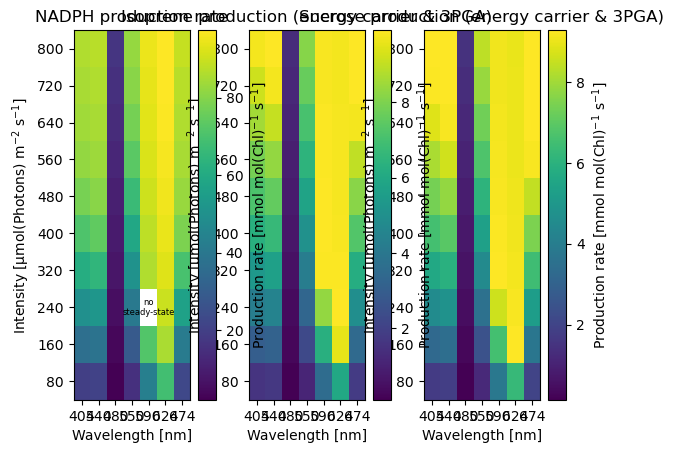

In [46]:
if settings["sink_production_monochrom"]["plot"]:
    combined_plots = {
        "withCBB": ["NADPH", "terpenes", "sucrose"],
        "noCBB": ["NADPH_noCBB", "terpenes_ratio", "sucrose_ratio"]
    }

    for _sinks, nam in zip([sinks, sinks_AN], ["withCBB", "noCBB"]):
        # Create a combined plot

        if nam == "noCBB":
            fig_com = paper_figs["fig5"]["subs"]["B"]
            axes_com = fig_com.subplots(1,3) #, sharex=True, sharey=True)
        else:
            fig_com, axes_com = plt.subplots(1,3)

        for sink in _sinks:
            prods = fnc.load_obj_dated(f"sink_{sink}_wi", results_path)

            # Single plot
            fig, ax = fnc.plot_heatmap(prods, clab=f"Production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
            ax.set_title(_sinks[sink]['title'])
            ax = fnc.add_na_annotation(ax, prods, 6)
            fig.tight_layout()
            fnc.savefig_dated(fig, f"{sink}prod_singlemonochr", type=plot_format, path=figure_path)
            plt.close()

            # Combined plot
            if sink in combined_plots[nam]:
                ax_com = axes_com[combined_plots[nam].index(sink)]
                fig, ax_com = fnc.plot_heatmap(prods, clab=f"Production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]", ax=ax_com)
                ax_com.set_title(_sinks[sink]['title'])
                ax_com = fnc.add_na_annotation(ax_com, prods, 6)
        
        # fig_com.tight_layout()
        # fnc.savefig_dated(fig_com, f"sinkprod_{nam}_singlemonochr", type=plot_format, path=figure_path)

# Pulse Amplitude Modulation (PAM) measurements with saturation pulse method
## PAM-SP under of 435 nm adapted strain (Figure 2a)

In [47]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

### Get the PAM and strain data

In [48]:
def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,str(light)] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,str(growthlight)]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,str(growthlight)]), fraction_is_monomers=True, output_is_monomers=False)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def _plot_model_and_data(s, data, sim_offset=None, data_offset=None, ax=None):
    # Initialise a plot
    if ax is None:
        fig, ax = plt.subplots(**fnc.plt_defaults["figure"])
    else:
        fig = ax.figure

    # Align data and model using an offset
    if sim_offset is None:
        time = s.get_time()
    elif s.get_time()[0] != (-sim_offset):
        time = np.array(s.get_time())- (s.get_time()[0] + sim_offset)
    else:
        time = s.get_time()

    # Plot the data
    dat = data/data.max().max()
    dat_time = dat.index

    if data_offset is not None:
        dat_time -= data_offset
    dat_line = ax.plot(dat_time, dat.values, c="firebrick", label="Measurement")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluorescence [rel.]")
    ax.set_ylim(ymin=0)

    # Plot the simulation on top
    fluo = s.get_full_results_dict()["Fluo"]
    fluo_norm = fluo / fluo.max()
    sim_line = ax.plot(time, fluo_norm, c="black", label="Simulation")

    if len(dat_line)>1:
        handles = sim_line + dat_line[0]
    else:
        handles = sim_line + dat_line

    ax.legend(
        handles = handles,
        loc="center right",
        bbox_to_anchor = (1,0.85)
    )

    return fig, ax

def plot_model_and_data(s, data, pulse_pfd, ax=None, sim_offset=None, data_offset=None, **lightbar_kwargs):
    figs={}

    # Data plot
    col_select_kw = "^F"
    col_select = [i for i,x in enumerate(data.columns) if re.search(col_select_kw, x)]
    col_selectnam = data.columns[col_select]
    plot_data = data.loc[10:data.index[-1]-10, col_selectnam[:-1]]

    s_trim = fnc.remove_beginning_from_simulation(s, 300)

    fig,ax = _plot_model_and_data(s_trim, plot_data, sim_offset=sim_offset, data_offset=data_offset, ax=ax)
    ax = fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, **lightbar_kwargs)

    return fig, ax

def annotate_electron_pathways(ax, epath):
    ypos = epath.cumsum(axis=1) - (epath/2)

    for y,s in zip(ypos.to_numpy().flatten(), epath.to_numpy().flatten()):
        ax.text(x=0, y=y, s=np.round(s,3), ha='center', va='center')
    return ax

def ss_analysis(m, light_int=100, light_wl=659):
    sslight = lip.light_gaussianLED(light_wl, light_int)
    mss = m.copy()
    mss.update_parameter("pfd", sslight)

    # Initialise the model
    sss=Simulator(mss)
    sss.initialise(y0)
    t,y = sss.simulate(10000)

    # plot_overview_isoATP(sss)
    epath = fnc.get_ss_electron_pathways(sss)
    epath = epath/float(epath.sum(axis=1, skipna=False))
    ax = epath.plot(kind="bar", stacked=True)

    # Annotate the bars
    ax = annotate_electron_pathways(ax,epath)
    return sss, [ax], epath

In [49]:
# Get the fluorescence data paths
DIRPATH = Path("../Code/data")
PAMPATH = DIRPATH / "PAM_Slow_kinetics_files_Zavrel2021"
file_names = listdir(PAMPATH)
file_paths = np.array([join(PAMPATH, file_name) for file_name in file_names])

In [50]:
# Extract the measurement type from the file name, use to group replicates
meas_types = np.array([re.sub(r"([0-9]+)_[0-9]+\.[csvCSV]+", "\\1", x) for x in file_names])
meas_types_set = list(set(meas_types))
meas_types_set.sort()

In [51]:
# Load and preprocess all data
pamdata = {}

for meas_select in  meas_types_set:
    file_paths_select = file_paths[meas_types == meas_select]

    # Create a container for the combined data
    meas_data = pd.DataFrame([])

    # Iterate through the files
    for i,file_path in enumerate(file_paths_select):
        # Adapt the file reading parameters depending on the file structure
        if meas_select.startswith("PSI+PSII kinetics"):
            skiprows = 1
        else:
            skiprows = 0
        
        # Read the file and remove empty columns
        file_data = pd.read_csv(file_path, sep=";",skiprows=skiprows, index_col=0)
        file_data=file_data.loc[:,np.invert(np.all(np.isnan(file_data), axis=0))]

        if i == 0:
            # Save the common column names
            col_names = file_data.columns

        # Combine replicates
        meas_data = meas_data.join(file_data, rsuffix=f"_{i}", how="outer")

    # Exclude all data points that are nor present in all datasets
    excl_data = meas_data.iloc[list(np.invert(np.isnan(meas_data).any(axis=1))),:]
    excl_data.shape
        
    # Normalise the Data to its highest point
    norm_data = excl_data.copy()
    norm_data = norm_data / norm_data.max()

    # Set the normalised data as analysis data
    data = norm_data

    # # Calculate the mean over selected columns
    # for col_name in col_names:
    #     col_select = [bool(re.search(col_name, x)) for x in data.columns]
    #     col_mean = data.iloc[:,col_select].mean(axis=1, skipna=False).rename(f"{col_name}_mean")

    #     # Add to the dataframe
    #     data = data.join(col_mean)
    
    # Store the data
    pamdata[meas_select] = data

# Extract the growth lights
growthlights = set([re.sub("^.*([0-9]{3})$","\\1",meas_select) for meas_select in meas_types_set])

In [52]:

# Get the strain-specific parameters
dat = pd.read_csv(DIRPATH / "Strainparameters_Zavrel2021.csv", skiprows=1, index_col=0).iloc[:,2:]

# Get the concentration data
# dat_conc = dat.loc[dat.loc[:,"Unit"].str.match("fg cell-1"), :]
dat_conc = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
dat_conc.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

# Convert to [mg mg(Chla)^-1]
dat_conc = dat_conc.div(dat_conc.iloc[0,:]) # convert to [mg mg(Chla)^-1]
dat_conc.loc[:,"Unit"] = "mg mg(Chla)^-1"

# Get the photosystems data
dat_PS = dat.loc[["PSI / PSII"],:]

# Get the phycobilisome data
dat_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
dat_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]


# Calculate the strain parameters
strain_params = {}
strain_export = {}

for growthlight in dat.columns:
    # Get the strain specific parameters
    strain_param = get_strain_parameters(
        df_pigments=dat_conc,
        df_PBS=dat_PBS,
        df_PS1_PS2=dat_PS,
        growthlight=growthlight,
        pbs_relfluo={"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    )

    MChl = 893.509 # [g mol^-1]
    absorption_coef = lip.get_pigment_absorption(strain_param["pigment_content"]).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

    # Get the PAM sample Chl concentration
    # Estimated from a later measurement where OD600 = 0.8, the PAM samples had 0.6
    OD800_Chlconc = pd.read_excel(DIRPATH/"Chlorophyll, total car.xlsx", skiprows=1).iloc[1:,].loc[:,["Sample", "Chlorophyll a"]]
    OD800_Chlconc.loc[:,"Sample"] = OD800_Chlconc.loc[:,"Sample"].str.removesuffix(" nm")
    OD800_Chlconc = OD800_Chlconc.groupby("Sample").mean()
    OD800_Chlconc.head() # [mol (10 ml)^-1]

    indexmapping = {idx1:idx2 for idx1,idx2 in zip(dat.columns, OD800_Chlconc.index)}

    # Convert the chlorophyll concentration units
    cuvette_Chlconc = ( # [mmol(Chl) m^-3]
        float(OD800_Chlconc.loc[indexmapping[str(growthlight)]]) # [mol (10 ml)^-1]
        / 10 # [ml]
        * 1e3 # [mol mmol^-1]
        * 1e6 # [ml m^-3]
        * 0.3 / 0.8 # [rel] OD of the PAM sample
    )

    # Save the data
    strain_params[growthlight] = {
        "params": strain_param,
        "cuvette_Chlconc": cuvette_Chlconc
    }

### Model the data

In [53]:

lights = make_lights(blue_wl=480)
lights_adj = make_adjusted_lights(absorption_coef, cuvette_Chlconc)
dark_adj, low_blue_adj, high_blue_adj, orange_adj, pulse_orange_adj, pulse_blue_adj = lights_adj

# Get the pfd of the pulses
pulse_pfd = np.min([simpson(x) for x in [pulse_orange_adj, pulse_blue_adj]])

In [54]:
def complex_absorption(pfd, ps_ratio, pigment_content):
    absorption = lip.get_pigment_absorption(pigment_content)
    association = lip.get_pigment_association(
        ps_ratio,
        beta_carotene_method="stoichiometric",
        pigments=pigment_content,
        verbose=False,
    )

    M_chl = 893.509  # [g mol^-1] molar mass of chlorophyll a (C55H72MgN4O5)

    return (
        lip.get_complex_absorption(pfd, absorption, association) * M_chl
    )  # [µmol(Photons) mmol(Chl)^-1 s^-1]

### Simulate all of the datasets (435 & 633nm light in two light protocols)

In [55]:
sims = {}

# Select the measurement to simulate
for meas_select in meas_types_set:
    growthlight = int(meas_select[-3:])

    print("Measurement: ", meas_select, "\nSimulated light: ", growthlight,"\n")

    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model(check_consistency=False, reduced_size=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Change the CO2 concentration to 400ppm as experiments were conducted in air
    m4.update_parameter("CO2ext_pp", 0.0004)

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Simulate the appropriate protocol
    pulse_pfdm4 = 2600 * 2
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfdm4, blue_wl=480)
    )
    if meas_select.startswith("PSII kinetics, NPQ at state 2"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    if settings["PAM_blue_light"]["recalculate"]:
        s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
        fnc.save_Simulator_dated(s4, f"Zavrel2021sim{meas_select[-5:]}", path=results_path, save_fluxes=True, save_full_results=True)
    else:
        print("loading simulation")
        s4 = fnc.load_Simulator_dated(name = f"Zavrel2021sim{meas_select[-5:]}", path=results_path, date=None)
    
    sims[meas_select] = s4

Measurement:  PSII kinetics, NPQ at state 1_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
loading simulation
Measurement:  PSII kinetics, NPQ at state 1_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
loading simulation
Measurement:  PSII kinetics, NPQ at state 2_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
loading simulation
Measurement:  PSII kinetics, NPQ at state 2_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH depend

In [56]:
def add_phaseboxes_NPQ(ax):
    ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 215.6, 395.9, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 395.9, 576.2, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 576.2, 756.5, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 756.5, 1000, "NPQ relaxation", 0.05, 1.02)
    return ax

def add_phaseboxes_noNPQ(ax):
    ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 215.6, 515.9, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 515.9, 695.5, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 695.5, 935, "NPQ relaxation", 0.05, 1.02)
    return ax

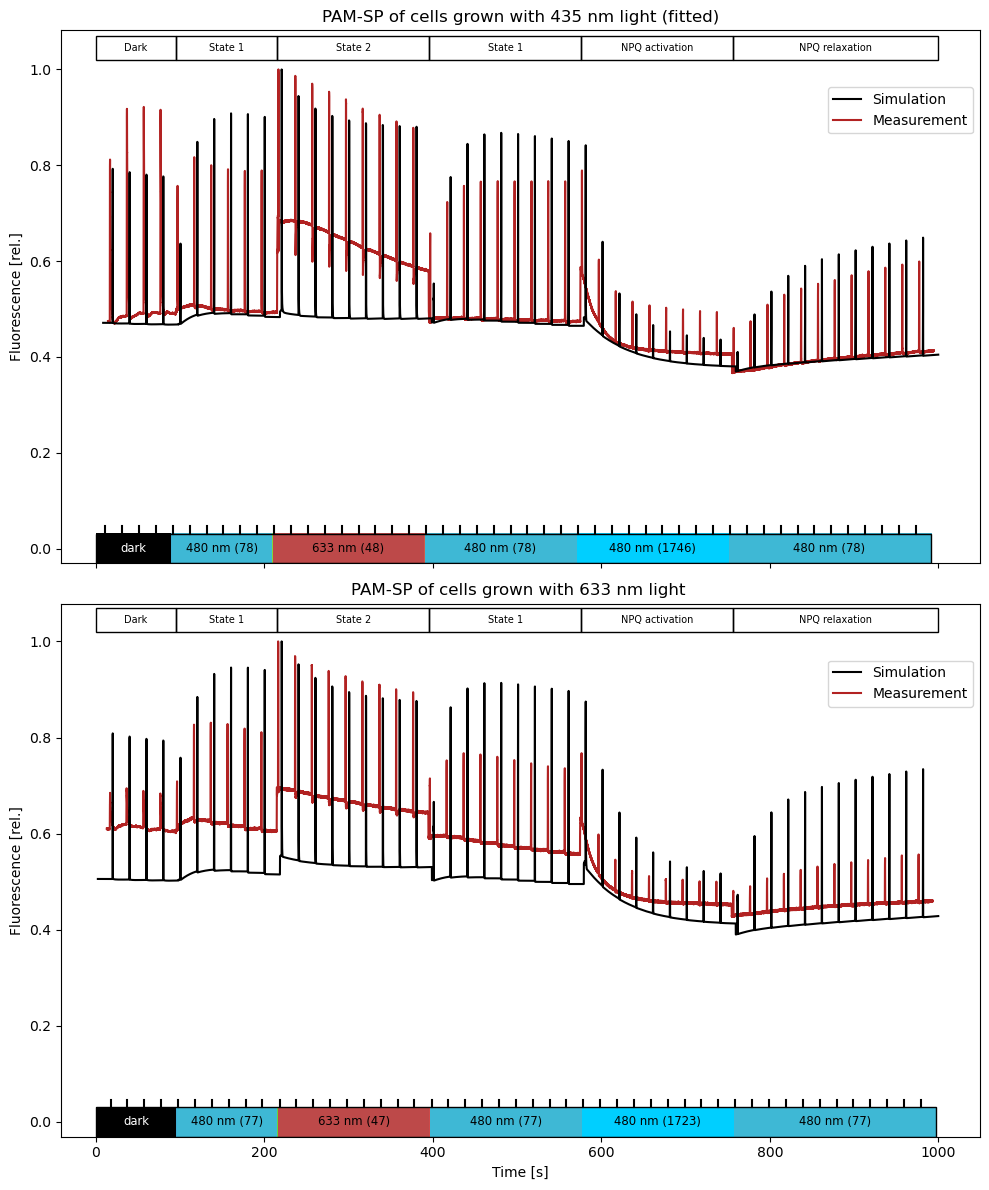

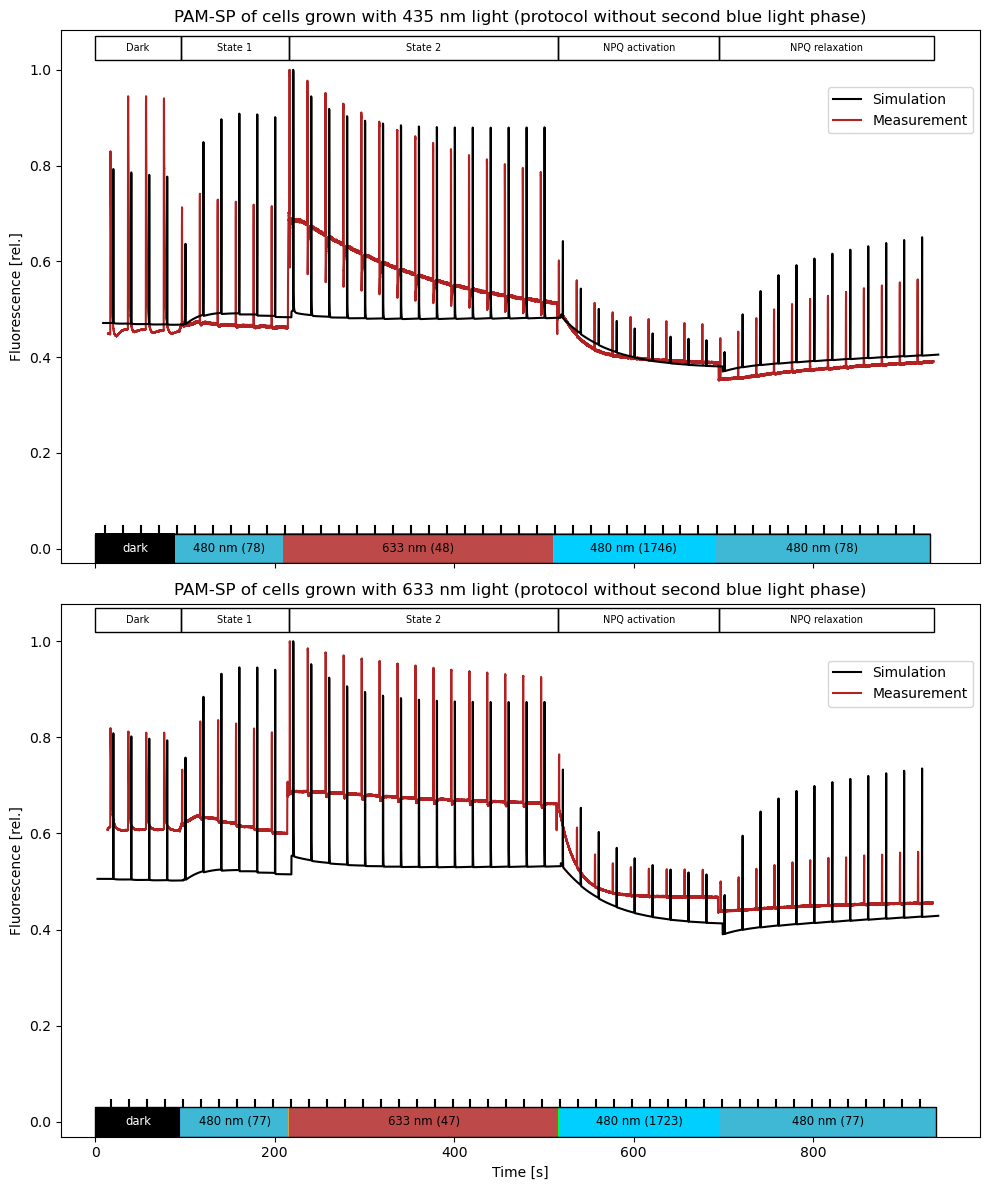

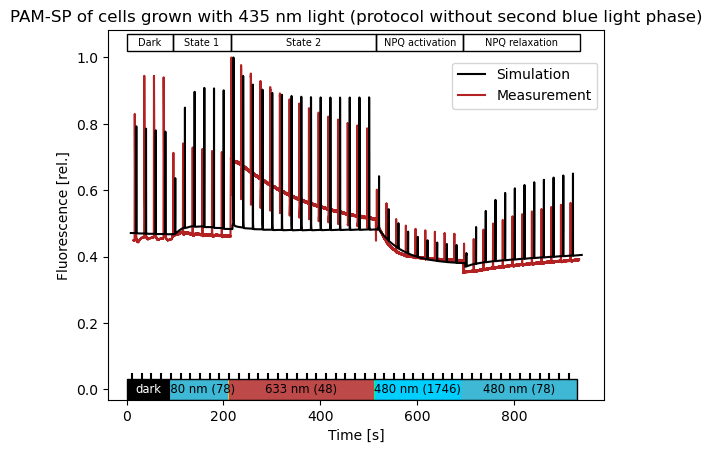

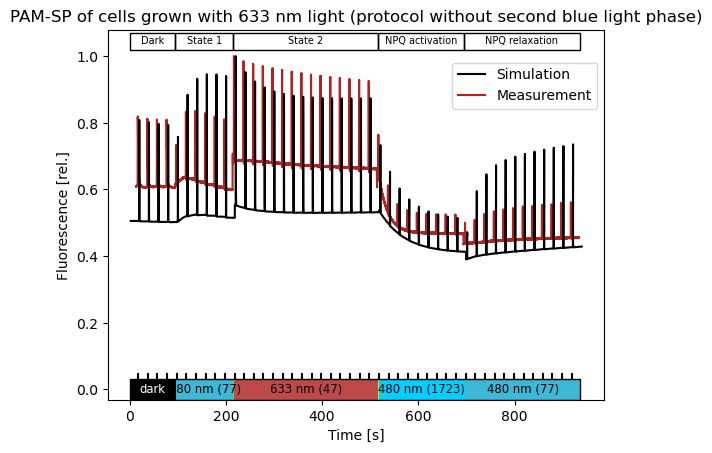

In [57]:
if settings["PAM_blue_light"]["plot"]:
    combined_plots = {
        "state_1":['PSII kinetics, NPQ at state 1_435', 'PSII kinetics, NPQ at state 1_633'],
        "state_2":['PSII kinetics, NPQ at state 2_435', 'PSII kinetics, NPQ at state 2_633'],
        }
    data_offsets = { # Determine the first peak and set it to time 18
        x:pamdata[x].index[pamdata[x].loc[:20,"F"].argmax()] - 17 for x in pamdata 
    }

    for key_comp, meas_comb in combined_plots.items():
        fig_comb, axes_comb = plt.subplots(2,1, figsize=(10,12), sharex=True)
        # fig_det, axes_det = plt.subplots(2,1, figsize=(20,12), sharex=True)
        for meas_select in meas_comb:
            if meas_select in sims.keys():
                s4 = sims[meas_select]

                if meas_select == 'PSII kinetics, NPQ at state 1_435':
                    fig = paper_figs["fig2"]["subs"]["A"]
                    _ax = fig.subplots()
                elif meas_select == 'PSII kinetics, NPQ at state 1_633':
                    fig = paper_figs["figS3"]["main"]
                    _ax = fig.subplots()
                else:
                    fig, _ax = plt.subplots()
                
                axes = [_ax, axes_comb[meas_comb.index(meas_select)]]

                for i,ax in enumerate(axes):
                    fig, ax = plot_model_and_data(s4, pamdata[meas_select].iloc[:,:2], pulse_pfdm4 * 0.95, ax=ax, annotation_twoline=False, data_offset=data_offsets[meas_select])

                    # Set the title
                    title_suffix = ""

                    if meas_select == 'PSII kinetics, NPQ at state 1_435':
                        title_suffix += "(fitted)"

                    if meas_select.split("_")[0] == 'PSII kinetics, NPQ at state 2':
                        title_suffix += "(protocol without second blue light phase)" #", Light Protocol "
                        ax = add_phaseboxes_noNPQ(ax)
                    else:
                        ax = add_phaseboxes_NPQ(ax)

                    ax.set_title(f"PAM-SP of cells grown with {meas_select.split('_')[1]} nm light {title_suffix}")

                    # if i == 0:
                    #     fig.set_size_inches(15,4)
                        # fnc.savefig_dated(fig, f"pamspplot_{meas_select[15:]}", type=plot_format, path=figure_path, bbox_inches="tight")

                # # Plot the redox state and CBB redox activation
                # ax = axes_det[meas_comb.index(meas_select)]
                # _s4 = fnc.remove_beginning_from_simulation(s4, 300)
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["Q_red"]/_s4.model.parameters["Q_tot"], label="Reduced PQ fraction")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["PSIIq"]/_s4.model.parameters["PSIItot"], label="State transition activity")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["CBBa"], label="CBB redox activation")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["OCP"], label="OCP activity")

                # ax = fnc.add_lightbar(_s4, ax, 1800, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)

                # ax.legend()

                # ax.set_title(f"Detailed analysis of PAM-SP of cells grown with {meas_select.split('_')[1]} nm light {title_suffix}")
                # fig_det.tight_layout()


            axes_comb[0].set_xlabel(None)
            fig_comb.tight_layout()
            # fig.set_size_inches(15,7)


            fnc.savefig_dated(fig_comb, f"pamspplot_combined_{key_comp}", type=plot_format, path=figure_path, bbox_inches="tight")


## Simulate all wavelengths (Figure 2b)

In [58]:
def simulate_adapted_strain_pam(growthlight, strain_params, fit_param, absorption_coef, pulse_pfd, meas_select):
    print(f"{growthlight}: started")
    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model(check_consistency=False, reduced_size=False, verbose=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Temporarily adapt parameters
    m4.update_parameters(fit_param)

    # Simulate the appropriate protocol
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfd, blue_wl=480)
    )
    if meas_select.startswith("PSI+PSII kinetics"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
    print(f"{growthlight}: finished")

    return fnc._convert_Simulator_for_save(s4, save_full_results=True)

In [59]:
if settings["PAM_all_lights"]["recalculate"]:
    # Simulate PAM traces for all adapted strains with the above fit parameters
    wavelengths = [x for x in strain_params.keys() if x != "596"]

    _simulate_adapted_strain_pam = partial(
        simulate_adapted_strain_pam,
        strain_params=strain_params,
        fit_param={},
        absorption_coef=absorption_coef,
        pulse_pfd=pulse_pfdm4,
        meas_select=meas_select
    )
    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
            res = list(map(_simulate_adapted_strain_pam, wavelengths))
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            res = list(pe.map(_simulate_adapted_strain_pam, wavelengths))
    sims = {k:fnc._create_Simulator_for_load(v) for k,v in zip(wavelengths, res)}
    fnc.save_Simulator_dated(sims, "adapted_strain_pam", results_path, save_full_results=True)

In [60]:
if settings["PAM_all_lights"]["plot"]:
    # Plot the PAM simulations
    sims = fnc.load_Simulator_dated("adapted_strain_pam", results_path)

    fig = paper_figs["fig2"]["subs"]["B"]
    axes = fig.subplots(2,4, sharey=True, sharex=True)

    sims = {k:fnc.remove_beginning_from_simulation(s, 300) for k,s in sims.items()}

    for ax, (i,s) in zip(axes.flatten(), sims.items()):
        try:
            ax.plot(s.get_full_results_df().loc[:,"Fluo"], c=fnc.wavelength_to_rgb(int(i)))
        except:
            pass
        ax.text(0.95, 0.95, f"{i} nm", size=15, ha="right", va="top", transform=ax.transAxes)
    ax.set_ylim(ymin=0)
        
    for ax, (i,s) in zip(axes.flatten(), sims.items()):
        ax = fnc.add_lightbar(s, ax, 2000, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, y_pos=0, annotation=True, annotation_twoline=True, annotation_size=4.5)

    for j in range(4):
        axes[-1,j].set_xlabel("Time [s]")
    for j in range(2):
        axes[j,0].set_ylabel("Fluorescence [AU]")

    # fig.tight_layout()
    # fnc.savefig_dated(fig, "adapted_strain_pam", type=plot_format, path=figure_path)

## Blue light NPQ experiment

<AxesSubplot: xlabel='Time'>

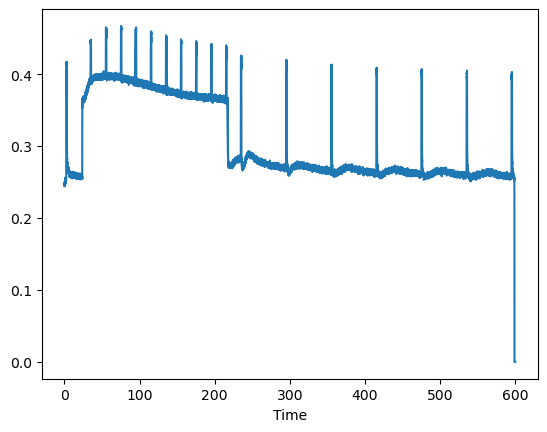

In [61]:
# Get a blue light meausrment from before
df = pd.read_csv("../Code/data/PAM_strong_light_phases/MCPAM_Cyst2_NPQ_Blue.csv", sep=";", index_col=0)["F"]
df.plot()

In [62]:
intensity_factor = 0.5

dark = lip.light_spectra("solar",)
blue = lip.light_gaussianLED(440, 700 * intensity_factor)
pulse_blue = lip.light_gaussianLED(440, 15000 * intensity_factor)

In [63]:
protocol = fnc.create_protocol_PAM(
    init=300,
    actinic=(dark, 0),  # Actinic light intensity and duration
    saturating=(
        pulse_blue,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=1,
    first_actinic_time=1,
    final_actinic_time=19,
)

protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(blue, 20),  # Actinic light intensity and duration
    saturating=(
        pulse_blue,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
)

protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 60),  # Actinic light intensity and duration
    saturating=(
        pulse_blue,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=20,
    final_actinic_time=2,
)

In [64]:
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameters(strain_params["435"]["params"])

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


(280.0, 1149.3300000000004)

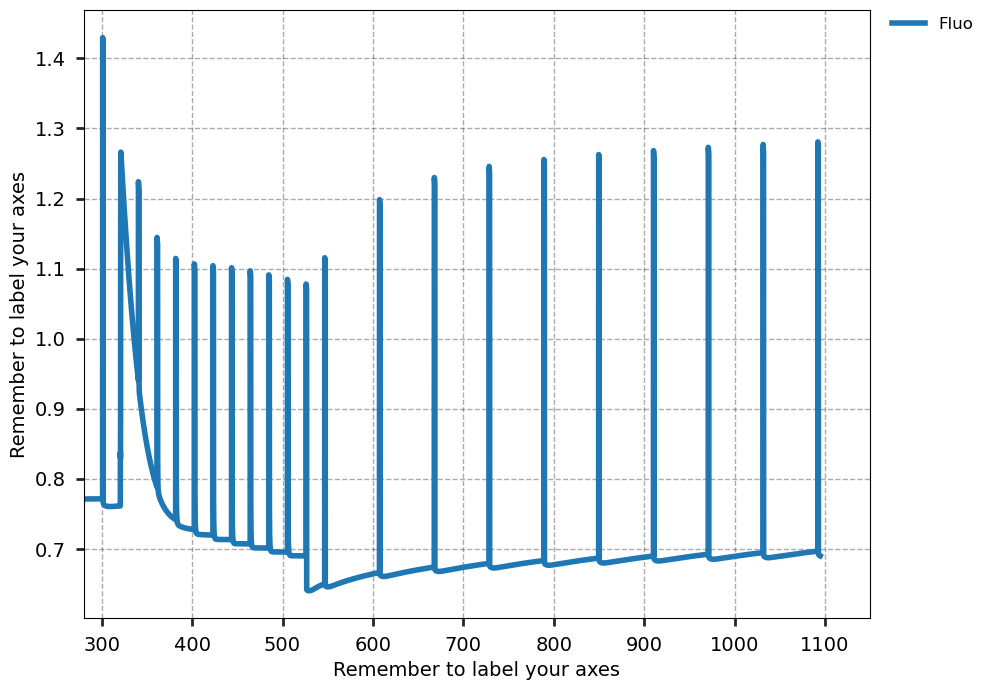

In [65]:
fig, ax = s.plot_selection("Fluo")
ax.set_xlim(280)

## White light NPQ experiment

In [66]:
# Get a blue light meausrment from before
df = pd.read_csv("../Code/data/PAM_strong_light_phases/Cyst1_Fig3_10s.csv", sep=";", index_col=0).loc[:,["F"]]

In [67]:
dark = lip.light_spectra("solar", 0.1)
fr = lip.light_gaussianLED(725,700, 10000)
white = lip.light_spectra("cool_white_led", 500)
pulse = lip.light_spectra("cool_white_led", 15000)

In [68]:
# Protocol of the validation experiment
protocol = fnc.create_protocol_const(
    light=dark,
    time=300
)

# FR oxidation
protocol = fnc.create_protocol_const(
    init=protocol,
    light=fr,
    time=5
)

protocol = fnc.create_protocol_const(
    init=protocol,
    light=dark,
    time=1
)

# Initial determination of Fm
protocol = fnc.create_protocol_const(
    init=protocol,
    light=pulse,
    time=0.6
)

protocol = fnc.create_protocol_const(
    init=protocol,
    light=dark,
    time=10
)

# Light phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(white, 60),  # Actinic light intensity and duration
    saturating=(
        pulse,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=11,
    first_actinic_time=59,
    final_actinic_time=1
)

# Dark phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 60),  # Actinic light intensity and duration
    saturating=(
        pulse,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=7,
    final_actinic_time=10
)

# FR oxidation
protocol = fnc.create_protocol_const(
    init=protocol,
    light=fr,
    time=10
)

protocol = fnc.create_protocol_const(
    init=protocol,
    light=pulse,
    time=0.6
)



In [69]:
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameters({
    "PBS_free": 0.1,  # [unitless] fraction of unbound PBS (guess)
    "PBS_PS1": 0.4,  # [unitless] fraction of PBS bound to PS1 (Tian2011)
    "PBS_PS2": 0.5,  # [unitless] fraction of PBS bound to PS2 (Tian2011)
})

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


Text(0.5, 1.0, '10% detached PBS')

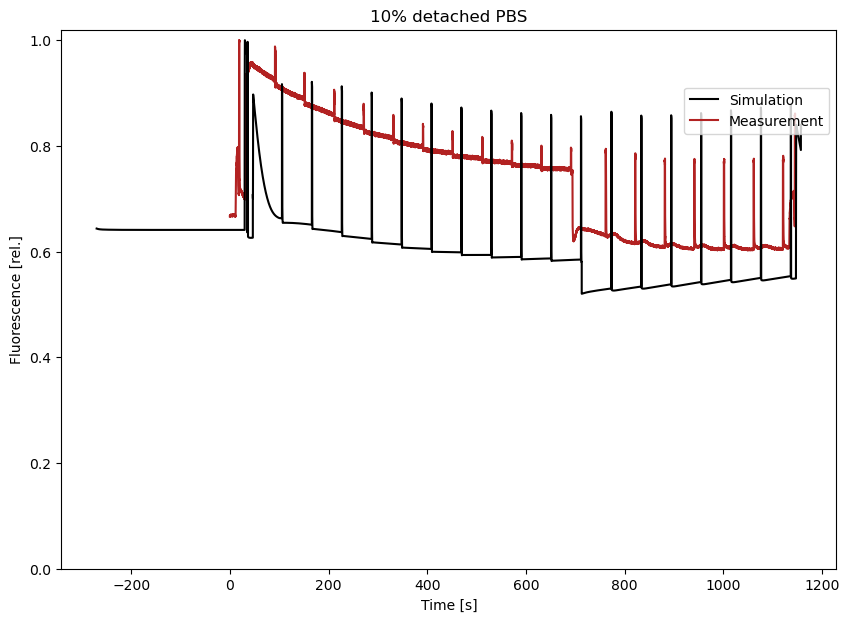

In [70]:
fig, ax = _plot_model_and_data(s, df.loc[:1147], 270)
# s_trim = fnc.remove_beginning_from_simulation(s, 290)
# fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.set_title("10% detached PBS")

## Validation PAM experiment

In [71]:
df = pd.read_csv(Path("../Code/data/PAM_validation_Zavrel2024.csv"), index_col=[0], header=[0,1,2])
idx = pd.IndexSlice

In [72]:
# Protocol of the validation experiment
dark, low_blue, high_blue, orange, pulse_orange, pulse_blue = make_lights(
    blueInt=80,
    orangeInt=50,
    highblueInt=1800,
    pulseInt=15000,
    orange_wl=625,
    blue_wl=440,
)
pulse_white = lip.light_spectra("cool_white_led", 15000)


# Dark acclimation
protocol = fnc.create_protocol_const(
    light=dark,
    time=300
)

# Dark phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=4,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Orange phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(orange, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=25,
    final_actinic_time=5,
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# High blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(high_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Simulate the validation experiment
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

# The culture is grown under 1% CO2
s.update_parameter("CO2ext_pp", 0.01)

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


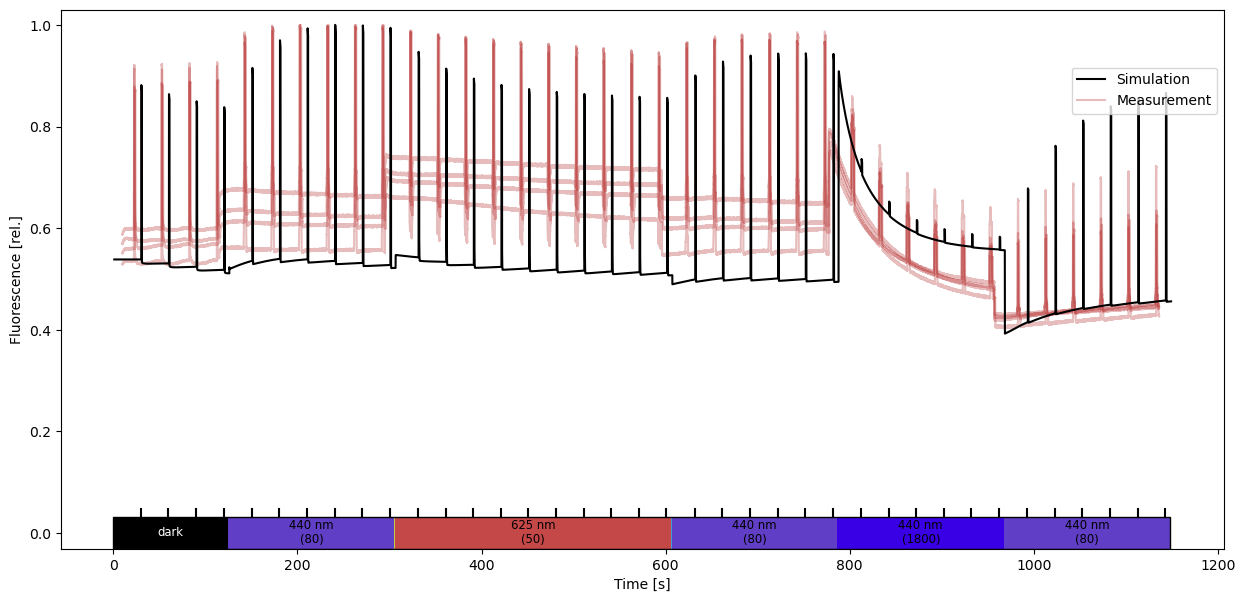

In [73]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)

fig,ax= plt.subplots(figsize=(15,7))
dat = df.loc[:1126,idx["25", "white",:]]
dat_line = ax.plot(dat.index.to_numpy() + 10, dat.values, c="firebrick", label="Measurement", alpha=0.3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Fluorescence [rel.]")
ax.set_ylim(ymin=0)

# Plot the simulation on top
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = ax.plot(_s.get_time(), fluo_norm, c="black", label="Simulation")

handles = sim_line + [dat_line[0]]

ax.legend(
    handles = handles,
    loc="center right",
    bbox_to_anchor = (1,0.85)
)

ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.set_title("")
fnc.savefig_dated(fig, f"pamspplot_validation_singleplot", type=plot_format, path=figure_path, bbox_inches="tight")

In [74]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)

fig = paper_figs["fig2"]["subs"]["C"]
axes= fig.subplots(1,2)
dat = df.loc[:1126,idx["25", "white",:]]

colors = mpl.colormaps["Reds"](np.linspace(0.5,1,len(dat.columns)))
for i in range(len(dat.columns)):   
    dat_line = axes[0].plot(dat.index.to_numpy() + 10, dat.iloc[:,i], c=colors[i], label="Measurement")
axes[0].set_ylabel("Fluorescence [rel.]")
axes[0].set_title("Measurement (four replicates)")


# Plot the simulation on the side
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = axes[1].plot(_s.get_time(), fluo_norm, c="black", label="Simulation")
axes[1].set_title("Simulation")

for ax in axes:
    ax.set_xlabel("Time [s]")
    ax.set_ylim(ymin=0)
    ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)
    
    
    # Add phaseboxes
    ax = add_phasebox(ax, 0, 125, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 125, 305, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 305, 605, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 605, 785, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 785, 965, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 965, 1145, "NPQ relaxation", 0.05, 1.02)

# Share the y axis
axes[0].sharey(axes[1])
# axes[1].set_yticklabels([])

# fig.tight_layout()
# fnc.savefig_dated(fig, f"pamspplot_validation_dualplot", type=plot_format, path=figure_path, bbox_inches="tight")

### Determine and plot NPQ

In [75]:
# Functions for determining Fm's
def get_best_peak(x, t_SP, **kwargs):
    """Get the best peaks height according to prominence.
    If none is found, return -1.

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    peaks = find_peaks(x, **kwargs)
    if len(peaks[0]) == 0:
        pos = None
    elif len(peaks[0]) == 1:
        if np.isnan(peaks[0][0]):
            pos = None
        else:
            pos = int(peaks[0][0])
    else:
        pos = int(peaks[0][np.argmax(peaks[1]["prominences"])])

    xmax = x.max()
    if pos is None:
        if ((x.loc[t_SP] - xmax) / xmax ) > 0.05:
            warn("strong deviance from max (> 5%)")
        return (-1, x.loc[t_SP])
    else:
        if ((x.iloc[pos] - xmax) / xmax ) > 0.05:
            warn("strong deviance from max (> 5%)")
        return (x.index[pos], x.iloc[pos])
    
def calculate_NPQ_PhiPSII(peaks, F0s, set_Fm_one=False):
    if not set_Fm_one:
        Fms = peaks.iloc[0,:]
        Fmps = peaks.iloc[1:,:]
    else:
        Fms=1
        Fmps = peaks

    # Get NPQ = (Fm - Fm') / Fm'
    NPQ = (Fms -Fmps) / Fmps

    # Get PhiPSII
    PhiPSII = (Fmps - F0s) / Fmps

    return NPQ, PhiPSII


In [76]:
def calculate_NPQ_PhiPSII_simulation(s, SP_pfd):
    pulses = [simpson(x["pfd"]) >= SP_pfd for x in s.simulation_parameters]
    pulse_time_ranges = [(s.time[x][0], s.time[x][-1]) for x in range(len(s.time)) if pulses[x]]

    fluo = s.get_full_results_df()["Fluo"]
    fluo = fluo/fluo.max()

    Fmps = pd.Series([fluo.loc[x[0]:x[1]].max() for x in pulse_time_ranges], index=[x[0] for x in pulse_time_ranges])

    F0 = fluo.loc[0:1].mean()

    # Get NPQ = (Fm - Fm') / Fm'
    NPQ = (1 - Fmps) / Fmps

    # Get PhiPSII
    PhiPSII = (Fmps - F0) / Fmps

    return NPQ, PhiPSII

In [77]:
# Determine NPQ and PhiPSII for the simulation
NPQ,PhiPSII = calculate_NPQ_PhiPSII_simulation(_s, SP_pfd=15000 * 0.95)

In [78]:
# Determine the F0s
F0s = dat.loc[9:10, :].mean()

# Determine the peak heights

# Set the approximate timing of the peaks
Fmp_timings = np.arange(13, 1130, 30)

# Set the range in which peaks should be searched for
peak_find_range = np.array([-5, +5])

peaks = pd.DataFrame(
    np.nan,
    index=Fmp_timings,
    columns=dat.columns)
peak_times=peaks.copy()

for i, t_SP in enumerate(Fmp_timings):
    _peak = (dat
    .ffill(axis=0) # remove NAs            
    .apply(savgol_filter, window_length=10, polyorder=2) # Smooth the signal
    .loc[slice(*(t_SP+peak_find_range)), :]
    .apply(get_best_peak, t_SP=t_SP, width=15, prominence=0.005, axis=0) # plateau_size=10,
    ) # Find peaks
    peak_times.loc[t_SP,:] = _peak.iloc[0,:].to_numpy()
    peaks.loc[t_SP,:] = _peak.iloc[1,:].to_numpy()


NPQ_dat, PhiPSII_dat = calculate_NPQ_PhiPSII(peaks, F0s, set_Fm_one=True)

# Calculate mean and sd
NPQ_dat.loc[:,"mean"] = NPQ_dat.mean(axis=1)
NPQ_dat.loc[:,"sd"] = NPQ_dat.std(axis=1)

PhiPSII_dat.loc[:,"mean"] = PhiPSII_dat.mean(axis=1)
PhiPSII_dat.loc[:,"sd"] = PhiPSII_dat.std(axis=1)

In [79]:
# Simulate all
def get_pathways_at_lights(model, y0, lights, intens):
    sims = []
    for i, light in zip(intens, lights):
        m = model.copy()
        m.update_parameter("pfd", light)

        # Prepare for ss simulation
        exch_dict = {
            "3PGA": {"k": 10, "thresh": 1000},
            # "PG": {"k": 10, "thresh": 1},
        }
        m =fnc.add_exchange(m, exch_dict)

        s = Simulator(m)
        s.initialise(y0)
        # t,y = s.simulate(10000)
        # t,y = s.simulate_to_steady_state(tolerance=1e-2)
        s,t,y = simulate_to_steady_state_custom(s,        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])

        if t is None:
            raise RuntimeError(f"simulation failed for i={i:.2f}")
        else:
            sims.append(s)

    # Get the electron pathways
    pathways = pd.DataFrame({i:pd.DataFrame(fnc.get_ss_electron_pathways(s)).iloc[-1,:] for s,i in zip(sims, intens)}).T
    return pathways, sims

def get_model_simulator(model, y0, light):
    m = model.copy()
    m.update_parameter("pfd", light)

    # Prepare for ss simulation
    exch_dict = {
        "3PGA": {"k": 10, "thresh": 1000},
    }
    m =fnc.add_exchange(m, exch_dict)

    s = Simulator(m)
    s.initialise(y0)
    return s

Text(0.5, 1.0, 'NPQ')

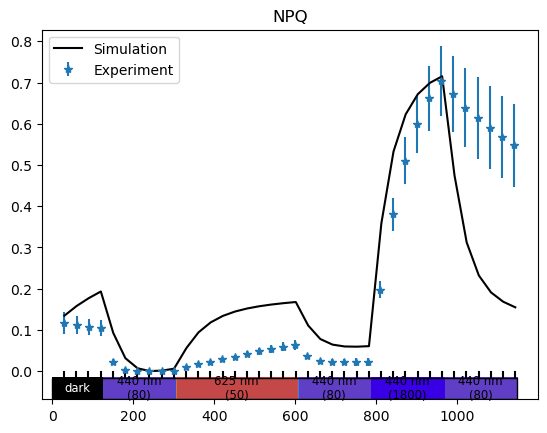

In [80]:
fig,ax = plt.subplots()
time_align = NPQ_dat.index[0] - NPQ.index[0]
ax.errorbar(
    x = NPQ_dat.index.to_numpy() - time_align,
    y = NPQ_dat["mean"],
    yerr = NPQ_dat["sd"], 
    marker="*", ls="", label="Experiment")
ax.plot(NPQ, label="Simulation", c="k")
ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.legend()
ax.set_title("NPQ")

Text(0.5, 1.0, 'Y(II)')

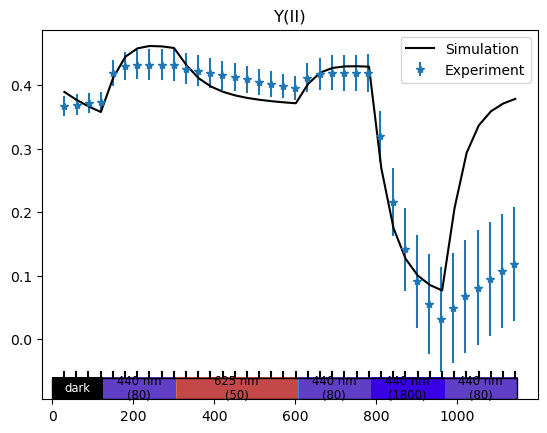

In [81]:
fig,ax = plt.subplots()
time_align = PhiPSII_dat.index[0] - NPQ.index[0]
ax.errorbar(
    x = PhiPSII_dat.index.to_numpy() - time_align,
    y = PhiPSII_dat["mean"],
    yerr = PhiPSII_dat["sd"], 
    marker="*", ls="", label="Experiment")
ax.plot(PhiPSII, label="Simulation", c="k")
ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.legend()
ax.set_title("Y(II)")

### Plot mean

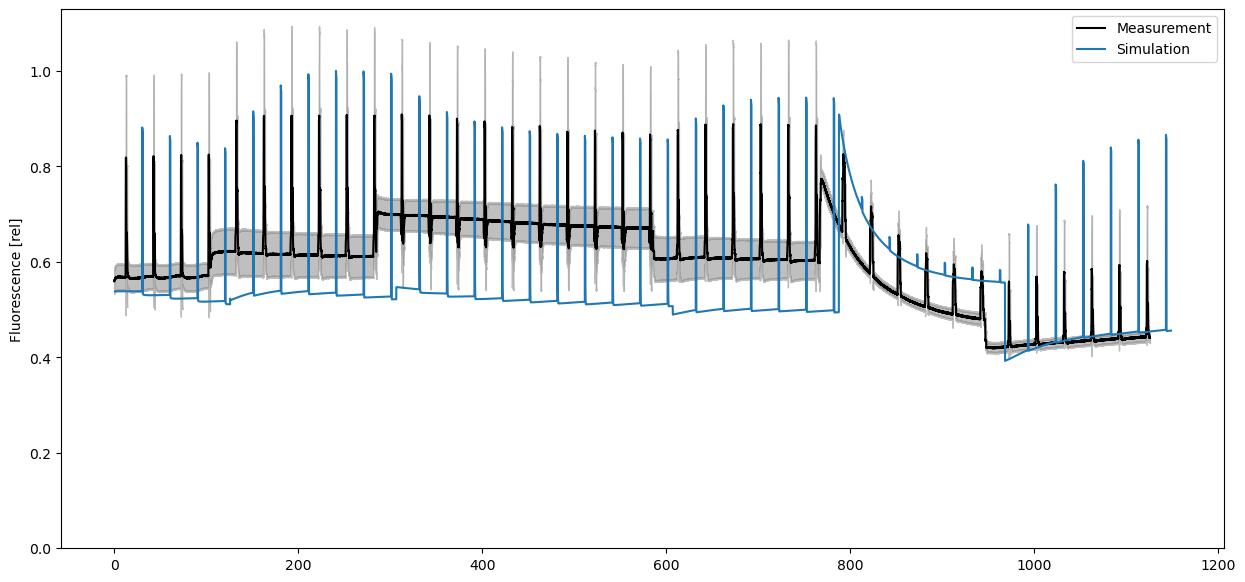

In [82]:
fig, ax = plt.subplots(figsize=(15,7))

fluo_mean = dat.mean(axis=1)
fluo_sd = dat.std(axis=1)

ax.plot(dat.mean(axis=1), c="k", label="Measurement")
ax.fill_between(fluo_mean.index, fluo_mean-fluo_sd, fluo_mean+fluo_sd, color="grey", alpha=0.5)
ax.set_ylabel("Fluorescence [rel]")
ax.set_ylim(0)

ax.plot(_s.get_full_results_df()["Fluo"]/_s.get_full_results_df()["Fluo"].max(), label="Simulation")
ax.legend()

# Electron Pathway and Validation Experiments (Figure 1, 6, & 8)

## Evaluate the electron pathways at different light intensities (Figure 1 & 8)

In [83]:
normToPS1 = True

intens = np.linspace(0.1, 320, int(100 * fraction_simulated_points))
light_source = "Theune2021"
if light_source == "Theune2021":
    lights = [lip.light_gaussianLED(670, i) for i in intens]
else:
    lights = [lip.light_spectra(light_source, i) for i in intens]

# Simulate Wild Type and different mutants
# Standard model
m0, y0 = get_model(check_consistency=False, verbose=False)

# low CO2
mCO2, y0 = get_model(check_consistency=False, verbose=False)
mCO2.update_parameter("CO2ext_pp", 0.0004)

# Flv KO mutant
mFlv, y0 = get_model(check_consistency=False, verbose=False)
mFlv.update_parameter("k_O2", 0)

# Flv KO mutant
mNQ, y0 = get_model(check_consistency=False, verbose=False)
mNQ.update_parameter("k_NQ" if "k_NQ" in mNQ.parameters else "vNQ_max", 0)

models = {"m0":m0, "mCO2":mCO2, "mFlv":mFlv, "mNQ":mNQ}
pathways = {}
sims = {}

if settings["electron_pathways"]["recalculate"]:
    print("\nSIMULATING")
    for key,model in models.items():
        print(key)
        _pathways, _sims = get_pathways_at_lights(model, y0, lights, intens)
        pathways[key] = _pathways
        sims[key] = _sims

        fnc.save_Simulator_dated(_sims, f"epaths_sims_{key}", results_path)
    fnc.save_obj_dated(pathways, "epaths_paths", results_path)

In [84]:
# Create figure 1
fig = plt.figure(constrained_layout=True, figsize=figsize(1, 0.7))
gs = fig.add_gridspec(5)

sfig1 = fig.add_subfigure(gs[:3])
label_figure(sfig1, pos="top left", label="A")
sfig2 = fig.add_subfigure(gs[3:])
label_figure(sfig2, pos="top left", label="B")
label_figure(sfig2, pos="top right", label="C")

paper_figs["fig1"] = {
    "main": fig,
    "subs": {
        "A": sfig1,
        "B": sfig2,
    }
}

<Figure size 1500x1050 with 0 Axes>

In [85]:
if settings["electron_pathways"]["plot"]:
    sims = {key:fnc.load_Simulator_dated(f"epaths_sims_{key}", results_path) for key in models}
    pathways = fnc.load_obj_dated("epaths_paths", results_path)

    # Plot all
    titles = {
        "m0":"WT",
        "mFlv":"$\it{Flv1/3}$",
        "mNQ": "$\it{NDH}$-$\it{1}$",
        "mCO2": "Air CO$_2$"
    }
    
    # Set up a figure with all axes shared but the last one
    fig = paper_figs["fig1"]["subs"]["B"]
    axes = np.full(len(titles)+1,0, dtype=object)
    axes[0] = fig.add_subplot(1,len(titles)+1,1)
    for i in range(2,len(titles)+2):
        axes[i-1] = fig.add_subplot(1,len(titles)+1,i, sharey=(axes[0] if i!=5 else None))

    # fig.set_size_inches(12,3.5)

    # Line Plot
    for (key, ptw), ax in zip(pathways.items(), axes):
        norm = m0.get_parameter("PSItot") *3 if normToPS1 else 1 # Normalise to PS1 monomers
        ptw_norm = ptw / norm
        vps2 = pd.Series([s.get_fluxes_df().loc[:,"vPS2"].iloc[-1] for s in sims[key]], index=intens) * 2 / norm

        lin = ax.plot(ptw_norm)
        lin2 = ax.plot(vps2, c="k", label = "PS2 flux")

    for (key, ptw), ax in zip(pathways.items(), axes):
        ax.text(0, ax.get_ylim()[1]*0.93, titles[key] + (" (fitted)" if key == "m0" else ""))

    if normToPS1:
        axes[0].set_ylabel("Pathway electron flux [e$^-$ PSI$^{-1}$ s$^{-1}$)]")
    else:
        axes[0].set_ylabel("Pathway electron flux [mmol(e$^-$) mol(Chl)$^{-1}$ s$^{-1}$)]")

    axes[2].set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    axes[2].legend(
            handles=lin2 + lin,
            labels=["Flux from PSII", "Linear", "Alternate", "Cyclic", "Respiratory"], 
            loc="center",
            bbox_to_anchor= (0.5, 1.07),
            borderaxespad= 0,
            ncol=5
            )
    
    # Calculate mean pathway usage
    pathway_mean = {}
    pathway_sd = {}

    for mdl in pathways.keys():
        pathway_mean[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.mean(axis=0)
        pathway_sd[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.std(axis=0)

    pathway_mean = pd.DataFrame(pathway_mean)
    pathway_sd = pd.DataFrame(pathway_sd)

    # Create a container for the y errors
    yerr = [[row, row] for i,row in pathway_sd.iterrows()]

    pathway_mean.T.plot.bar(stacked=True, yerr=yerr, ax=axes[-1])
    
    # Remove the legend
    axes[-1].get_legend().remove()

    # Set the y axis to the right
    axes[-1].yaxis.set_label_position("right")
    axes[-1].yaxis.tick_right()
    axes[-1].set_ylabel("Proportion of total electron flux at\nlight > 10 µmol(Photons) m$^{-2}$ s$^{-1}$ [rel.]")

    axes[-1].set_xticklabels([titles[x] for x in pathway_mean.columns], rotation=30, ha="right", rotation_mode='anchor')

    # fig.tight_layout()
    # fnc.savefig_dated(fig, f"electronpaths-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

    
    # for mdl in pathways.keys():
    #     # Relative pathway fractions
    #     fig, ax = plt.subplots()

    #     (pathways[mdl].T / pathways[mdl].sum(axis=1)).T.plot(ax=ax)
    #     ax.set_ylabel("Proportion of total electron flux [rel.]")
    #     ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    #     ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

    #     fnc.savefig_dated(fig, f"electronpaths-{light_source}{mdl}_rel", type=plot_format, path=figure_path, bbox_inches="tight")

    # # Relative pathway fractions (single plot)
    # fig, ax = plt.subplots(figsize=(5,5))
    # pathway_mean.T.plot.bar(stacked=False, yerr=yerr, ax=ax)
    # ax.set_ylabel("Proportion of total electron flux [rel.]")

    # fig.suptitle("Relative electron pathway amounts (I>10 µmol(Photons) m$^{-2}$ s$^{-1}$)")

    # fnc.savefig_dated(fig, f"electronpaths-{light_source}_relbar", type=plot_format, path=figure_path, bbox_inches="tight")


    # Detailed analysis
    allpHs = {}
    allcomps = {}
    allvs = {}
    # allKeqs = {}

    for mdl in sims:
        index = intens
        pHs = pd.DataFrame(columns =["pHlumen", "pHcytoplasm"])
        comps = pd.DataFrame(columns =["ATP", "NADPH", "Q_red", "Fd_red"])
        vs =  pd.DataFrame(columns =["vATPsynthase", "vNQ", "vCBB"])

        for i,s in enumerate(sims[mdl]):
            pHs.loc[index[i],:] = s.get_full_results_df()[pHs.columns].iloc[-1]
            comps.loc[index[i],:] = s.get_full_results_df()[comps.columns].iloc[-1] / np.array([s.model.get_parameter(x) for x in ["AP_tot", "NADP_tot", "Q_tot","Fd_tot"]])
            vs.loc[index[i],:] = s.get_fluxes_df()[vs.columns].iloc[-1]    

        allpHs[mdl] = pHs
        allcomps[mdl] = comps
        allvs[mdl] = vs
    
    # Plot of in depth analysis
    fig = paper_figs["figS8"]["main"]
    axes = fig.subplots(3,4, sharey="row", sharex=True)
    for (k,v), ax in zip(allcomps.items(), axes[0,:]):
        lin0 = ax.plot(v, label=list(["ATP", "NADPH", "PQ$_{red}$", "Fd$_{red}$"]))
        ax.set_title(titles[k])
        ax.set_ylim(0,1.05)
    for (k,v), ax in zip(allpHs.items(), axes[1,:]):
        lin1 = ax.plot(v, label=list(["Lumen","Cytoplasm"]))
    for i, ((k,v), ax) in enumerate(zip(allvs.items(), axes[2,:])):
        lin21 = ax.plot(v.iloc[:,:-1], label=["ATP synthase", "NDH-1"])
        ax2 = ax.twinx()
        lin22= ax2.plot(v["vCBB"], label="CBB", c=mpl.colormaps["tab10"](2))
        if i>0:
            ax2.sharey(_ax2)
        if i<2:
            ax2.tick_params(labelright=False)
        _ax2 = ax2
        

    axes[0,0].set_ylabel("Fraction of total pool")
    axes[1,0].set_ylabel("pH")
    axes[2,0].set_ylabel("Flux [mmol mol(Chl)$^{-1}$ s$^{-1}$]")
    fig.text(0.4,0,"Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center",va="center")
    ax2.set_ylabel("CBB Flux[mmol mol(Chl)$^{-1}$ s$^{-1}$]")

    for i, lin in zip(range(axes.shape[0]), [lin0, lin1, lin21+lin22]):
        y = 1.04 if i < 2 else 1.33 # 1.1
        axes[i,-1].legend(handles=lin,bbox_to_anchor=(y,1), loc="upper left")

    # fig.tight_layout()
    # fnc.savefig_dated(fig, f"electronpaths_analysis-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

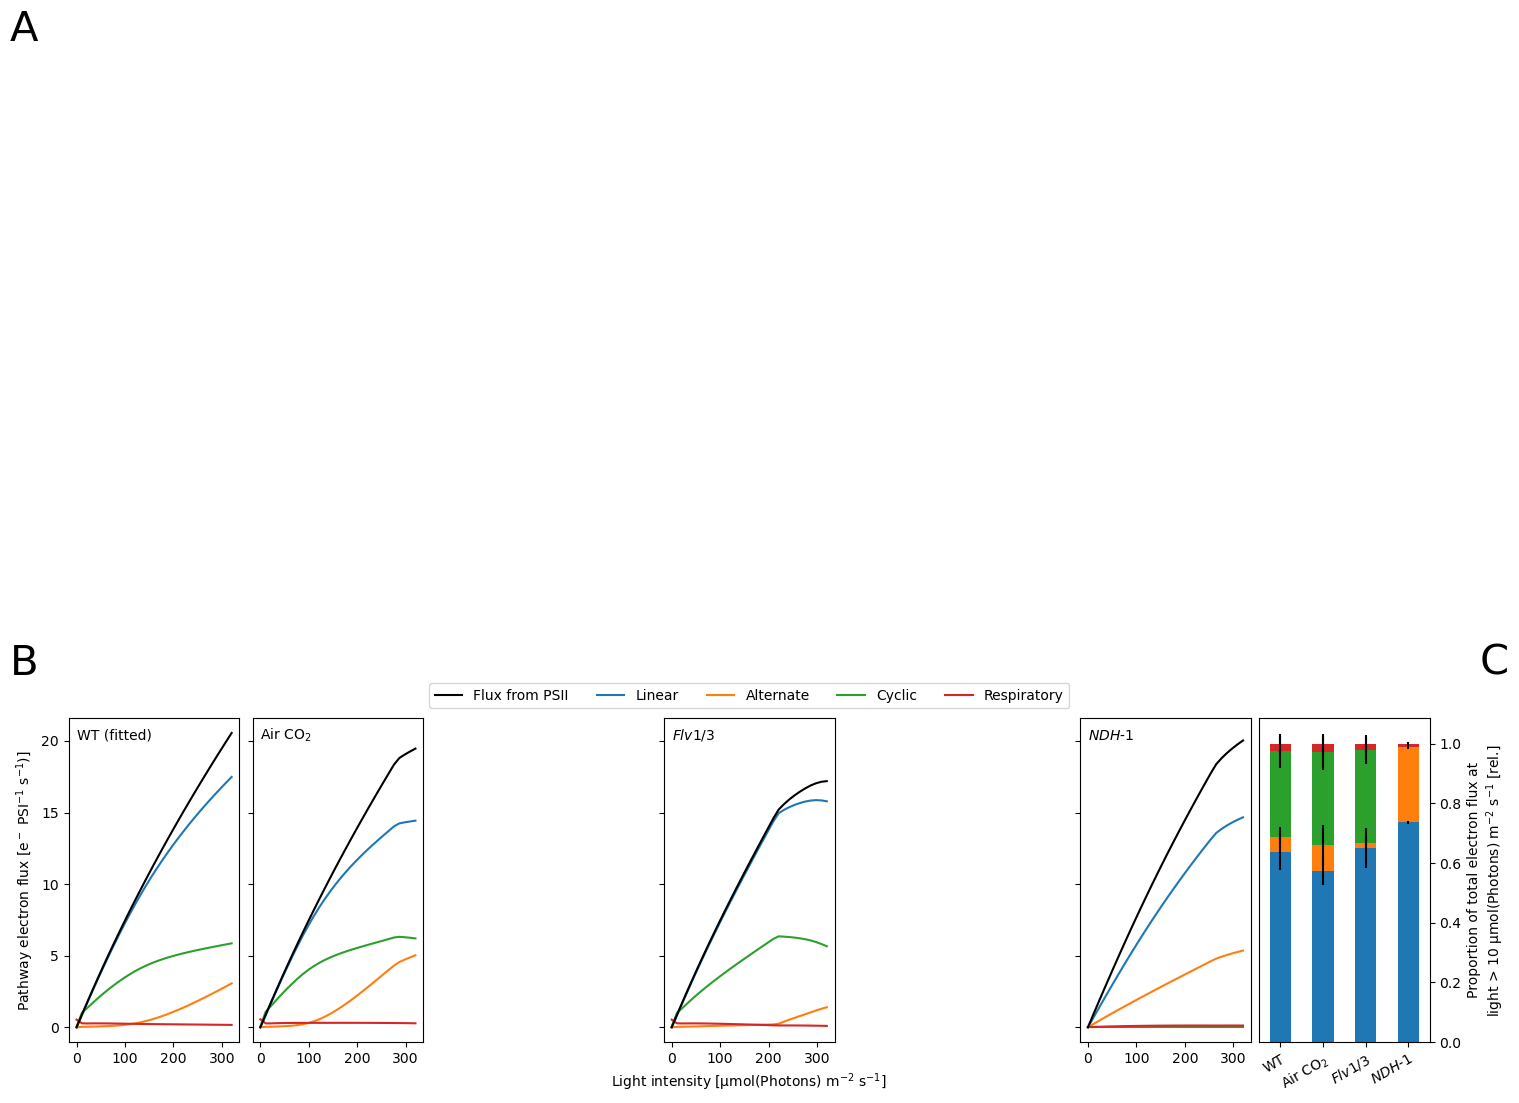

In [86]:
paper_figs["fig1"]["main"]

## Calculate the cell's NPQ approximating fluorescence

In [87]:
# fig = paper_figs["figS7"]["main"]
# axes = fig.subplots(1,4, sharey=True)

# for mdl, ax in zip(sims.keys(), axes.flatten()):
#     OCPs = np.zeros(len(sims[mdl]))
#     NPQs = np.zeros(len(sims[mdl]))
#     YIIs = np.zeros(len(sims[mdl]))
#     Heat = np.zeros(len(sims[mdl]))

#     for i,s in enumerate(sims[mdl]):
#         # Get the necessary dynamic variables and parameters
#         OCP, B0, B1, B2, B3, PSIIq  = list(s.get_full_results_df().loc[:,["OCP", "B0", "B1", "B2", "B3", "PSIIq"]].to_numpy().flatten())
#         kH0, kHst, kF, k2, PSIItot = [s.model.get_parameter(x) for x in ["kH0", "kHst", "kF", "k2", "PSIItot"]]

#         kH = kH0 + kHst * (PSIIq / PSIItot)

#         # Calculate the approximate fluorescence levels with old definition
#         Fm = (kF / (kH0 + kF)) * PSIItot
#         Fmp = (kF / (kH + kF)) * PSIItot
#         Ft = (kF / (kH + kF + k2)) * B0 + (kF / (kH + kF)) * B2

#         # Fluorescence-like NPQ (Fm - Fm') / Fm'
#         NPQs[i] = (Fm - Fmp) / Fmp

#         # Fluorescence-like Y(II) (Fm' - Ft) / Fm'
#         YIIs[i] = (Fmp - Ft) / Fmp

#         # Heat quenching
#         Heat[i] = (kH) / (kH + kF + k2) * (B1 / (B1 + B3)) + (kH) / (kH + kF) * (B3 / (B1 + B3))

#     ax.plot(intens, NPQs, label="NPQ")
#     ax.plot(intens, YIIs, label="Y(II)")
#     ax.plot(intens, Heat, label="Total heat quenching")
#     # ax.plot(intens, OCPs, label="OCP")

# ax.set_ylim(0, ax.get_ylim()[1]*1.05)

# fig.tight_layout()

# ax2 = ax.secondary_yaxis(location="right")
# ax2.set_ylabel("Fraction of excitations quenched as heat [rel]")
# axes[0].set_ylabel("NPQ or Y(II)")
# axes[1].legend( 
#         loc="center",
#         bbox_to_anchor= (1.1, 1.05),
#         borderaxespad= 0,
#         ncol=5
#         )

# fig.text(x=0.5, y=0, s="Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center", va="center")

# for mdl, ax in zip(sims.keys(), axes.flatten()):
#     ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

# # fnc.savefig_dated(fig, f"electronpaths_processes-Theune2021_approx", type=plot_format, path=figure_path, bbox_inches="tight")


## Calculate the cell's NPQ, simulating fluorescence

In [88]:
fig = paper_figs["figS7"]["main"]
axes = fig.subplots(1,4, sharey=True)

for mdl, ax in zip(sims.keys(), axes.flatten()):
    OCPs = np.zeros(len(sims[mdl]))
    NPQs = np.zeros(len(sims[mdl]))
    YIIs = np.zeros(len(sims[mdl]))
    Heat = np.zeros(len(sims[mdl]))

    # Get Fm as the SP after a FR light phase
    _s = Simulator(models[mdl])
    _s.initialise(y0)
    _s.update_parameter("pfd", lip.light_gaussianLED(700, 50))
    _s.simulate(300)
    _s.update_parameter("pfd", lip.light_gaussianLED(633, 15000))
    _s.simulate(300+0.6)
    Fm = _s.get_full_results_df().loc[300:,"FPS2"].max()

    for i,s in enumerate(sims[mdl]):
        # Get the necessary dynamic variables and parameters
        OCP, B0, B1, B2, B3, PSIIq, Ft  = list(s.get_full_results_df().loc[:,["OCP", "B0", "B1", "B2", "B3", "PSIIq", "FPS2"]].to_numpy().flatten())
        kH0, kHst, kF, k2, PSIItot = [s.model.get_parameter(x) for x in ["kH0", "kHst", "kF", "k2", "PSIItot"]]

        kH = kH0 + kHst * (PSIIq / PSIItot)

        # Simulate the fluorescence with a SP
        _s = s.copy()
        _s.update_parameter("pfd", lip.light_gaussianLED(633, 15000))

        t_end = s.get_time()[-1]
        _s.simulate(t_end+0.6)
        Fmp = _s.get_full_results_df().loc[t_end:,"FPS2"].max()

        # Fluorescence-like NPQ (Fm - Fm') / Fm'
        NPQs[i] = (Fm - Fmp) / Fmp

        # Fluorescence-like Y(II) (Fm' - Ft) / Fm'
        YIIs[i] = (Fmp - Ft) / Fmp

        # Heat quenching
        Heat[i] = (kH) / (kH + kF + k2) * (B1 / (B1 + B3)) + (kH) / (kH + kF) * (B3 / (B1 + B3))

    ax.plot(intens, NPQs, label="NPQ")
    ax.plot(intens, YIIs, label="Y(II)")
    ax.plot(intens, Heat, label="Total heat quenching")
    # ax.plot(intens, OCPs, label="OCP")

ax.set_ylim(0, ax.get_ylim()[1]*1.05)

fig.tight_layout()

ax2 = ax.secondary_yaxis(location="right")
ax2.set_ylabel("Fraction of excitations quenched as heat [rel]")
axes[0].set_ylabel("NPQ or Y(II)")
axes[1].legend( 
        loc="center",
        bbox_to_anchor= (1.1, 1.05),
        borderaxespad= 0,
        ncol=5
        )

fig.text(x=0.5, y=0, s="Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center", va="center")

for mdl, ax in zip(sims.keys(), axes.flatten()):
    ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

# fnc.savefig_dated(fig, f"electronpaths_processes-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")


## Compare Oxygen and CO2 fluxes (Figure 6)

In [89]:
def get_O2andCO2rates(s):
    #  Get O2 and CO2 rates
    rates = {}
    res = {}

    rates["O2"] = fnc.get_stoichiometric_fluxes(s, "O2")
    rates["O2"].pop("vO2out")

    rates["CO2"] = fnc.get_stoichiometric_fluxes(s, "CO2")
    rates["CO2"].pop("vCCM")

    for cmp in ["O2", "CO2"]:
        prod = pd.DataFrame(rates[cmp].copy())
        prod[prod<0] = 0
        res[f"{cmp}_production"] = prod.sum(axis=1, skipna=False)

        cons = pd.DataFrame(rates[cmp].copy())
        cons[prod>0] = 0
        res[f"{cmp}_consumption"] = cons.sum(axis=1, skipna=False)

        res[f"{cmp}_net"] = pd.DataFrame(rates[cmp]).sum(axis=1, skipna=False)
    
    return pd.DataFrame(res)

In [90]:
# Oxygen change rates from Schuurmans2014
O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

In [91]:
# Reference values for plot
# Oxygen change rates from Schuurmans2014
O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

# Define the lights
intens = np.unique(np.sort(np.concatenate((np.linspace(0, 320, 30), O2_ref.index.to_numpy()))))
lights = [lip.light_gaussianLED(625, i) for i in intens]

# Standard model
m0,y0 = get_model(check_consistency=False, verbose=False)

# Standard model
mlowCO2,y0 = get_model(check_consistency=False, verbose=False)
mlowCO2.update_parameter("CO2ext_pp", 0.0004)

# Adjust the lights to in-culture conditions (2 mg(Chl) l^-1 according to Schuurmans)
MChl = 893.509 # [g mol^-1]
absorption_coef = lip.get_pigment_absorption(m0.parameters["pigment_content"]).sum(axis=1) * MChl
lights = lip.get_mean_sample_light(
    lights, # [µmol(Photons) m^-2 s^-1]
    depth = 0.01,  # [m]
    absorption_coef=absorption_coef,
    chlorophyll_sample=(
        2 # [mg(Chl) l^-1] (Schuurmans2014)
        / MChl # [mol g^-1]
        * 1e3
    ) # [mmol(Chl) m^-3]
)

models = {"m0":m0, "mlowCO2":mlowCO2}
pathways = {}
sims = {}
gasrates = {}

if settings["O2_CO2_fluxes"]["recalculate"]:
    for key,model in models.items():
        print(key)
        _pathways, _sims = get_pathways_at_lights(model, y0, lights, intens)
        pathways[key] = _pathways
        sims[key] = _sims

        # Get the O2 and CO2 rates for Wild Type
        gasrates[key] = pd.concat([get_O2andCO2rates(s).iloc[-1,:] for s in _sims], axis=1)
        gasrates[key].columns = [f"{i:.2f}" for i in intens]
    fnc.save_obj_dated(gasrates, "gasrates_validation", results_path)

In [92]:
if settings["O2_CO2_fluxes"]["plot"]:
        
    gasrates = fnc.load_obj_dated("gasrates_validation", results_path)

    # Reference values for plot
    # Oxygen change rates from Schuurmans2014
    O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

    # Carbon fixation rate from Zavrel2017
    CBB_rate = (
        -0.2 # [fg(CO2) cell^-1 s^-1]
        / 60 # [fg(Chla) cell^-1]
        / prm.M_CO2 # [g(CO2) mol^-1]
        * prm.M_chl # [g(Chl) mol^-1]
        * 1e3
        * 1e15
    )
    CBB_ref = (220, CBB_rate * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1")) # [g(CO2) cell^-1 s^-1] approximate maximal CO2 uptake rate (Zavrel2017; Fig. S-D)


    fig = paper_figs["figS4"]["main"]
    axes = fig.subplots(2,1, sharex=True)

    # Oxygen plot
    for mdl in ["m0"]:
        ax = axes[0]
        lins1 = ax.plot(intens, gasrates[mdl].loc[["O2_consumption","O2_production"]].T * prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), label = ["O$_2$ consumption","O$_2$ production"]) 
        # ax.secondary_yaxis(functions=(
        #     lambda x: x/prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), 
        #     lambda x: x*prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), 
        #     ), location="right")
        ax.axhline(0,c="k")
        lins2 = ax.plot(O2_ref.loc[:,[" prod_625_highCO2", " cons_625_highCO2"]], "o", c="grey", label="Schuurmans (2014)")
        # lins3 = ax.plot(O2_ref.loc[:,[" prod_625_lowCO2", " cons_625_lowCO2"]], "o", c="grey", label="Schuurmans (2014) Low CO2")

        ax.set_ylabel("O$_2$ rate\n[µmol(O$_2$) mg(Chla)$^{-1}$ min$^{-1}$]")

        to_legend = lins1 + [lins2[0]]
        ax.legend(to_legend, [x.get_label() for x in to_legend])

        ax = axes[1]
        ax.plot(intens, gasrates[mdl].loc[["CO2_consumption","CO2_production"]].T * 1e15 * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1"), label = ["CO$_2$ consumption","CO$_2$ production"]) 
        # ax.secondary_yaxis(functions=(
        #     lambda x: x/1e15/prm.unit_conv(["mmol mol(Chl)-1 -> g(CO2) cell-1"]), 
        #     lambda x: x*1e15*prm.unit_conv(["mmol mol(Chl)-1 -> g(CO2) cell-1"]), 
        #     ), location="right")
        ax.axhline(0,c="k")
    ax.scatter(*CBB_ref,c="grey", label="Zavrel (2017, fitted)")
    ax.set_ylabel("CO$_2$ rate\n[fg(CO$_2$) cell$^{-1}$ s$^{-1}$]")
    ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.legend()

    

    fig.tight_layout()
    # fnc.savefig_dated(fig, f"O2andCO2", type=plot_format, path=figure_path)

    # Calculate the residuals

## Benschop data

In [93]:
from module_update_FlvandCCM import CO2sol
from calculate_parameters_restruct import unit_conv

# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

# Define tested CO2 concentrations and CCM factors
CO2_concs = np.logspace(np.log10(0.00004), np.log10(0.05), 10)  
CCM_factors = np.logspace(2,3,10)

O2s = pd.DataFrame(np.nan, index=CO2_concs, columns=CCM_factors)

if settings["CO2_fluxes_spectral"]["recalculate"]:
    for CO2_conc in CO2_concs:
        for CCM_factor in CCM_factors:
                m_MCA.update_parameters({
                    "CO2ext_pp": CO2_conc,
                    "fCin": CCM_factor
                })

                _O2s = get_ssflux(
                    m_MCA,
                    y0,
                    lip.light_spectra,
                    "vO2out",
                    ("cool_white_led", 800),
                    tolerance=1e-4,
                    rel_norm=False
                )

                O2s.loc[CO2_conc, CCM_factor] = _O2s

    fnc.save_obj_dated(O2s, "rev_ss_O2s_CO2vary", results_path)


In [94]:
# Load the results
O2s = fnc.load_obj_dated("rev_ss_O2s_CO2vary", results_path)

# Fit to the Benschop2003 CO2 fixation data
# Benschop2003_high = pd.read_csv(Path("data/CO2fixation_Benschop2003_highCO2.csv"), index_col=0)
Benschop2003_low = pd.read_csv(Path("../Code/data/CO2fixation_Benschop2003_lowCO2.csv"), index_col=0)

# Calculate the theoretical dissolved CO2 medium concentrations at the external partial pressures
# Assuming T=30°C, S=35 (Salinity of seawater)
T= 303.150 # [K]
S = 35 # [unitless] Salinity
CO2_dis = CO2sol(T,S,CO2_concs) # [mol l^-1]
CO2_dis = CO2_dis * 1e6 # [µmol l^-1]

CO2_conv_fac = CO2sol(T,S,1) * 1e6

O2s_conv = O2s * unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', 's-1 -> h-1'])

fig = paper_figs["figS2"]["main"]
ax = fig.subplots()
for i, CCM_factor in enumerate(CCM_factors):
    ax.plot(CO2_dis, O2s_conv.loc[:,CCM_factor].to_numpy(), label=f"{CCM_factor:.0f}")
    ax.set_xscale("log")


# Add values from Benschop2003
ax2 = ax.twinx()
# ax2.plot(Benschop2003_high.index.to_numpy(), Benschop2003_high.to_numpy(), "ko")
ax2.plot(Benschop2003_low.index.to_numpy(), Benschop2003_low.to_numpy(), "ko", label = "Measured CO$_2$ fixation")
ax2.legend(loc='upper left')
ax.set_ylim(0)

ax.axvline(CO2sol(T,S,1) * 1e6 * 0.0004, ls="--", c="k")
ax.text(11, 5, "400 ppm", ha="left")

ax.legend(loc='lower right', title="Parameter fCin")

ax.set_xlabel("External dissolved CO$_2$ concentration [µM]")
ax.set_ylabel("Simulated CO$_2$ fixation rate [mmol g(Chl)$^{-1}$ h$^{-1}$]")
ax2.set_ylabel("Measured CO$_2$ fixation rate [mmol g(Chl)$^{-1}$ h$^{-1}$]")

# fnc.savefig_dated(fig, f"CO2variation_Benschop", type=plot_format, path=figure_path, bbox_inches="tight")

Text(0, 0.5, 'Measured CO$_2$ fixation rate [mmol g(Chl)$^{-1}$ h$^{-1}$]')

# Comparison of predicted isoprene production to data

In [95]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,light] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def normalise_concentrations(dat_conc):
    # Convert to [mg mg(Chla)^-1]
    dat_conc = dat_conc.div(dat_conc.loc['chla',:]) # convert to [mg mg(Chla)^-1]
    return dat_conc

def _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo, fraction_is_monomers=True, output_is_monomers=False):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,growthlight]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,growthlight]), fraction_is_monomers=fraction_is_monomers, output_is_monomers=output_is_monomers)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    
    return res

def get_strain_parameters(dat, pbs_relfluo, ps_fraction_is_monomers=True, ps_output_is_monomers=False):
    # Get the pigments
    df_pigments = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
    df_pigments.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']
    df_pigments = normalise_concentrations(df_pigments)

    # Get Phycobilisome attachment
    df_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
    df_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]
    
    # Get PS1:PS2 ratio
    df_PS1_PS2 = dat.loc[["PSI / PSII"],:]

    res = {}
    for wl in dat.columns:
        res[wl] = _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, wl, pbs_relfluo)
    return res

In [96]:
# Get the parameters defining different strains 
# (pigments, photosystems ratios, PBS attachment)
strains= pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc[:,"435":"687"]
strains.columns = strains.columns.astype(str)

strain_params = get_strain_parameters(
    strains, 
    {"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    ps_fraction_is_monomers=True,
    ps_output_is_monomers=False
)

# Read the Rodrigues isoprene data
rodrigues2023 = pd.read_csv("../Code/data/Isopreneproduction_Rodrigues2023.csv", index_col=0)

# Add the Rodrigues strain parameters (only pigment content)
for wl, row in rodrigues2023.iterrows():
    # Make a key from the wavelength and intensity
    key = f'{str(int(np.round(wl)))}_{row.loc["Light_intensity_umol_m2_s"].round().astype(int).astype(str)}'
    params = row.loc[["mean_Chla_g_gChla", "mean_Beta_carotene_g_gChla", "mean_Allophycocyanin_g_gChla", "mean_Phycocyanin_g_gChla"]]
    params.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

    strain_params[key] = {"pigment_content": params}

In [97]:
# Different possible sink reactions with stoichiometries
# Different possible sink reactions with stoichiometries
sinks = {
    "ATP":{
        "stoich": {"ATP":-1},
        "title": "ATP production rate (adapted)",
        "compound": "ATP"
    },
    "NADPH":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "title": "NADPH production rate (adapted)",
        "compound": "NADPH"
    },
    "terpenes":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -3,
            "NADPH": -1,
            "Ho": -5/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
            "3PGA": -2,
        },
        "title": "Isoprene production (energy carrier & 3PGA, adapted)",
        "compound": "Isoprene"
    },
    "sucrose":{
        "stoich": {
            "NADPH": -2,
            "Ho": -2/m.get_parameter("bHo"),
            "ATP": -3,
            "3PGA": -2
        },
        "title": "Sucrose production (energy carrier & 3PGA, adapted)",
        "compound": "Sucrose"
    },
    "glycogen":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            "ATP": -2,
            "3PGA": -1
        },
        "title": "Glycogen production (energy carrier & 3PGA, adapted)",
        "compound": "Glycogen"
    },
    # "highATP":{
    #     "stoich": {
    #         "NADPH": -1,
    #         "Ho": -1/m.get_parameter("bHo"),
    #         "ATP": -3,
    #         "3PGA": -1
    #     },
    #     "title": "Glycogen + 1 ATP"
    # },
}
sinks_AN = {
    # Only use ATP:NADPH ratio
    "ATP_noCBB":{
        "stoich": {"ATP":-1},
        "param_update":{"vCBB_max":0},
        "title": "ATP production (no CBB, adapted)",
        "compound": "ATP"
    },
    "NADPH_noCBB":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "param_update":{"vCBB_max":0},
        "title": "NADPH production (no CBB, adapted)",
        "compound": "NADPH"
    },
    "terpenes_ratio":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -19,
            "NADPH": -11,
            "Ho": -15/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
        },
        "param_update":{"vCBB_max":0},
        "title": "Isoprene production (energy carrier ratio, no CBB, adapted)",
        "compound": "Isoprene"
    },
    "sucrose_ratio":{
        "stoich": {
            "NADPH": -12,
            "Ho": -12/m.get_parameter("bHo"),
            "ATP": -19,
        },
        "param_update":{"vCBB_max":0},
        "title": "Sucrose production (energy carrier ratio, no CBB, adapted)",
        "compound": "Sucrose"
    },
    "glycogen_ratio":{
        "stoich": {
            "NADPH": -6,
            "Ho": -6/m.get_parameter("bHo"),
            "ATP": -11,
        },
        "param_update":{"vCBB_max":0},
        "title": "Glycogen production (energy carrier ratio, no CBB, adapted)",
        "compound": "Glycogen"
    },
    # "highATP_ratio":{
    #     "stoich": {
    #         "NADPH": -6,
    #         "Ho": -6/m.get_parameter("bHo"),
    #         "ATP": -11,
    #     },
    #     "param_update":{"vCBB_max":0},
    #     "title": "Glycogen + 1 ATP  ATP:NADPH"
    # },
}

if settings["sink_production_monochrom"]["recalculate"]:
    # Calculate and plot the sink production for all strains in the zavrel and rodrigues data
    for i,_sinks in enumerate([sinks, sinks_AN]):
        if i == 0:
            intensities = np.concatenate((np.linspace(40, 400, int(10 * fraction_simulated_points)).round().astype(int), [50, 100]))
        else:
            intensities = np.concatenate((np.linspace(40, 800, int(10 * fraction_simulated_points)).round().astype(int), [50, 100]))

        for sink in _sinks:
            wavelength = list(strain_params.keys())

            light_params = np.meshgrid(wavelength, intensities)
            _light_params = zip(*[x.flatten() for x in light_params])

            _get_sink_production = partial(get_sink_production, _sinks[sink]["stoich"], strain_params, _sinks[sink].get("param_update", {}))

            if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
                prods = np.array(list(map(_get_sink_production, _light_params)), dtype=float)
            else:
                with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
                    prods = np.array(list(pe.map(_get_sink_production, _light_params)), dtype=float)
            prods = prods.reshape(-1,len(wavelength))
            prods = pd.DataFrame(
                prods, 
                index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
                columns=pd.Index(wavelength, name="Wavelength [nm]")
            )
            fnc.save_obj_dated(prods, f"rev_sink_{sink}_wi", results_path)



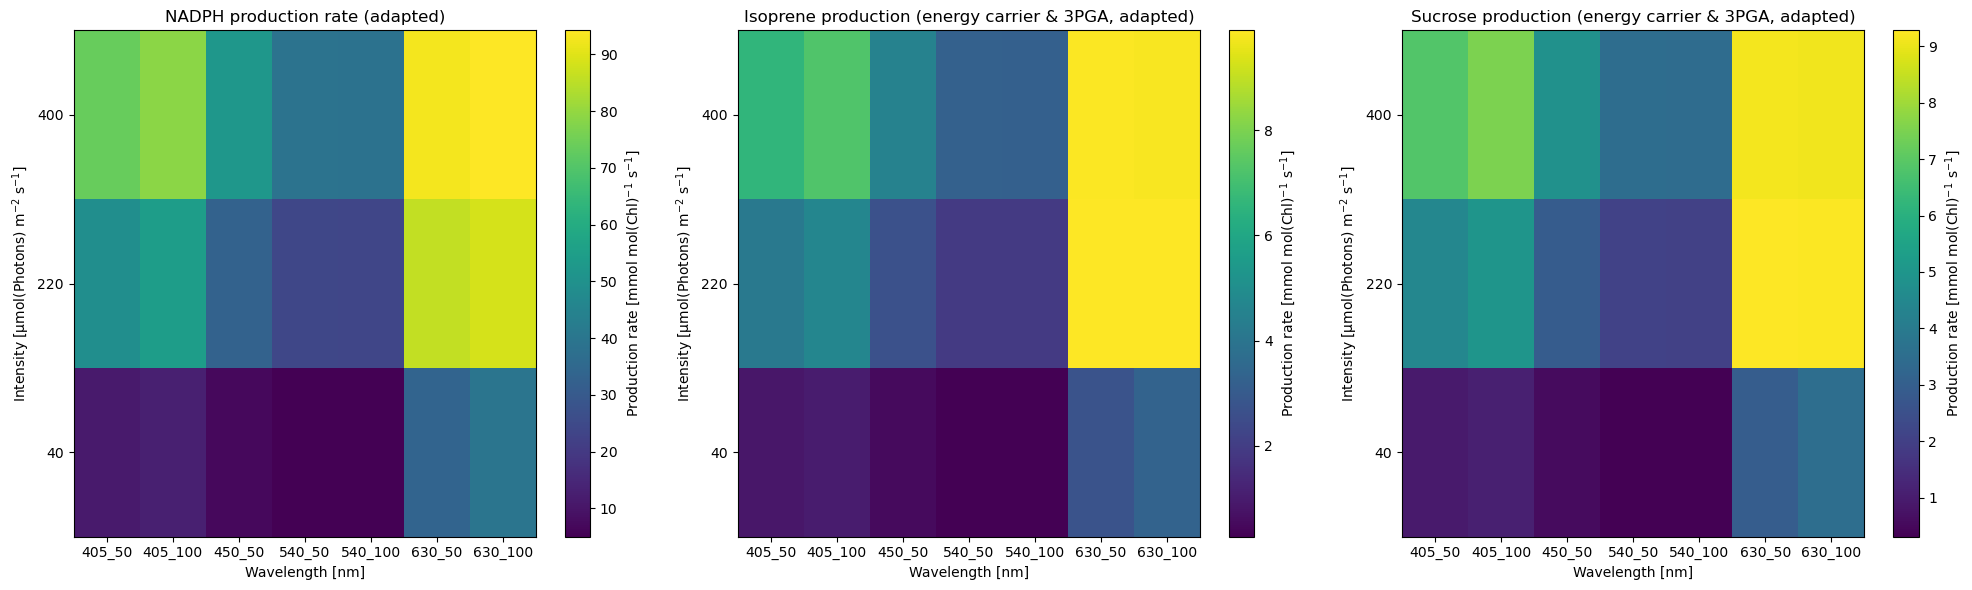

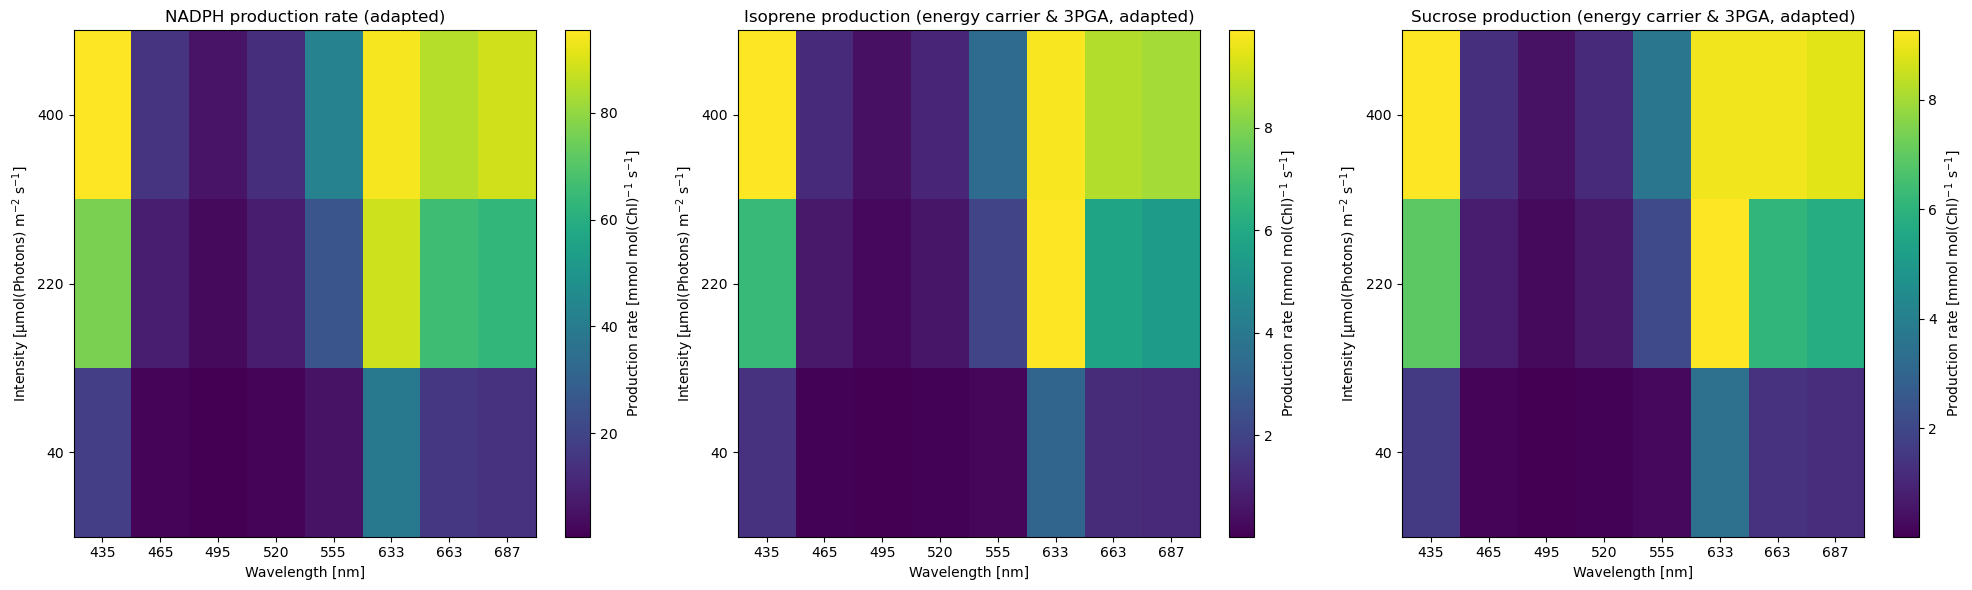

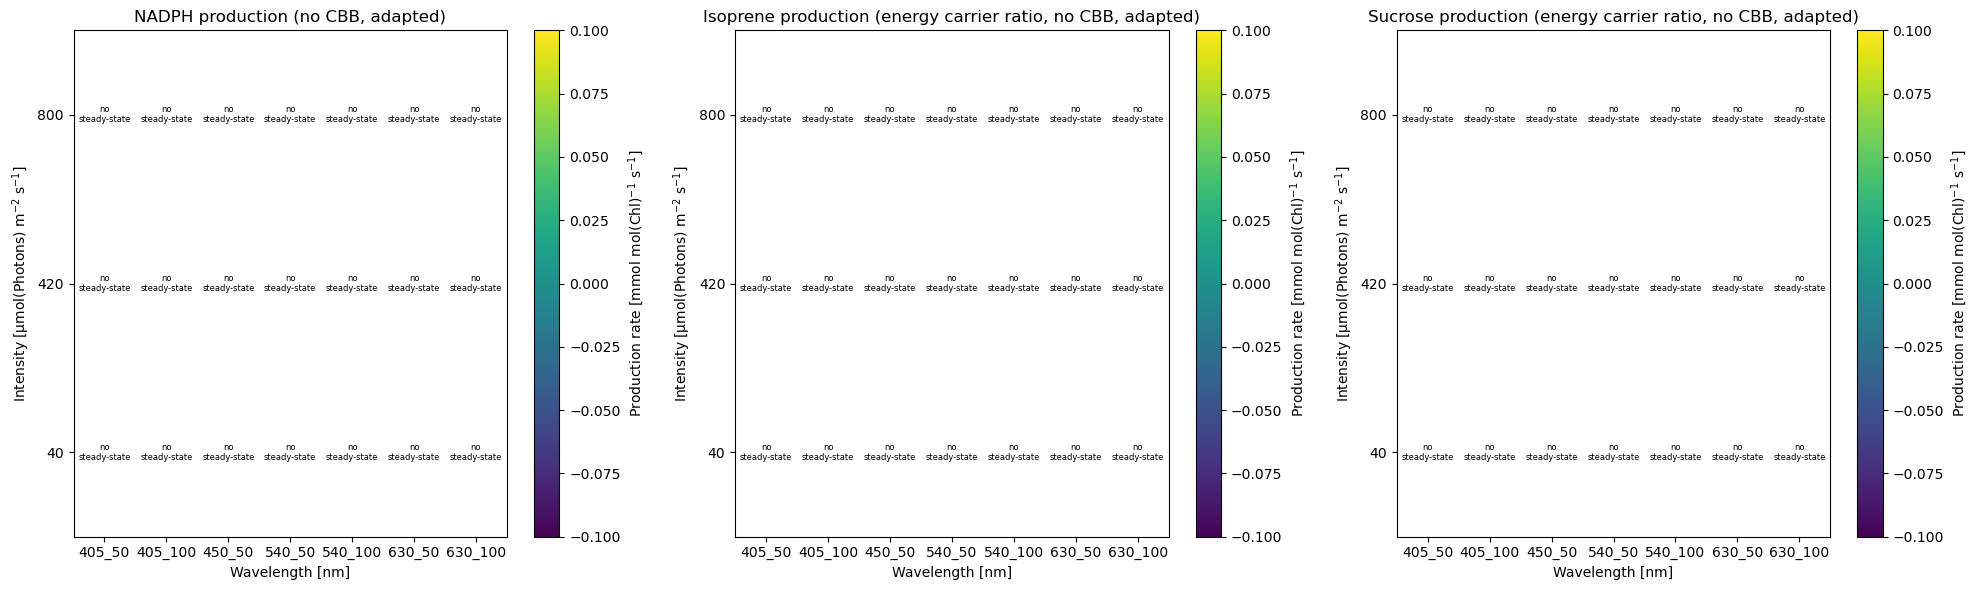

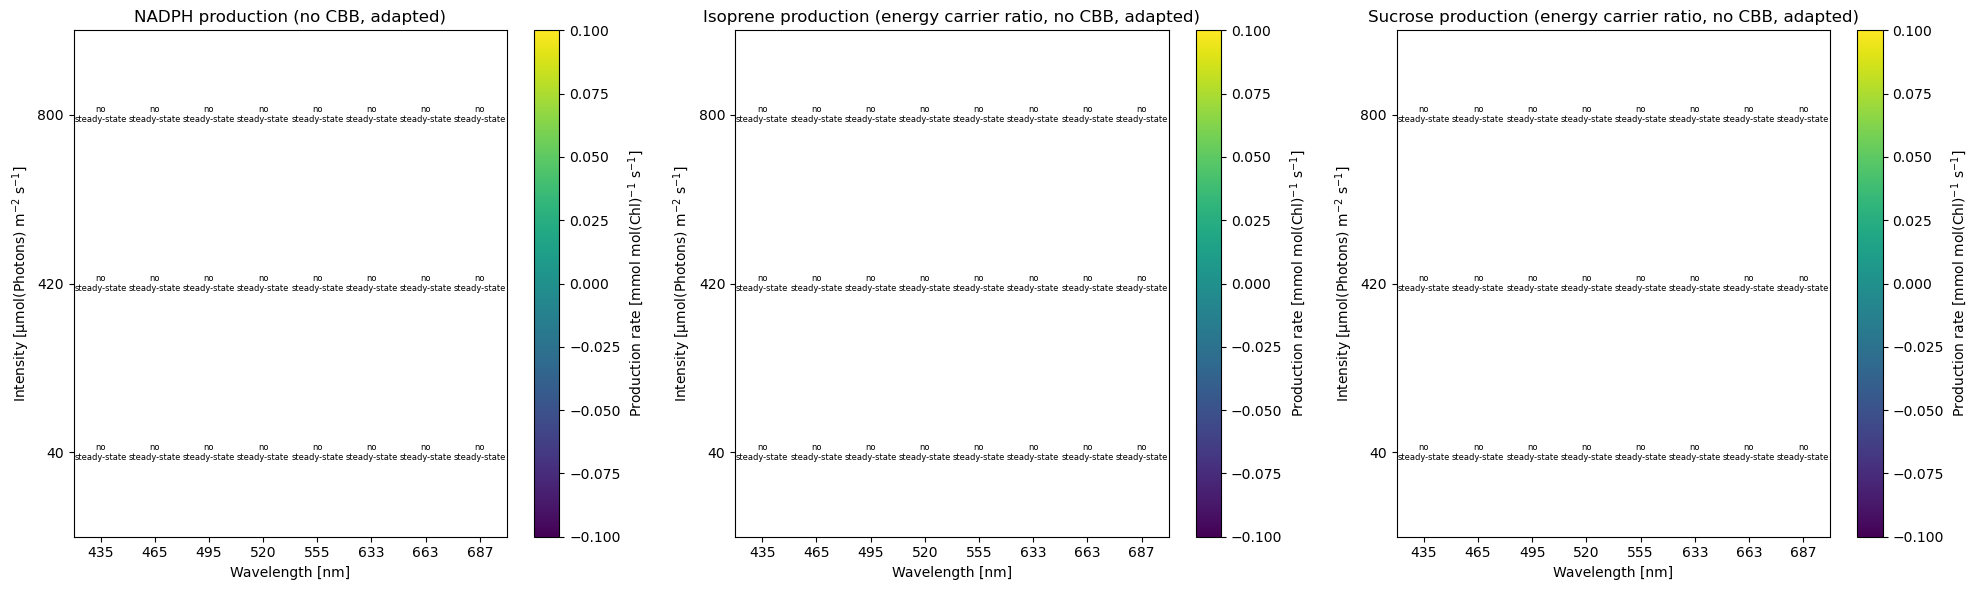

In [98]:
if settings["sink_production_monochrom"]["plot"]:
    combined_plots = {
        "withCBB": ["NADPH", "terpenes", "sucrose"],
        "noCBB": ["NADPH_noCBB", "terpenes_ratio", "sucrose_ratio"]
    }

    for _sinks, nam in zip([sinks, sinks_AN], ["withCBB", "noCBB"]):
        # Loop through both sources for the strain parameters
        for strain_data in ["rodrigues2023", "zavrel2023"]:
            # Create a combined plot
            fig_com, axes_com = plt.subplots(1,3, figsize=(20,6)) #, sharex=True, sharey=True)
            for sink in _sinks:
                prods = fnc.load_obj_dated(f"rev_sink_{sink}_wi", results_path)

                if strain_data == "zavrel2023":
                    prods_sub = prods.iloc[:-2,:].loc[:,np.invert(prods.columns.str.contains("_"))]
                else:
                    prods_sub = prods.iloc[:-2,:].loc[:,prods.columns.str.contains("_")]

                # Single plot
                fig, ax = fnc.plot_heatmap(prods_sub, clab=f"Production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
                ax.set_title(_sinks[sink]['title'])
                ax = fnc.add_na_annotation(ax, prods_sub, 6)
                fig.tight_layout()
                fnc.savefig_dated(fig, f"{sink}prod_singlemonochr", type=plot_format, path=figure_path)
                plt.close()

                # Combined plot
                if sink in combined_plots[nam]:
                    ax_com = axes_com[combined_plots[nam].index(sink)]
                    fig, ax_com = fnc.plot_heatmap(prods_sub, clab=f"Production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]", ax=ax_com)
                    ax_com.set_title(_sinks[sink]['title'])
                    ax_com = fnc.add_na_annotation(ax_com, prods_sub, 6)
            
            fig_com.tight_layout()
            fnc.savefig_dated(fig_com, f"rev_sinkprod_{nam}_{strain_data}_singlemonochr", type=plot_format, path=figure_path)

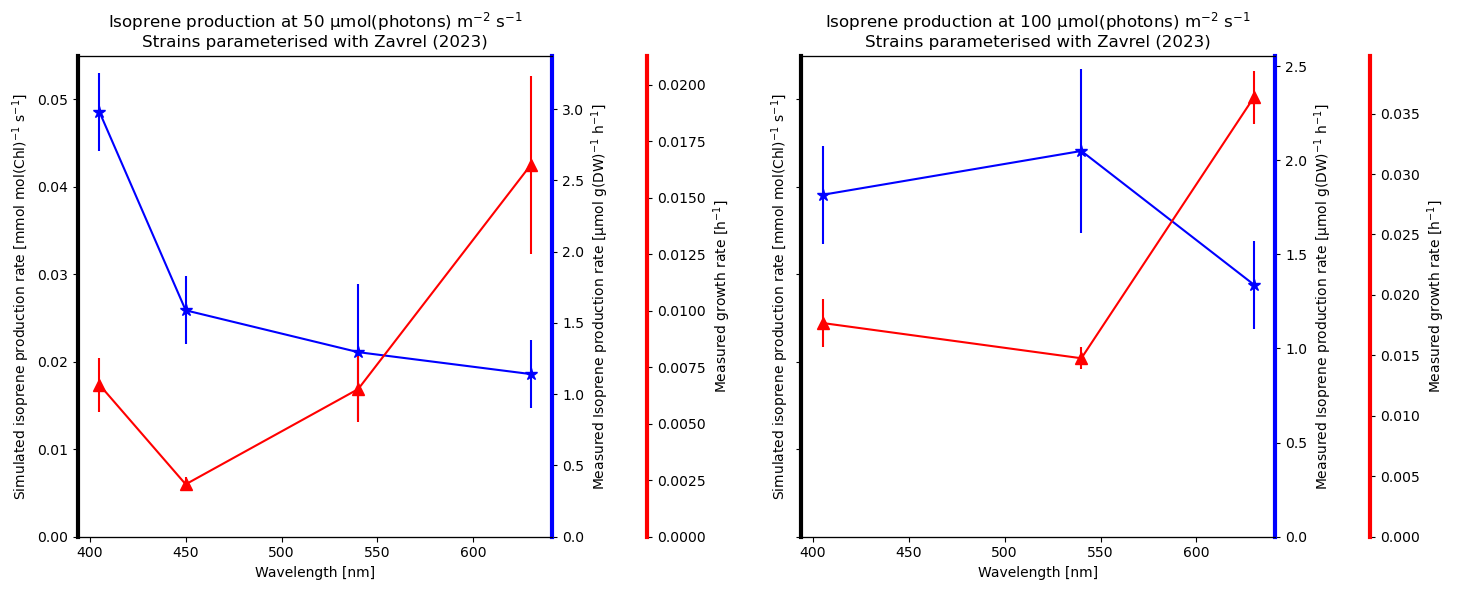

In [99]:
# Select the measurement to be shown for isporene production
isoprene_columns = {
    "mean_Isoprene_umol_gDW_h": "µmol g(DW)$^{-1}$ h$^{-1}$",
    "mean_Isoprene_amol_cell_h": "amol cell$^{-1}$ h$^{-1}$"
}
isoprene_column = "mean_Isoprene_umol_gDW_h"


colors = ["k", "blue", "red"]

measured_intensities = [50, 100]

strain_data_titles = {
    "rodrigues2023":"Rodrigues (2023)", 
    "zavrel2023":"Zavrel (2023)"
}

for strain_data in strain_data_titles:
    if strain_data == "zavrel2023":
        fig, axes = plt.subplots(1,2, figsize = (15,6), sharey = True)
    else:
        fig = paper_figs["figS13"]["main"]
        axes = fig.subplots(1,2, sharey = True)
    for meas_int, ax in zip(measured_intensities, axes.flatten()):
        # prods = fnc.load_obj_dated(f"rev_sink_terpenes_wi", results_path)
        prods = fnc.load_obj_dated("rev_sink_terpenes_ratio_wi", results_path)


        if strain_data == "zavrel2023":
            prods_sub = prods.loc[:,np.invert(prods.columns.str.contains("_"))]
            prods_sub.columns = prods_sub.columns.astype(int)
        else:
            prods_sub = prods.loc[:,prods.columns.str.contains(f"_{meas_int}")]
            prods_sub.columns = prods_sub.columns.str.removesuffix(f"_{meas_int}").astype(int)

        ax.plot(prods_sub.loc[meas_int,:], color=colors[0])
        # ax.plot(prods2.loc[meas_int,:], color=colors[0])
        ax.set_title(f"Isoprene production at {meas_int} µmol(photons) m$^{{-2}}$ s$^{{-1}}$\nStrains parameterised with {strain_data_titles[strain_data]}")
        ax.set_xlabel("Wavelength [nm]")
        ax.set_ylabel("Simulated isoprene production rate [mmol mol(Chl)$^{-1}$ s$^{-1}$]")

        ax2 = ax.twinx()
        ax2.errorbar(
            x = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, :].index,
            y = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, isoprene_column],
            yerr = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, "sd" + isoprene_column.removeprefix("mean")], 
            marker="*", ls=None, color = colors[1], markerfacecolor=colors[1], markeredgecolor=colors[1], markersize=9)
        ax2.set_ylabel(f"Measured Isoprene production rate [{isoprene_columns[isoprene_column]}]")
        ax2.set_ylim(0)
        ax2.spines.right.set_linewidth(3)
        ax2.spines.right.set_color(colors[1])
        ax2.spines.left.set_linewidth(3)
        ax2.spines.left.set_color(colors[0])

        ax3 = ax.twinx()
        ax3.errorbar(
            x = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, :].index,
            y = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, "mean_Growth_rate_h"],
            yerr = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, "sd_Growth_rate_h"], 
            marker="^", ls=None, color = colors[2], markerfacecolor=colors[2], markeredgecolor=colors[2], markersize=8)
        ax3.set_ylabel("Measured growth rate [h$^{-1}$]")
        ax3.spines.right.set_position(("axes", 1.2))
        ax3.set_ylim(0)
        ax3.spines.right.set_linewidth(3)
        ax3.spines.right.set_color(colors[2])

        if strain_data == "zavrel2023":
            fig.tight_layout()
            fnc.savefig_dated(fig, f"rev_isoprenedata_{strain_data}_singlemonochr", type=plot_format, path=figure_path)
        
    ax.set_ylim(0)

## Overexpression analysis

In [100]:
# Plot the Flux control coefficients on the CBB across wavelengths
path = results_path / "coefficients"
type = "fcc"
# light = wavelengths [0]
intensity = intensities[1]

fig = paper_figs["figS16"]["main"]
axes = fig.subplots(3, sharex = True)

fccs = {}
for j, intensity in enumerate([80.0, 400.0, 800.0]):

    fccs[intensity] = pd.DataFrame(index=mca_parameters.keys(), columns=wavelengths)

    for wl in wavelengths:
        fccs[intensity].loc[:,wl] = pd.read_csv(f"{path}/{type}_{wl}_{intensity}.csv", index_col=0).astype(float)["vCBB"]

    _fig, ax, qm = mca.plot_coefficient_heatmap(
        fccs[intensity],
        title="Flux control on CBB",
        ax=axes[j],
        rows=reversed(wavelengths),
        annotate=False,
        norm=TwoSlopeNorm(0, vmax=fccs[intensity].max().max(), vmin=-fccs[intensity].max().max()),
        colorbar=True
    )
    axes[j].set_title(f"intensity: {intensity} µE")
    axes[j].set_ylabel("Light wavelength [nm]")

fig.suptitle("Flux control coefficients over the CBB", y=0.9)

Text(0.5, 0.9, 'Flux control coefficients over the CBB')

In [101]:
# For orange and blue light compare effects of different reaction over-expressions
wls = {
    "Orange": 624,
    "Blue": 440
}

reacts = {
    "Default": None,
    "PSII": "PSIItot",
    "Cytochrome b$_6$f": "k_Q",
    "FNR": "k_FN_fwd",
}

permutation_factor = 2

intens = np.linspace(0.1, 500, 20)

CO2fix = pd.DataFrame(
    columns = reacts.keys(),
    index = pd.MultiIndex.from_product(
        [wls.values(), intens]
    )
)

for nam, wl in wls.items():
    for i in intens:
        # Iterate through the reactions and gat their effects
        for nam, react in reacts.items():
            # Create a model with the respective light input
            _m = m_MCA.copy()
            _m.update_parameter("pfd", lip.light_gaussianLED(wl, i))

            # For each target reaction, change the rate constant by the permutation factor
            if react is not None:
                _m.update_parameter(react, m.parameters[react]*permutation_factor)

            s = Simulator(_m)
            s.initialise(y0)

            # Simulate to steady state
            s,t,y = simulate_to_steady_state_custom(
                s,
                simulation_kwargs={
                    "t_end": 1e6,
                    "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
                    "verbose": False,
                },
                rel_norm=True, 
                return_simulator=True, 
                **fnc.simulator_kwargs["loose"]
            )

            CO2fix.loc[idx[wl, i], nam] = s.get_fluxes_df()["vCBB"].iloc[0]

In [102]:
# Calculate the change in CO2 fixation relative to the default model
CO2fix_rel = (CO2fix.T / CO2fix["Default"]).T
CO2fix_rel = CO2fix_rel.drop("Default", axis=1)
CO2fix_rel = (CO2fix_rel - 1) * 100

fig = paper_figs["fig5"]["subs"]["C"]
axes = fig.subplots(1, CO2fix_rel.shape[1], sharey = True)

for wl_nam, wl in wls.items():
    _res = CO2fix_rel.loc[idx[wl,:],:]
    _res.index = _res.index.droplevel(0)

    for react, ax in zip(_res.columns, axes.flatten()):
        ax.plot(_res[react], c=fnc.wavelength_to_rgb(int(wl)), label=f"{str(wl)} nm")

        ax.axhline(0, c="k", ls="--")
        ax.set_title(f"Factor {permutation_factor} {react} overexpression")
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")

axes[0].set_ylabel("Relative increase in\nCO$_2$ fixation [%]")
axes[-1].legend(loc = "upper right")

fig.subplots_adjust(left=0.05, right=0.95)

## Monte Carlo analysis

In [103]:
# Define all Monte cArlo runs to be plotted
runs = {
    "manually-fitted factor 2": {
        "run": "montecarlo_202405131529",
        "fig": "figS14",
        "sfig-main": "A",
        "sfig-params": "C",
    },
    "manually-fitted factor 0.1": {
        "run": "montecarlo_202405141750",
        "fig": "figS14",
        "sfig-main": "B",
        "sfig-params": "D",
    },
}

# Residual functions
residual_names = {
    'LET_fraction' : "LET ~ 65%",
    'LET_flux': "LET ~ 15 e/PSI/s",
    'Schuurmans_O2': "Schuurmans O2 data",
    'Benschop_O2': "Benschop O2 data",
    "PAMSP435_Fm'": "fitting PAM-SP data: Fm'",
    'PAMSP435_left': "fitting PAM-SP data: left Fs",
    'PAMSP435_right': "fitting PAM-SP data: right Fs",
    "PAMSPval_Fm'": "validation PAM-SP data: Fm'",
    'PAMSPval_left': "validation PAM-SP data: left Fs",
    'PAMSPval_right': "validation PAM-SP data: right Fs",
}

# Iterate through the runs to plot
for run_nam, run_settings in runs.items():

    # run = "montecarlo_202405131529"  # Variation by factor 2
    # run = "montecarlo_202405141750"  # Variation by +- 10%

    # SImulations with different state transition models
    # run = "montecarlo_202406061819_mspill"  # Variation by +- 10%
    # run = "montecarlo_202406061819_mpbsd"  # Variation by +- 10%

    # Load the data
    run = run_settings["run"]
    mcpar = pd.read_csv(Path("../Results")/ (run + "_params.csv"), index_col=0)
    mcres = pd.read_csv(Path("../Results")/ (run + "_results.csv"), index_col=0)


    # Print a summary of the run
    mcres_outcomes = pd.DataFrame(index=mcres.index, columns=["success", "failed", "time-out"])

    mcres_outcomes["timeout"] = np.isnan(mcres).any(axis=1)
    mcres_outcomes["failed"] = np.isinf(mcres).any(axis=1)
    mcres_outcomes["success"] = mcres_succ = np.invert(np.logical_or(mcres_outcomes["timeout"], mcres_outcomes["failed"]))

    print(f"""{run_nam}
Full runs: {mcres_outcomes['success'].sum()}
Time-outs: {mcres_outcomes['timeout'].sum()}
Failed: {mcres_outcomes['failed'].sum()}"""
    )


    # Classify the simulations within a run
    # Find simulations with improved objective functions
    mcres_improved = mcres.copy()
    mcres_improved = mcres_improved - mcres_improved.iloc[0,:]

    # Find simulations with improvement in all objective functions
    mcres_outcomes["total_better"] = (mcres_improved < 0).all(axis=1)

    # Find simulations with improvement in all objective functions
    mcres_outcomes["similar_pareto"] = (mcres_improved < 0.1).all(axis=1)

    print(f"""Better runs (all residuals lower): {mcres_outcomes['total_better'].sum()}
Similar runs (all residuals max + 10%): {mcres_outcomes['similar_pareto'].sum()}"""
    )

    # Make a flat list of the parameters
    mcpar_flat = mcpar.copy()

    # Evaluate the strings in fluo_influence as their dict values are stored as string
    # Not a goor practice
    mcpar_flat["fluo_influence"] = mcpar_flat["fluo_influence"].apply(eval)

    # Unpack the fluo influence parameters 
    _fluo_influence = pd.DataFrame(mcpar_flat["fluo_influence"].to_dict()).T
    _fluo_influence.columns = "fluo_influence_" + _fluo_influence.columns

    # Append them to the parameters
    mcpar_flat = pd.concat([mcpar_flat, _fluo_influence], axis=1)
    mcpar_flat = mcpar_flat.drop("fluo_influence", axis=1)


    # Plot the parameter distribution
    ncols = 3
    nrows = int(np.ceil(mcpar_flat.shape[1]/ncols))

    fig = paper_figs[run_settings["fig"]]["subs"][run_settings["sfig-params"]]
    axes = fig.subplots(nrows, ncols)

    for (nam, val), ax in zip(mcpar_flat.T.iterrows(), axes.flatten()):
        ax.hist(np.log10(val), bins=50)
        ax.set_title(nam)

        ax.axvline(np.log10(val[0]), c="k")
        ax.text(0.51, 0.05, "default", transform = ax.transAxes)

    # Label the lowest x axes
    for i in range(ncols):
        axes[-1,i].set_xlabel("log10 parameter value")

    # Remove unused axes
    if ncols * nrows > mcpar_flat.shape[1]:
        for i in range(mcpar_flat.shape[1], ncols * nrows):
            axes.flatten()[i].remove()

    fig.suptitle("Distribution of perturbed parameter values (log scaled)")


    # Main plot of the residuals
    mcres_norm = mcres / mcres.loc[0, :]

    # Get the worst improvement
    mcres_worst = mcres_norm.max(axis=1)
    mcres_mean = mcres_norm.mean(axis=1)

    fig = paper_figs[run_settings["fig"]]["subs"][run_settings["sfig-main"]]
    ax = fig.subplots()

    # Zoom to the pareto front
    point_select = np.logical_and(
        mcres_mean < 1.1,  
        mcres_worst < (mcres_worst.min() + (mcres_worst.max() - mcres_worst.min()) * 0.1)
    )

    axin = ax.inset_axes(
        [0.1, 0.6, 0.3, 0.3],)
        # xlim=(0.5, 1.1), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axin.set_title("Close to pareto front")

    for _ax, _point_select in zip([ax, axin], [slice(None), point_select]):
        # Indicate the area of improvement
        _ax.axhline(1, ls="--", c="k", alpha=0.5)
        # _ax.axhspan(0.5, 1, facecolor="green", alpha=0.1)
        _ax.add_artist(plt.Rectangle((0.5, 0), 6, 1, alpha=0.1, zorder=1, facecolor="green"))

        # Plot the distribution of residuals
        _ax.plot(
            mcres_mean[_point_select],
            mcres_worst[_point_select],
            ls = "",
            marker = "."
            )
        # Show the default parameter set
        _ax.plot(
            mcres_mean[0],
            mcres_worst[0],
            ls = "",
            marker = ".",
            c="k"
            )

    ax.indicate_inset_zoom(axin, edgecolor="black")
    ax.text(0.95, 0.05, "All residuals improved", ha="right", va="top", transform=ax.transAxes)

    ax.set_xlabel("Mean relative residuals [rel]")
    ax.set_ylabel("Least improved residual [rel]")

    # Calculate the approximate factor by which the parameters were varied
    approx_variation_factor = ((mcpar_flat.iloc[:,1].max() - mcpar_flat.iloc[:,1].min()) / 2) / ((mcpar_flat.iloc[:,1].max() + mcpar_flat.iloc[:,1].min()) / 2)
    fig.suptitle(f"Distribution of residuals in Monte Carlo simulations\n{mcres_succ.sum()} simulations with {mcpar_flat.shape[1]} parameters randomly varied within a factor {np.round(approx_variation_factor,1)} higher or lower", y=0.93)

manually-fitted factor 2
Full runs: 9527
Time-outs: 474
Failed: 0
Better runs (all residuals lower): 0
Similar runs (all residuals max + 10%): 19
manually-fitted factor 0.1
Full runs: 9562
Time-outs: 439
Failed: 0
Better runs (all residuals lower): 161
Similar runs (all residuals max + 10%): 2548


## Plot the SP-color experiment

In [104]:
# Read and subset the data
spcol = pd.read_excel("../Code/data/SPInt_fluorescence_experiment_Figure13.xlsx", index_col=0)
spcol = spcol.iloc[:, [6, 4, 1,]].loc[5:, :]

In [105]:
fig = paper_figs["figS6"]["main"]
ax = fig.subplots()

# Set the colors for the plot
colors = [fnc.wavelength_to_rgb(x) for x in [625, 440, 480]]

# Plot the data
for (nam, _spcol), col in zip(spcol.T.iterrows(), colors):
    ax.plot(_spcol, label=nam, c=col)

# Add the annotation reactangle and line
ax.axvline(500, ls="--", c="k")
ax.axhspan(1.1, 1.15, facecolor="none", edgecolor="k")
ax.set_ylim(None, 1.15)

# Add the annotation text
ax.text(0.25, 0.94, "SP-Int=1", transform=ax.transAxes, ha="center")
ax.text(0.75, 0.94, "SP-Int=20", transform=ax.transAxes, ha="center")

# Add the axis labels
ax.set_xlabel("Time [s]")
ax.set_ylabel("Fluorescence intensity [AU]")

ax.legend(loc=(0,0.7))

## Comparison figure between parameter sets

In [106]:
# Get functions to evaluate minimisation results
from robustness_fit_parameters import get_fitting_parameter_dict, p_names
import pickle

Aborted


In [107]:
# Get the new parameters that should be visualised
with open("../Results/minimise_202405291906_results.pickle", "rb") as f:
    fit = pickle.load(f)

new_parameters = get_fitting_parameter_dict(fit.x, p_names)

In [108]:
# # Select the run that the comparison parameter set comes from
# run = "montecarlo_202405141750"  # Variation by +- 10%

# mcpar = pd.read_csv(Path("../Results")/ (run + "_params.csv"), index_col=0)
# mcres = pd.read_csv(Path("../Results")/ (run + "_results.csv"), index_col=0)

# # new_parameters = get_fitting_parameter_dict(fit.x, p_names)

# # Summary
# mcres_outcomes = pd.DataFrame(index=mcres.index, columns=["success", "failed", "timeout"])

# mcres_outcomes["timeout"] = np.isnan(mcres).any(axis=1)
# mcres_outcomes["failed"] = np.isinf(mcres).any(axis=1)
# mcres_outcomes["success"] = mcres_succ = np.invert(np.logical_or(mcres_outcomes["timeout"], mcres_outcomes["failed"]))

# print(f"""Full runs: {mcres_outcomes['success'].sum()}
# Time-outs: {mcres_outcomes['timeout'].sum()}
# Failed: {mcres_outcomes['failed'].sum()}"""
# )

# # Find simulations with improved objective functions
# mcres_improved = mcres.copy()
# mcres_improved = mcres_improved - mcres_improved.iloc[0,:]

# # Find simulations with improvement in all objective functions
# mcres_outcomes["total_better"] = (mcres_improved < 0).all(axis=1)

# # Find simulations with improvement in all objective functions
# mcres_outcomes["similar_pareto"] = (mcres_improved < 0.1).all(axis=1)

# print(f"""
# Better runs (all residuals lower): {mcres_outcomes['total_better'].sum()}
# Similar runs (all residuals max + 10%): {mcres_outcomes['similar_pareto'].sum()}"""
# )

# # Get the best parameter set
# mcres_best = mcres.mean(axis=1)[mcres_outcomes["total_better"]].sort_values()
# print(mcres_best.head())
# best_idx = mcres_best.index[0]

# # Set the new parameters
# new_parameters = mcpar.loc[best_idx, :].to_dict()
# new_parameters["fluo_influence"] = eval(new_parameters["fluo_influence"])

In [109]:
# Set to True to recalculate the results of analyses that take a long time
# Set to False to use pre-calculated results
settings = {
    "general":{
        # Set to True to plot/ recalculate all figures (VERY TIME INTENSIVE!)
        # Set to False to plot/ recalculate no figure
        # Set to None to use figure specific settings (below)

        "plot_all": True, 
        "recalculate_all": True,

        # Use multiprocessing
        "multiprocessing": True,
        "max_workers": os.cpu_count() - 2,
    },
    # Figure specific settigs (overwritten by above settings)
    # Recalculation time with Intel Core i7, 16 cores, 64 GB memory
    "MCA":                          {"recalculate": False, "plot": True}, # Recalculation time: 30 min
    "CO2_fluxes_spectral":          {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "open_PS2s":                    {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "state_transitions_PAM":        {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "state_transitions_analysis":   {"recalculate": False, "plot": True}, # Recalculation time: 150 min
    "CO2_fluxes_monochrom":         {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "CO2_fluxes_monochrom_adapted": {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "sink_production_monochrom":    {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "PAM_blue_light":               {"recalculate": False, "plot": True}, # Recalculation time: 2 min
    "PAM_all_lights":               {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "electron_pathways":            {"recalculate": False, "plot": True}, # Recalculation time: 7 min
    "O2_CO2_fluxes":                {"recalculate": False, "plot": True}, # Recalculation time: 1 min
}

# Set the paths to save figures and objects
figure_path = Path("../Figures/bestMC_visualisation")
results_path = Path("../Results/bestMC_visualisation")

default_results_path = Path("../Results")

plot_format = ["svg", "png"]

# Reduce or increase the number of simulated points in appropriate analyses (1=default amount)
fraction_simulated_points = 0.3

In [110]:
# Apply general settings
for k,v in settings.items():
    if k!= "general":
        if settings["general"]["recalculate_all"] is not None:
            v["recalculate"] = settings["general"]["recalculate_all"]
        if settings["general"]["plot_all"] is not None:
            v["plot"] = settings["general"]["plot_all"]
        settings[k] = v

In [111]:
# Define a function to get a model with updated parameters
def get_model_new_parameters(*args, p=new_parameters, **kwargs):
    # Get the model
    res = get_model(*args, **kwargs)

    # Separate model and initial conditions if both are returned
    if isinstance(res, tuple):
        m,y0 = res
    else:
        m,y0 = res, None

    # Update the parameters
    m.update_parameters(p)
    return (m,y0) if y0 is not None else m

# Carbon Dioxide Fluxes under Different Light Sources (Figure 3b)

In [112]:
def get_ssflux(m, y0, lightfun, target, light_params, tolerance=1e-4, rel_norm=False):
    light = lightfun(*light_params)
    s = Simulator(m.copy())
    s.update_parameter("pfd", light)
    s.initialise(y0)
    # t,y = s.simulate_to_steady_state(tolerance=tolerance, rel_norm=rel_norm, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        return float(s.get_fluxes_dict()[target])

def get_ssfluxes(m, y0, lightfun, target, lightparam1, lightparam2, multiprocessing=True, max_workers=None):
    light_params = np.meshgrid(lightparam1, lightparam2)
    _light_params = zip(*[x.flatten() for x in light_params])

    _get_ssflux = partial(get_ssflux, m, y0, lightfun, target)

    if sys.platform in ["win32", "cygwin"] or not multiprocessing:
        res = np.array(list(map(_get_ssflux, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as pe:
            res = np.array(list(pe.map(_get_ssflux, _light_params)), dtype=float)

    res = res.reshape(-1,len(lightparam1))
    return pd.DataFrame(res, index=lightparam2, columns=lightparam1)

In [113]:
# Get a model and fix the 3PGA concentration for steady-state analyses 
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

m_MCA,y0 = get_model_new_parameters(check_consistency=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

lights = {"solar": "Solar Light", "fluorescent_lamp": "Fluorescent Lamp", "cool_white_led": "Cool White LED", "warm_white_led": "Warm White LED"}
intens = np.linspace(20, 500, int(50 * fraction_simulated_points))
if settings["CO2_fluxes_spectral"]["recalculate"]:
    CO2s = get_ssfluxes(
        m_MCA, 
        y0, 
        lip.light_spectra, 
        "vCCM", 
        list(lights.keys()), 
        intens,
        multiprocessing = settings["general"]["multiprocessing"],
        max_workers = settings["general"]["max_workers"],
    )

    fnc.save_obj_dated(CO2s, "spectra_ss_CO2s", results_path)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten


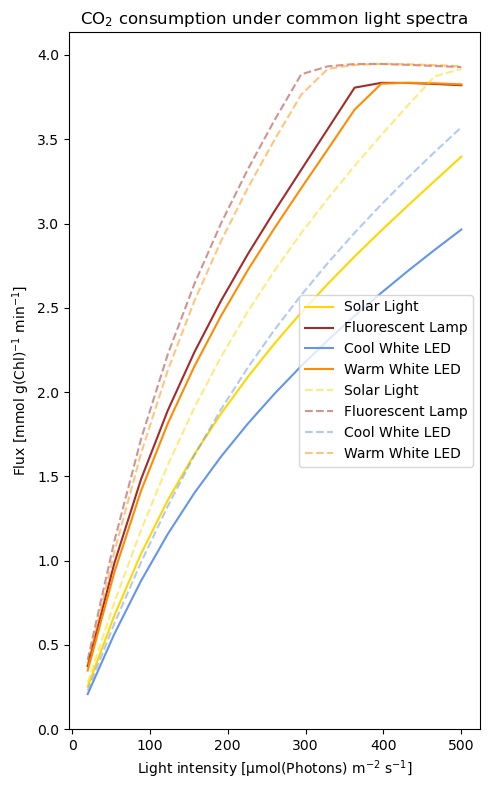

In [114]:
if settings["CO2_fluxes_spectral"]["plot"]:
    CO2s = fnc.load_obj_dated("spectra_ss_CO2s", results_path)
    CO2s_def = fnc.load_obj_dated("spectra_ss_CO2s", default_results_path) # Load results with default parameters

    labels = lights.values()
    colors = ["gold", "brown", "cornflowerblue", "darkorange"]

    fig, ax = plt.subplots(figsize=(5,8))
    ax.set_prop_cycle('color',colors)
    ax.plot(CO2s * prm.unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', "s-1 -> min-1"]), label = labels)
    ax.plot(CO2s_def * prm.unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', "s-1 -> min-1"]), label = labels, ls="--", alpha=0.5)
    ax.set_ylabel('Flux [mmol g(Chl)$^{-1}$ min$^{-1}$]')
    ax.set_xlabel('Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]')
    ax.set_title("CO$_2$ consumption under common light spectra")
    ax.legend(loc="center right", fontsize=10)
    ax.set_ylim(ymin=0)
    fig.tight_layout()
    fnc.savefig_dated(fig, "CO2underspectrallight", type=plot_format, path=figure_path)

# Open Photosystems Ratio (Figure 7)
Comparison to Miller *et al.* (2021)

In [115]:
if settings["open_PS2s"]["recalculate"]:
    lights = np.append(0, np.linspace(100, 700, 30))
    sims = {}
    openPSII = pd.Series(index=lights, dtype=float)
    for i, j in enumerate(lights):
        m,y0 = get_model_new_parameters(check_consistency=False, verbose=False)
        m = fnc.add_exchange(m)
        s = Simulator(m)
        s.initialise(y0)
        s.update_parameter("pfd", lip.light_spectra("fluorescent_lamp", j))
        # t,y = s.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
        s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
        sims[i] = s

        if t is not None:
            openPSII.iloc[i] = s.get_full_results_df().loc[:,["B0", "B1"]].sum(axis=1, skipna=False) / m.get_parameter("PSIItot")
    
    fnc.save_obj_dated(openPSII, "openps2s", results_path)

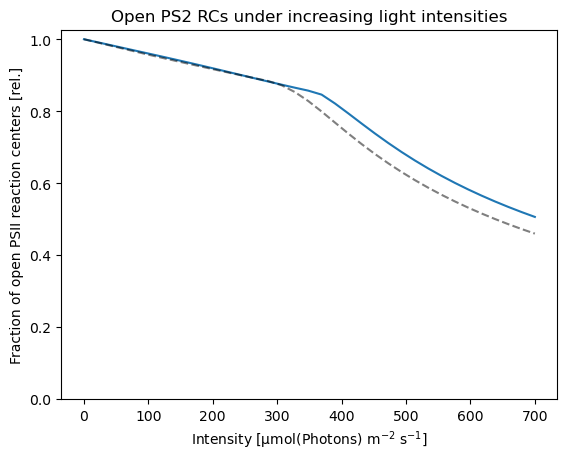

In [116]:
if settings["open_PS2s"]["plot"]:
    openPSII = fnc.load_obj_dated("openps2s", results_path)
    openPSII_def = fnc.load_obj_dated("openps2s", default_results_path) # Load results with default parameters

    fig, ax = plt.subplots()
    ax.plot(openPSII)
    ax.plot(openPSII_def, ls="--", alpha=0.5, c="k")
    ax.set_ylim(ymin=0)
    ax.set_xlabel("Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.set_ylabel("Fraction of open PSII reaction centers [rel.]")
    ax.set_title("Open PS2 RCs under increasing light intensities")
    fnc.savefig_dated(fig, "openps2s", type=plot_format, path=figure_path)

In [117]:
# Plotting functions
def add_phasebox(ax, t_start, t_end, text, height, ylow=1, adj_plotheight=False, fontsize=7):
    box = Rectangle(
        [t_start, ylow],
        t_end-t_start,
        height,
        fill=False,
        ec="k",
    )
    ax.add_patch(box)
    ax.text(
        t_start + 0.5*(t_end-t_start),
        ylow+0.5*height,
        text,
        ha="center",
        va="center",
        fontsize=fontsize
    )
    if adj_plotheight:
        ax.set_ylim(ymax=ax.get_ylim()[1]+height)
    return ax

def add_insetbox(ax, xmin, xmax, ymin, ymax, adj_plotheight=None):
    height = ymax-ymin
    box = Rectangle(
        [xmin, ymin],
        xmax-xmin,
        height,
        fill = False,
        fc="w",
        ec="k",
        transform = ax.transAxes
    )
    ax.add_patch(box)
    if adj_plotheight is not None:
        adj_y = np.array(ax.get_ylim()) + np.array(adj_plotheight)
        ax.set_ylim(adj_y)
    return ax

def annotate_phases_statetrans(ax):
    cycles = np.array([3,3,15,15])
    times = np.cumsum(cycles * 20)
    ax = add_phasebox(ax, 0, times[0], "D", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, times[0], times[1], "S1", 0.05, 1.02)
    ax = add_phasebox(ax, times[1], times[2], "S2", 0.05, 1.02)
    ax = add_phasebox(ax, times[2], times[3], "S1", 0.05, 1.02)

    return ax

# Pulse Amplitude Modulation (PAM) measurements with saturation pulse method
## PAM-SP under of 435 nm adapted strain (Figure 2a)

In [118]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

### Get the PAM and strain data

In [119]:
def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,str(light)] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,str(growthlight)]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,str(growthlight)]), fraction_is_monomers=True, output_is_monomers=False)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def _plot_model_and_data(s, data, sim_offset=None, data_offset=None, ax=None):
    # Initialise a plot
    if ax is None:
        fig, ax = plt.subplots(**fnc.plt_defaults["figure"])
    else:
        fig = ax.figure

    # Align data and model using an offset
    if sim_offset is None:
        time = s.get_time()
    elif s.get_time()[0] != (-sim_offset):
        time = np.array(s.get_time())- (s.get_time()[0] + sim_offset)
    else:
        time = s.get_time()

    # Plot the data
    dat = data/data.max().max()
    dat_time = dat.index

    if data_offset is not None:
        dat_time -= data_offset
    dat_line = ax.plot(dat_time, dat.values, c="firebrick", label="Measurement")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluorescence [rel.]")
    ax.set_ylim(ymin=0)

    # Plot the simulation on top
    fluo = s.get_full_results_dict()["Fluo"]
    fluo_norm = fluo / fluo.max()
    sim_line = ax.plot(time, fluo_norm, c="black", label="Simulation")

    if len(dat_line)>1:
        handles = sim_line + dat_line[0]
    else:
        handles = sim_line + dat_line

    ax.legend(
        handles = handles,
        loc="center right",
        bbox_to_anchor = (1,0.85)
    )

    return fig, ax

def plot_model_and_data(s, data, pulse_pfd, ax=None, sim_offset=None, data_offset=None, **lightbar_kwargs):
    figs={}

    # Data plot
    col_select_kw = "^F"
    col_select = [i for i,x in enumerate(data.columns) if re.search(col_select_kw, x)]
    col_selectnam = data.columns[col_select]
    plot_data = data.loc[10:data.index[-1]-10, col_selectnam[:-1]]

    s_trim = fnc.remove_beginning_from_simulation(s, 300)

    fig,ax = _plot_model_and_data(s_trim, plot_data, sim_offset=sim_offset, data_offset=data_offset, ax=ax)
    ax = fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, **lightbar_kwargs)

    return fig, ax

def annotate_electron_pathways(ax, epath):
    ypos = epath.cumsum(axis=1) - (epath/2)

    for y,s in zip(ypos.to_numpy().flatten(), epath.to_numpy().flatten()):
        ax.text(x=0, y=y, s=np.round(s,3), ha='center', va='center')
    return ax

def ss_analysis(m, light_int=100, light_wl=659):
    sslight = lip.light_gaussianLED(light_wl, light_int)
    mss = m.copy()
    mss.update_parameter("pfd", sslight)

    # Initialise the model
    sss=Simulator(mss)
    sss.initialise(y0)
    t,y = sss.simulate(10000)

    # plot_overview_isoATP(sss)
    epath = fnc.get_ss_electron_pathways(sss)
    epath = epath/float(epath.sum(axis=1, skipna=False))
    ax = epath.plot(kind="bar", stacked=True)

    # Annotate the bars
    ax = annotate_electron_pathways(ax,epath)
    return sss, [ax], epath

In [120]:
# Get the fluorescence data paths
DIRPATH = Path("../Code/data")
PAMPATH = DIRPATH / "PAM_Slow_kinetics_files_Zavrel2021"
file_names = listdir(PAMPATH)
file_paths = np.array([join(PAMPATH, file_name) for file_name in file_names])

In [121]:
# Extract the measurement type from the file name, use to group replicates
meas_types = np.array([re.sub(r"([0-9]+)_[0-9]+\.[csvCSV]+", "\\1", x) for x in file_names])
meas_types_set = list(set(meas_types))
meas_types_set.sort()

In [122]:
# Load and preprocess all data
pamdata = {}

for meas_select in  meas_types_set:
    file_paths_select = file_paths[meas_types == meas_select]

    # Create a container for the combined data
    meas_data = pd.DataFrame([])

    # Iterate through the files
    for i,file_path in enumerate(file_paths_select):
        # Adapt the file reading parameters depending on the file structure
        if meas_select.startswith("PSI+PSII kinetics"):
            skiprows = 1
        else:
            skiprows = 0
        
        # Read the file and remove empty columns
        file_data = pd.read_csv(file_path, sep=";",skiprows=skiprows, index_col=0)
        file_data=file_data.loc[:,np.invert(np.all(np.isnan(file_data), axis=0))]

        if i == 0:
            # Save the common column names
            col_names = file_data.columns

        # Combine replicates
        meas_data = meas_data.join(file_data, rsuffix=f"_{i}", how="outer")

    # Exclude all data points that are nor present in all datasets
    excl_data = meas_data.iloc[list(np.invert(np.isnan(meas_data).any(axis=1))),:]
    excl_data.shape
        
    # Normalise the Data to its highest point
    norm_data = excl_data.copy()
    norm_data = norm_data / norm_data.max()

    # Set the normalised data as analysis data
    data = norm_data

    # # Calculate the mean over selected columns
    # for col_name in col_names:
    #     col_select = [bool(re.search(col_name, x)) for x in data.columns]
    #     col_mean = data.iloc[:,col_select].mean(axis=1, skipna=False).rename(f"{col_name}_mean")

    #     # Add to the dataframe
    #     data = data.join(col_mean)
    
    # Store the data
    pamdata[meas_select] = data

# Extract the growth lights
growthlights = set([re.sub("^.*([0-9]{3})$","\\1",meas_select) for meas_select in meas_types_set])

In [123]:

# Get the strain-specific parameters
dat = pd.read_csv(DIRPATH / "Strainparameters_Zavrel2021.csv", skiprows=1, index_col=0).iloc[:,2:]

# Get the concentration data
# dat_conc = dat.loc[dat.loc[:,"Unit"].str.match("fg cell-1"), :]
dat_conc = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
dat_conc.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

# Convert to [mg mg(Chla)^-1]
dat_conc = dat_conc.div(dat_conc.iloc[0,:]) # convert to [mg mg(Chla)^-1]
dat_conc.loc[:,"Unit"] = "mg mg(Chla)^-1"

# Get the photosystems data
dat_PS = dat.loc[["PSI / PSII"],:]

# Get the phycobilisome data
dat_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
dat_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]


# Calculate the strain parameters
strain_params = {}
strain_export = {}

for growthlight in dat.columns:
    # Get the strain specific parameters
    strain_param = get_strain_parameters(
        df_pigments=dat_conc,
        df_PBS=dat_PBS,
        df_PS1_PS2=dat_PS,
        growthlight=growthlight,
        pbs_relfluo={"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    )

    MChl = 893.509 # [g mol^-1]
    absorption_coef = lip.get_pigment_absorption(strain_param["pigment_content"]).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

    # Get the PAM sample Chl concentration
    # Estimated from a later measurement where OD600 = 0.8, the PAM samples had 0.6
    OD800_Chlconc = pd.read_excel(DIRPATH/"Chlorophyll, total car.xlsx", skiprows=1).iloc[1:,].loc[:,["Sample", "Chlorophyll a"]]
    OD800_Chlconc.loc[:,"Sample"] = OD800_Chlconc.loc[:,"Sample"].str.removesuffix(" nm")
    OD800_Chlconc = OD800_Chlconc.groupby("Sample").mean()
    OD800_Chlconc.head() # [mol (10 ml)^-1]

    indexmapping = {idx1:idx2 for idx1,idx2 in zip(dat.columns, OD800_Chlconc.index)}

    # Convert the chlorophyll concentration units
    cuvette_Chlconc = ( # [mmol(Chl) m^-3]
        float(OD800_Chlconc.loc[indexmapping[str(growthlight)]]) # [mol (10 ml)^-1]
        / 10 # [ml]
        * 1e3 # [mol mmol^-1]
        * 1e6 # [ml m^-3]
        * 0.3 / 0.8 # [rel] OD of the PAM sample
    )

    # Save the data
    strain_params[growthlight] = {
        "params": strain_param,
        "cuvette_Chlconc": cuvette_Chlconc
    }

### Model the data

In [124]:

lights = make_lights(blue_wl=480)
lights_adj = make_adjusted_lights(absorption_coef, cuvette_Chlconc)
dark_adj, low_blue_adj, high_blue_adj, orange_adj, pulse_orange_adj, pulse_blue_adj = lights_adj

# Get the pfd of the pulses
pulse_pfd = np.min([simpson(x) for x in [pulse_orange_adj, pulse_blue_adj]])

In [125]:
def complex_absorption(pfd, ps_ratio, pigment_content):
    absorption = lip.get_pigment_absorption(pigment_content)
    association = lip.get_pigment_association(
        ps_ratio,
        beta_carotene_method="stoichiometric",
        pigments=pigment_content,
        verbose=False,
    )

    M_chl = 893.509  # [g mol^-1] molar mass of chlorophyll a (C55H72MgN4O5)

    return (
        lip.get_complex_absorption(pfd, absorption, association) * M_chl
    )  # [µmol(Photons) mmol(Chl)^-1 s^-1]

### Simulate all of the datasets (435 & 633nm light in two light protocols)

In [126]:
sims = {}
sims_def = {}

# Select the measurement to simulate
for meas_select in meas_types_set:
    growthlight = int(meas_select[-3:])

    print("Measurement: ", meas_select, "\nSimulated light: ", growthlight,"\n")

    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model_new_parameters(check_consistency=False, reduced_size=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Change the CO2 concentration to 400ppm as experiments were conducted in air
    m4.update_parameter("CO2ext_pp", 0.0004)

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Simulate the appropriate protocol
    pulse_pfdm4 = 2600 * 2
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfdm4, blue_wl=480)
    )
    if meas_select.startswith("PSII kinetics, NPQ at state 2"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    if settings["PAM_blue_light"]["recalculate"]:
        s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
        fnc.save_Simulator_dated(s4, f"Zavrel2021sim{meas_select[-5:]}", path=results_path, save_fluxes=True, save_full_results=True)
    else:
        print("loading simulation")
        s4 = fnc.load_Simulator_dated(name = f"Zavrel2021sim{meas_select[-5:]}", path=results_path, date=None)
    
    sims[meas_select] = s4

    sims_def[meas_select] = fnc.load_Simulator_dated(name = f"Zavrel2021sim{meas_select[-5:]}", path=default_results_path, date=None)

Measurement:  PSII kinetics, NPQ at state 1_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 1_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light repr

In [127]:
def add_phaseboxes_NPQ(ax):
    ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 215.6, 395.9, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 395.9, 576.2, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 576.2, 756.5, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 756.5, 1000, "NPQ relaxation", 0.05, 1.02)
    return ax

def add_phaseboxes_noNPQ(ax):
    ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 215.6, 515.9, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 515.9, 695.5, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 695.5, 935, "NPQ relaxation", 0.05, 1.02)
    return ax

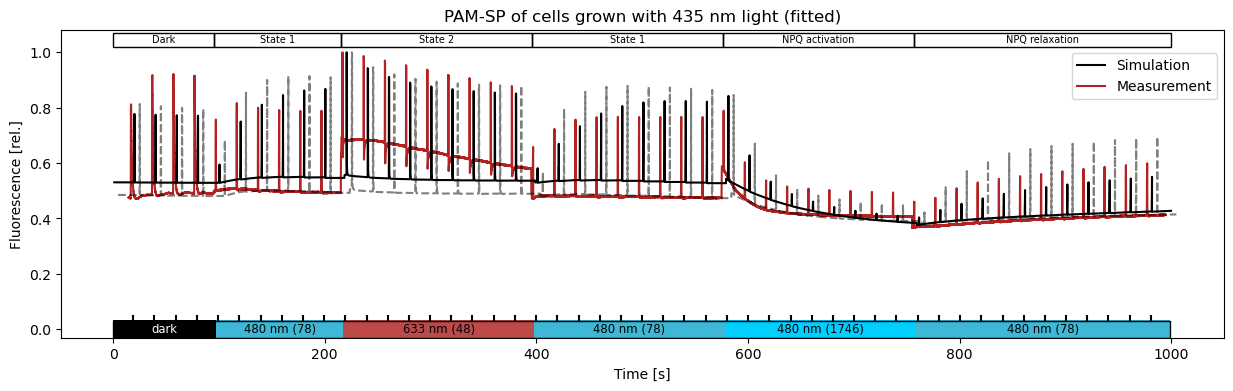

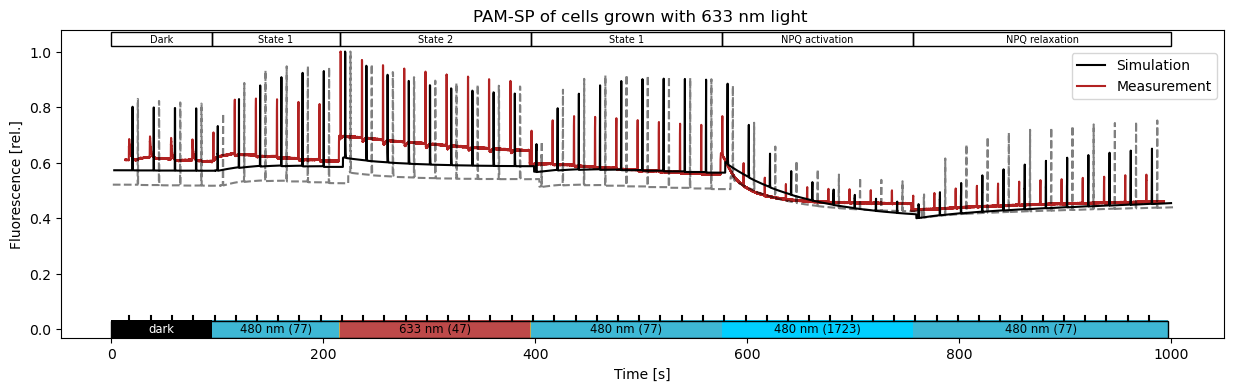

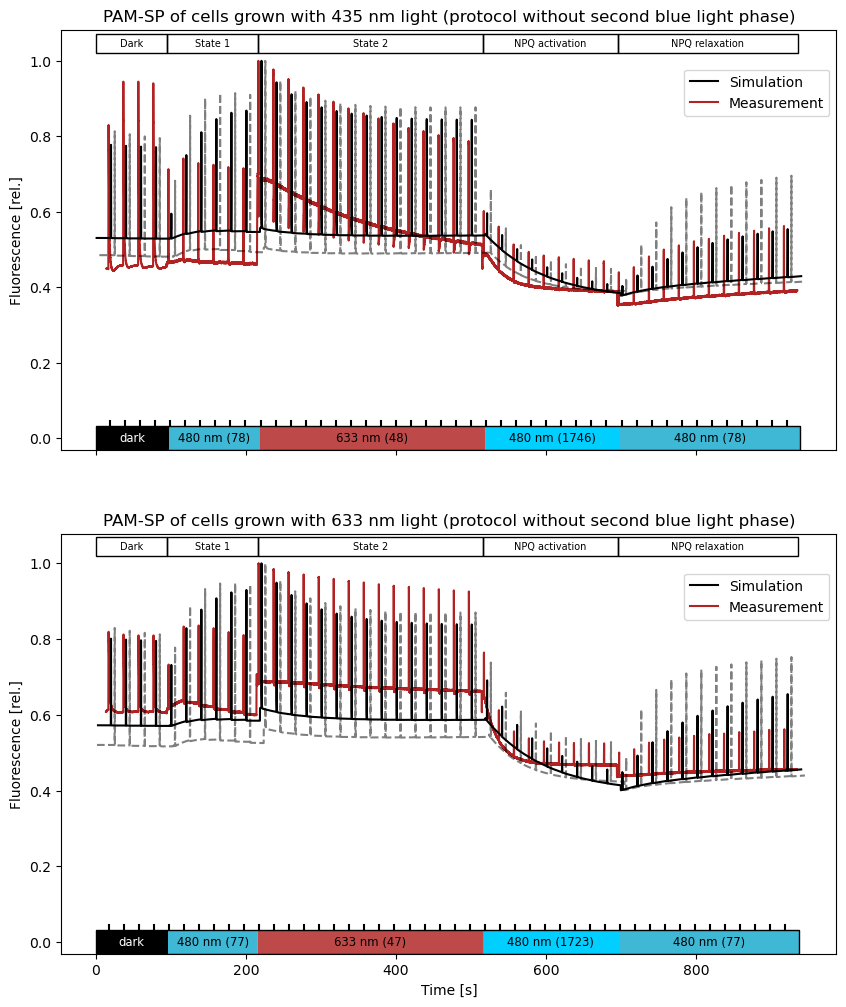

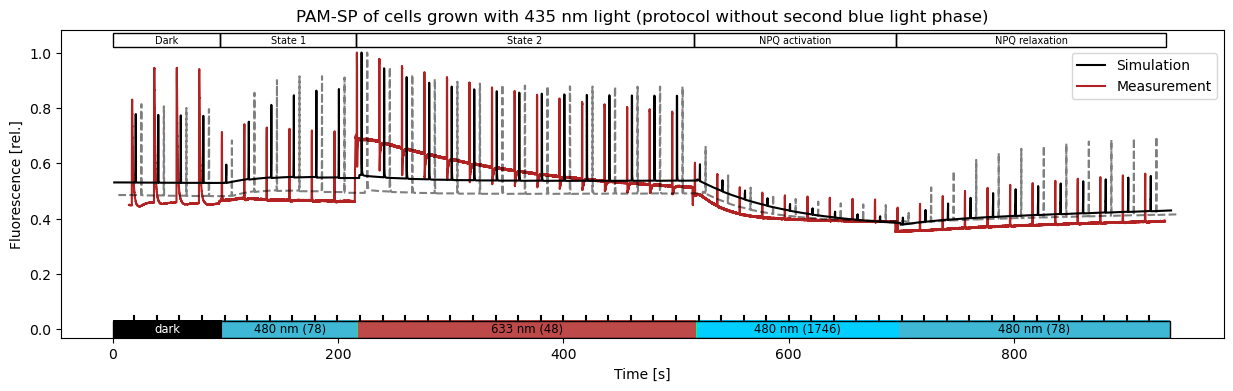

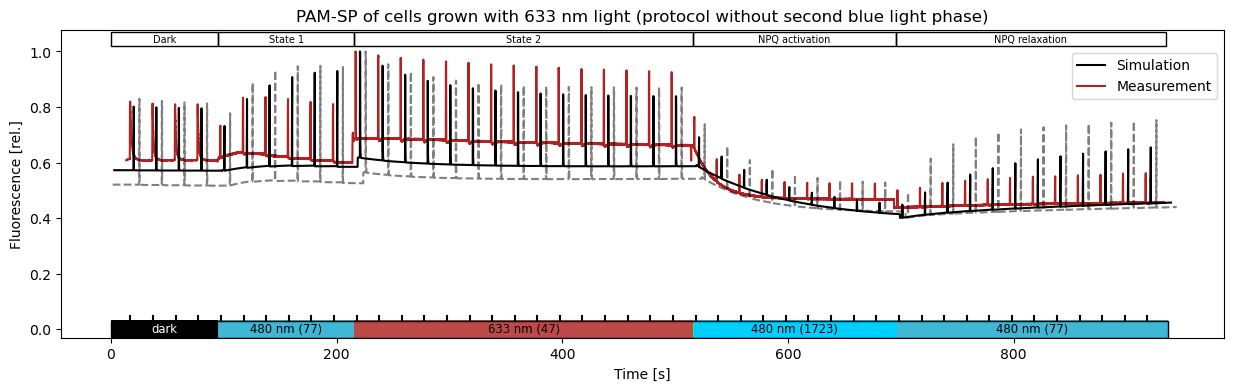

In [128]:
if settings["PAM_blue_light"]["plot"]:
    combined_plots = {
        "state_1":['PSII kinetics, NPQ at state 1_435', 'PSII kinetics, NPQ at state 1_633'],
        "state_2":['PSII kinetics, NPQ at state 2_435', 'PSII kinetics, NPQ at state 2_633'],
        }
    data_offsets = { # Determine the first peak and set it to time 18
        x:pamdata[x].index[pamdata[x].loc[:20,"F"].argmax()] - 17 for x in pamdata 
    }

    for key_comp, meas_comb in combined_plots.items():
        if key_comp == "state_1":
            fig_comb = paper_figs["figS15"]["subs"]["A"]
            axes_comb = fig_comb.subplots(2,1, sharex=True)
        else:
            fig_comb, axes_comb = plt.subplots(2,1, figsize=(10,12), sharex=True)
        # fig_det, axes_det = plt.subplots(2,1, figsize=(20,12), sharex=True)
        for meas_select in meas_comb:
            if meas_select in sims.keys():
                s4 = sims[meas_select]
                s4_def = sims_def[meas_select]

                fig, _ax = plt.subplots(figsize=(10, 5))
                axes = [_ax, axes_comb[meas_comb.index(meas_select)]]

                for i,ax in enumerate(axes):
                    fig, ax = plot_model_and_data(s4, pamdata[meas_select].iloc[:,:2], pulse_pfdm4 * 0.95, ax=ax, annotation_twoline=False, data_offset=data_offsets[meas_select])

                    # Get the fluorescence with default parameters
                    _s4_def = fnc.remove_beginning_from_simulation(s4_def, 295)
                    default_fluo = _s4_def.get_full_results_df().loc[:,"Fluo"]
                    ax.plot(default_fluo/default_fluo.max(), ls="--", alpha=0.5, c="k")

                    # Set the title
                    title_suffix = ""

                    if meas_select == 'PSII kinetics, NPQ at state 1_435':
                        title_suffix += "(fitted)"

                    if meas_select.split("_")[0] == 'PSII kinetics, NPQ at state 2':
                        title_suffix += "(protocol without second blue light phase)" #", Light Protocol "
                        ax = add_phaseboxes_noNPQ(ax)
                    else:
                        ax = add_phaseboxes_NPQ(ax)

                    ax.set_title(f"PAM-SP of cells grown with {meas_select.split('_')[1]} nm light {title_suffix}")

                    if i == 0:
                        fig.set_size_inches(15,4)
                        fnc.savefig_dated(fig, f"pamspplot_{meas_select[15:]}", type=plot_format, path=figure_path, bbox_inches="tight")

                # # Plot the redox state and CBB redox activation
                # ax = axes_det[meas_comb.index(meas_select)]
                # _s4 = fnc.remove_beginning_from_simulation(s4, 300)
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["Q_red"]/_s4.model.parameters["Q_tot"], label="Reduced PQ fraction")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["PSIIq"]/_s4.model.parameters["PSIItot"], label="State transition activity")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["CBBa"], label="CBB redox activation")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["OCP"], label="OCP activity")

                # ax = fnc.add_lightbar(_s4, ax, 1800, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)

                # ax.legend()

                # ax.set_title(f"Detailed analysis of PAM-SP of cells grown with {meas_select.split('_')[1]} nm light {title_suffix}")
                # fig_det.tight_layout()


            axes_comb[0].set_xlabel(None)
            # fig_comb.tight_layout()
            # fig.set_size_inches(15,7)


            # fnc.savefig_dated(fig_comb, f"pamspplot_combined_{key_comp}", type=plot_format, path=figure_path, bbox_inches="tight")


## Simulate all wavelengths (Figure 2b)

In [129]:
def simulate_adapted_strain_pam(growthlight, strain_params, fit_param, absorption_coef, pulse_pfd, meas_select):
    print(f"{growthlight}: started")
    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model_new_parameters(check_consistency=False, reduced_size=False, verbose=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Temporarily adapt parameters
    m4.update_parameters(fit_param)

    # Simulate the appropriate protocol
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfd, blue_wl=480)
    )
    if meas_select.startswith("PSI+PSII kinetics"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
    print(f"{growthlight}: finished")

    return fnc._convert_Simulator_for_save(s4, save_full_results=True)

In [130]:
if settings["PAM_all_lights"]["recalculate"]:
    # Simulate PAM traces for all adapted strains with the above fit parameters
    wavelengths = [x for x in strain_params.keys() if x != "596"]

    _simulate_adapted_strain_pam = partial(
        simulate_adapted_strain_pam,
        strain_params=strain_params,
        fit_param={},
        absorption_coef=absorption_coef,
        pulse_pfd=pulse_pfdm4,
        meas_select=meas_select
    )
    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
            res = list(map(_simulate_adapted_strain_pam, wavelengths))
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            res = list(pe.map(_simulate_adapted_strain_pam, wavelengths))
    sims = {k:fnc._create_Simulator_for_load(v) for k,v in zip(wavelengths, res)}
    fnc.save_Simulator_dated(sims, "adapted_strain_pam", results_path, save_full_results=True)

435: started465: started495: started520: started633: started663: started555: started




687: started


555: finished
520: finished
495: finished
465: finished
633: finished
663: finished
435: finished
687: finished


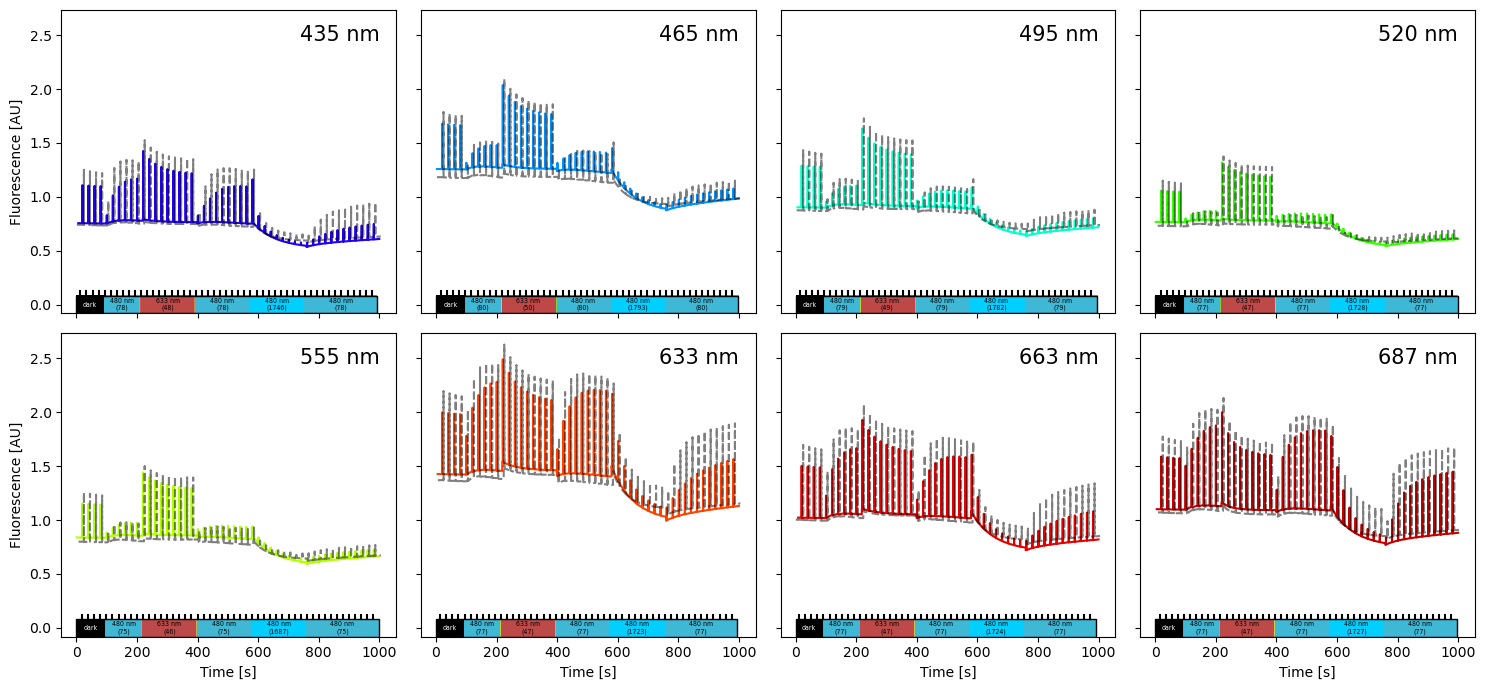

In [131]:
if settings["PAM_all_lights"]["plot"]:
    # Plot the PAM simulations
    sims = fnc.load_Simulator_dated("adapted_strain_pam", results_path)
    sims_def = fnc.load_Simulator_dated("adapted_strain_pam", default_results_path)

    fig, axes = plt.subplots(2,4, figsize = (15,7), sharey=True, sharex=True)

    sims = {k:fnc.remove_beginning_from_simulation(s, 300) for k,s in sims.items()}
    sims_def = {k:fnc.remove_beginning_from_simulation(s, 295) for k,s in sims_def.items()}

    for ax, (i,s), s_def in zip(axes.flatten(), sims.items(), sims_def.values()):
        try:
            ax.plot(s.get_full_results_df().loc[:,"Fluo"], c=fnc.wavelength_to_rgb(int(i)))
            ax.plot(s_def.get_full_results_df().loc[:,"Fluo"], ls="--", alpha=0.5, c="k")
        except:
            pass
        ax.text(0.95, 0.95, f"{i} nm", size=15, ha="right", va="top", transform=ax.transAxes)
    ax.set_ylim(ymin=0)
        
    for ax, (i,s) in zip(axes.flatten(), sims.items()):
        ax = fnc.add_lightbar(s, ax, 2000, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, y_pos=0, annotation=True, annotation_twoline=True, annotation_size=4.5)

    for j in range(4):
        axes[-1,j].set_xlabel("Time [s]")
    for j in range(2):
        axes[j,0].set_ylabel("Fluorescence [AU]")

    fig.tight_layout()
    fnc.savefig_dated(fig, "adapted_strain_pam", type=plot_format, path=figure_path)

## Validation PAM experiment

In [132]:
df = pd.read_csv(Path("../Code/data/PAM_validation_Zavrel2024.csv"), index_col=[0], header=[0,1,2])
idx = pd.IndexSlice

In [133]:
# Protocol of the validation experiment
dark, low_blue, high_blue, orange, pulse_orange, pulse_blue = make_lights(
    blueInt=80,
    orangeInt=50,
    highblueInt=1800,
    pulseInt=15000,
    orange_wl=625,
    blue_wl=440,
)
pulse_white = lip.light_spectra("cool_white_led", 15000)


# Dark acclimation
protocol = fnc.create_protocol_const(
    light=dark,
    time=300
)

# Dark phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=4,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Orange phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(orange, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=25,
    final_actinic_time=5,
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# High blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(high_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Simulate the validation experiment
m,y0 = get_model_new_parameters()
s = Simulator(m)
s.initialise(y0)

# The culture is grown under 1% CO2
s.update_parameter("CO2ext_pp", 0.01)

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)


# Simulate the validation experiment
m_def,y0 = get_model()
s_def = Simulator(m_def)
s_def.initialise(y0)

# The culture is grown under 1% CO2
s_def.update_parameter("CO2ext_pp", 0.01)

s_def = fnc.simulate_protocol(s_def, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False
updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


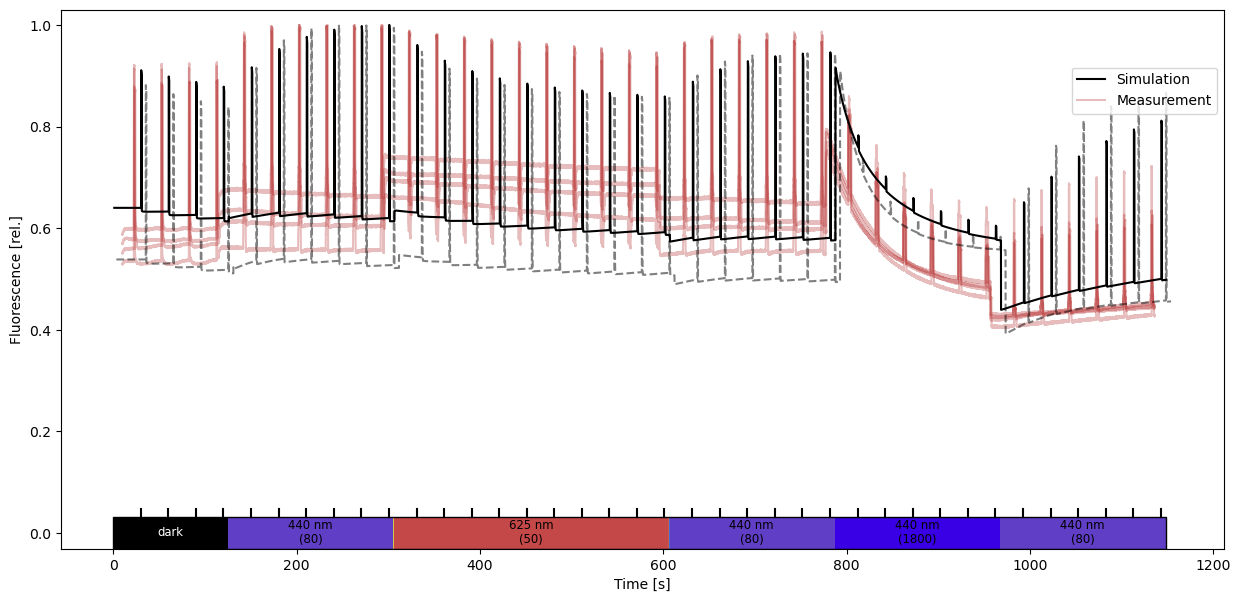

In [134]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)
_s_def = fnc.remove_beginning_from_simulation(s_def, 294)

fig,ax= plt.subplots(figsize=(15,7))
dat = df.loc[:1126,idx["25", "white",:]]
dat_line = ax.plot(dat.index.to_numpy() + 10, dat.values, c="firebrick", label="Measurement", alpha=0.3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Fluorescence [rel.]")
ax.set_ylim(ymin=0)

# Plot the simulation on top
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = ax.plot(_s.get_time(), fluo_norm, c="black", label="Simulation")

fluo_def = _s_def.get_full_results_dict()["Fluo"]
fluo_norm_def = fluo_def / fluo_def.max()
ax.plot(_s_def.get_time(), fluo_norm_def, ls="--", alpha=0.5, c="k")

handles = sim_line + [dat_line[0]]

ax.legend(
    handles = handles,
    loc="center right",
    bbox_to_anchor = (1,0.85)
)

ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.set_title("")
fnc.savefig_dated(fig, f"pamspplot_validation_singleplot", type=plot_format, path=figure_path, bbox_inches="tight")

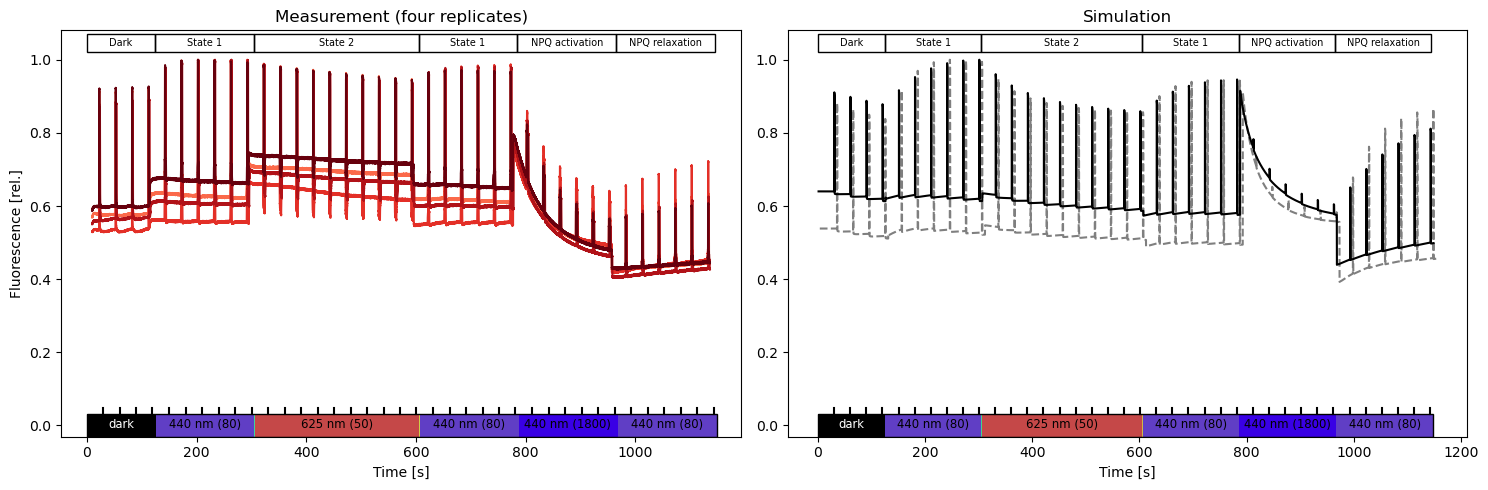

In [135]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)
_s_def = fnc.remove_beginning_from_simulation(s_def, 294)

fig,axes= plt.subplots(1,2, figsize=(15,5))
dat = df.loc[:1126,idx["25", "white",:]]

colors = mpl.colormaps["Reds"](np.linspace(0.5,1,len(dat.columns)))
for i in range(len(dat.columns)):   
    dat_line = axes[0].plot(dat.index.to_numpy() + 10, dat.iloc[:,i], c=colors[i], label="Measurement")
axes[0].set_ylabel("Fluorescence [rel.]")
axes[0].set_title("Measurement (four replicates)")


# Plot the simulation on the side
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = axes[1].plot(_s.get_time(), fluo_norm, c="black", label="Simulation")
axes[1].set_title("Simulation")

fluo_def = _s_def.get_full_results_dict()["Fluo"]
fluo_norm_def = fluo_def / fluo_def.max()
axes[1].plot(_s_def.get_time(), fluo_norm_def, ls="--", alpha=0.5, c="k")

for ax in axes:
    ax.set_xlabel("Time [s]")
    ax.set_ylim(ymin=0)
    ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)
    
    
    # Add phaseboxes
    ax = add_phasebox(ax, 0, 125, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 125, 305, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 305, 605, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 605, 785, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 785, 965, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 965, 1145, "NPQ relaxation", 0.05, 1.02)

# Share the y axis
axes[0].sharey(axes[1])
# axes[1].set_yticklabels([])

fig.tight_layout()
fnc.savefig_dated(fig, f"pamspplot_validation_dualplot", type=plot_format, path=figure_path, bbox_inches="tight")

In [136]:
# Simulate all
def get_pathways_at_lights(model, y0, lights, intens):
    sims = []
    for i, light in zip(intens, lights):
        m = model.copy()
        m.update_parameter("pfd", light)

        # Prepare for ss simulation
        exch_dict = {
            "3PGA": {"k": 10, "thresh": 1000},
            # "PG": {"k": 10, "thresh": 1},
        }
        m =fnc.add_exchange(m, exch_dict)

        s = Simulator(m)
        s.initialise(y0)
        # t,y = s.simulate(10000)
        # t,y = s.simulate_to_steady_state(tolerance=1e-2)
        s,t,y = simulate_to_steady_state_custom(s,        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])

        if t is None:
            raise RuntimeError(f"simulation failed for i={i:.2f}")
        else:
            sims.append(s)

    # Get the electron pathways
    pathways = pd.DataFrame({i:pd.DataFrame(fnc.get_ss_electron_pathways(s)).iloc[-1,:] for s,i in zip(sims, intens)}).T
    return pathways, sims

def get_model_simulator(model, y0, light):
    m = model.copy()
    m.update_parameter("pfd", light)

    # Prepare for ss simulation
    exch_dict = {
        "3PGA": {"k": 10, "thresh": 1000},
    }
    m =fnc.add_exchange(m, exch_dict)

    s = Simulator(m)
    s.initialise(y0)
    return s

# Electron Pathway and Validation Experiments (Figure 1, 6, & 8)

## Evaluate the electron pathways at different light intensities (Figure 1 & 8)

In [137]:
normToPS1 = True

intens = np.linspace(0.1, 320, int(100 * fraction_simulated_points))
light_source = "Theune2021"
if light_source == "Theune2021":
    lights = [lip.light_gaussianLED(670, i) for i in intens]
else:
    lights = [lip.light_spectra(light_source, i) for i in intens]

# Simulate Wild Type and different mutants
# Standard model
m0, y0 = get_model_new_parameters(check_consistency=False, verbose=False)

# low CO2
mCO2, y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mCO2.update_parameter("CO2ext_pp", 0.0004)

# Flv KO mutant
mFlv, y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mFlv.update_parameter("k_O2", 0)

# Flv KO mutant
mNQ, y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mNQ.update_parameter("k_NQ" if "k_NQ" in mNQ.parameters else "vNQ_max", 0)

models = {"m0":m0, "mCO2":mCO2, "mFlv":mFlv, "mNQ":mNQ}
pathways = {}
sims = {}

if settings["electron_pathways"]["recalculate"]:
    print("\nSIMULATING")
    for key,model in models.items():
        print(key)
        _pathways, _sims = get_pathways_at_lights(model, y0, lights, intens)
        pathways[key] = _pathways
        sims[key] = _sims

        fnc.save_Simulator_dated(_sims, f"epaths_sims_{key}", results_path)
    fnc.save_obj_dated(pathways, "epaths_paths", results_path)


SIMULATING
m0
mCO2
mFlv
mNQ


In [138]:
# Make the models with default parameters
# Simulate Wild Type and different mutants
# Standard model
m0_def, y0 = get_model(check_consistency=False, verbose=False)

# low CO2
mCO2_def, y0 = get_model(check_consistency=False, verbose=False)
mCO2_def.update_parameter("CO2ext_pp", 0.0004)

# Flv KO mutant
mFlv_def, y0 = get_model(check_consistency=False, verbose=False)
mFlv_def.update_parameter("k_O2", 0)

# Flv KO mutant
mNQ_def, y0 = get_model(check_consistency=False, verbose=False)
mNQ_def.update_parameter("k_NQ" if "k_NQ" in mNQ.parameters else "vNQ_max", 0)

models_def = {"m0":m0_def, "mCO2":mCO2_def, "mFlv":mFlv_def, "mNQ":mNQ_def}

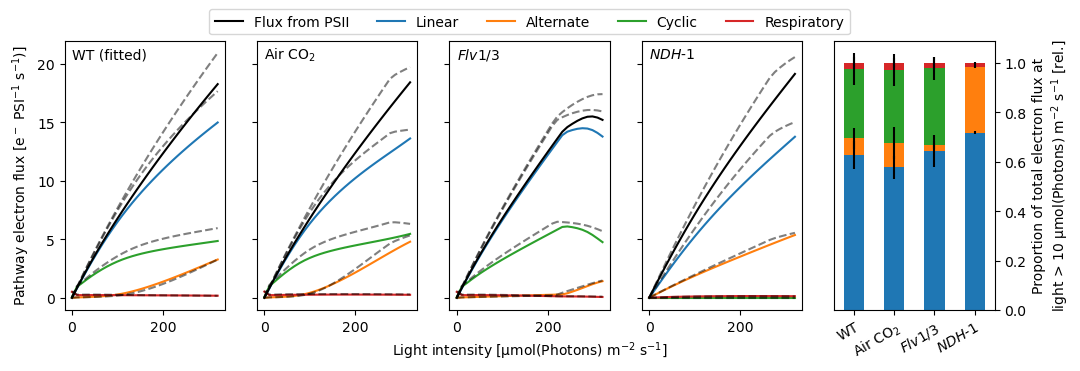

In [139]:
if settings["electron_pathways"]["plot"]:
    sims = {key:fnc.load_Simulator_dated(f"epaths_sims_{key}", results_path) for key in models}
    pathways = fnc.load_obj_dated("epaths_paths", results_path)

    sims_def = {key:fnc.load_Simulator_dated(f"epaths_sims_{key}", default_results_path) for key in models}
    pathways_def = fnc.load_obj_dated("epaths_paths", default_results_path)

    # Plot all
    titles = {
        "m0":"WT",
        "mFlv":"$\it{Flv1/3}$",
        "mNQ": "$\it{NDH}$-$\it{1}$",
        "mCO2": "Air CO$_2$"
    }
    
    # Set up a figure with all axes shared but the last one
    fig = plt.figure()
    axes = np.full(len(titles)+1,0, dtype=object)
    axes[0] = fig.add_subplot(1,len(titles)+1,1)
    for i in range(2,len(titles)+2):
        axes[i-1] = fig.add_subplot(1,len(titles)+1,i, sharey=(axes[0] if i!=5 else None))

    fig.set_size_inches(12,3.5)

    # Line Plot
    for (key, ptw), ptw_def, ax in zip(pathways.items(), pathways_def.values(), axes):
        norm = m0.get_parameter("PSItot") *3 if normToPS1 else 1 # Normalise to PS1 monomers
        ptw_norm = ptw / norm
        vps2 = pd.Series([s.get_fluxes_df().loc[:,"vPS2"].iloc[-1] for s in sims[key]], index=intens) * 2 / norm

        lin = ax.plot(ptw_norm)
        lin2 = ax.plot(vps2, c="k", label = "PS2 flux")

        # Add line with default parameters
        ptw_norm_def = ptw_def / norm
        vps2_def = pd.Series([s.get_fluxes_df().loc[:,"vPS2"].iloc[-1] for s in sims_def[key]], index=intens) * 2 / norm
        ax.plot(ptw_norm_def, ls="--", alpha=0.5, c="k")
        ax.plot(vps2_def, ls="--", alpha=0.5, c="k")

    for (key, ptw), ax in zip(pathways.items(), axes):
        ax.text(0, ax.get_ylim()[1]*0.93, titles[key] + (" (fitted)" if key == "m0" else ""))

    if normToPS1:
        axes[0].set_ylabel("Pathway electron flux [e$^-$ PSI$^{-1}$ s$^{-1}$)]")
    else:
        axes[0].set_ylabel("Pathway electron flux [mmol(e$^-$) mol(Chl)$^{-1}$ s$^{-1}$)]")

    axes[2].set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    axes[2].legend(
            handles=lin2 + lin,
            labels=["Flux from PSII", "Linear", "Alternate", "Cyclic", "Respiratory"], 
            loc="center",
            bbox_to_anchor= (0.5, 1.07),
            borderaxespad= 0,
            ncol=5
            )
    
    # Calculate mean pathway usage
    pathway_mean = {}
    pathway_sd = {}

    for mdl in pathways.keys():
        pathway_mean[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.mean(axis=0)
        pathway_sd[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.std(axis=0)

    pathway_mean = pd.DataFrame(pathway_mean)
    pathway_sd = pd.DataFrame(pathway_sd)

    # Create a container for the y errors
    yerr = [[row, row] for i,row in pathway_sd.iterrows()]

    pathway_mean.T.plot.bar(stacked=True, yerr=yerr, ax=axes[-1])
    
    # Remove the legend
    axes[-1].get_legend().remove()

    # Set the y axis to the right
    axes[-1].yaxis.set_label_position("right")
    axes[-1].yaxis.tick_right()
    axes[-1].set_ylabel("Proportion of total electron flux at\nlight > 10 µmol(Photons) m$^{-2}$ s$^{-1}$ [rel.]")

    axes[-1].set_xticklabels([titles[x] for x in pathway_mean.columns], rotation=30, ha="right", rotation_mode='anchor')

    fig.tight_layout()
    fnc.savefig_dated(fig, f"electronpaths-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

    
    # for mdl in pathways.keys():
    #     # Relative pathway fractions
    #     fig, ax = plt.subplots()

    #     (pathways[mdl].T / pathways[mdl].sum(axis=1)).T.plot(ax=ax)
    #     ax.set_ylabel("Proportion of total electron flux [rel.]")
    #     ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    #     ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

    #     fnc.savefig_dated(fig, f"electronpaths-{light_source}{mdl}_rel", type=plot_format, path=figure_path, bbox_inches="tight")

    # # Relative pathway fractions (single plot)
    # fig, ax = plt.subplots(figsize=(5,5))
    # pathway_mean.T.plot.bar(stacked=False, yerr=yerr, ax=ax)
    # ax.set_ylabel("Proportion of total electron flux [rel.]")

    # fig.suptitle("Relative electron pathway amounts (I>10 µmol(Photons) m$^{-2}$ s$^{-1}$)")

    # fnc.savefig_dated(fig, f"electronpaths-{light_source}_relbar", type=plot_format, path=figure_path, bbox_inches="tight")


    # # Detailed analysis
    # allpHs = {}
    # allcomps = {}
    # allvs = {}
    # # allKeqs = {}

    # for mdl in sims:
    #     idx = intens
    #     pHs = pd.DataFrame(columns =["pHlumen", "pHcytoplasm"])
    #     comps = pd.DataFrame(columns =["ATP", "NADPH", "Q_red", "Fd_red"])
    #     vs =  pd.DataFrame(columns =["vATPsynthase", "vNQ", "vCBB"])

    #     for i,s in enumerate(sims[mdl]):
    #         pHs.loc[idx[i],:] = s.get_full_results_df()[pHs.columns].iloc[-1]
    #         comps.loc[idx[i],:] = s.get_full_results_df()[comps.columns].iloc[-1] / np.array([s.model.get_parameter(x) for x in ["AP_tot", "NADP_tot", "Q_tot","Fd_tot"]])
    #         vs.loc[idx[i],:] = s.get_fluxes_df()[vs.columns].iloc[-1]    

    #     allpHs[mdl] = pHs
    #     allcomps[mdl] = comps
    #     allvs[mdl] = vs
    
    # # Plot of in depth analysis
    # fig, axes = plt.subplots(3,4, sharey="row", sharex=True, figsize=(10,7))
    # for (k,v), ax in zip(allcomps.items(), axes[0,:]):
    #     lin0 = ax.plot(v, label=list(["ATP", "NADPH", "PQ$_{red}$", "Fd$_{red}$"]))
    #     ax.set_title(titles[k])
    #     ax.set_ylim(0,1.05)
    # for (k,v), ax in zip(allpHs.items(), axes[1,:]):
    #     lin1 = ax.plot(v, label=list(["Lumen","Cytoplasm"]))
    # for i, ((k,v), ax) in enumerate(zip(allvs.items(), axes[2,:])):
    #     lin21 = ax.plot(v.iloc[:,:-1], label=["ATP synthase", "NDH-1"])
    #     ax2 = ax.twinx()
    #     lin22= ax2.plot(v["vCBB"], label="CBB", c=mpl.colormaps["tab10"](2))
    #     if i>0:
    #         ax2.sharey(_ax2)
    #     if i<2:
    #         ax2.tick_params(labelright=False)
    #     _ax2 = ax2
        

    # axes[0,0].set_ylabel("Fraction of total pool")
    # axes[1,0].set_ylabel("pH")
    # axes[2,0].set_ylabel("Flux [mmol mol(Chl)$^{-1}$ s$^{-1}$]")
    # fig.text(0.4,0,"Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center",va="center")
    # ax2.set_ylabel("CBB Flux[mmol mol(Chl)$^{-1}$ s$^{-1}$]")

    # for i, lin in zip(range(axes.shape[0]), [lin0, lin1, lin21+lin22]):
    #     y = 1.04 if i < 2 else 1.33 # 1.1
    #     axes[i,-1].legend(handles=lin,bbox_to_anchor=(y,1), loc="upper left")

    # fig.tight_layout()
    # fnc.savefig_dated(fig, f"electronpaths_analysis-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

## Calculate the cell's NPQ, simulating fluorescence

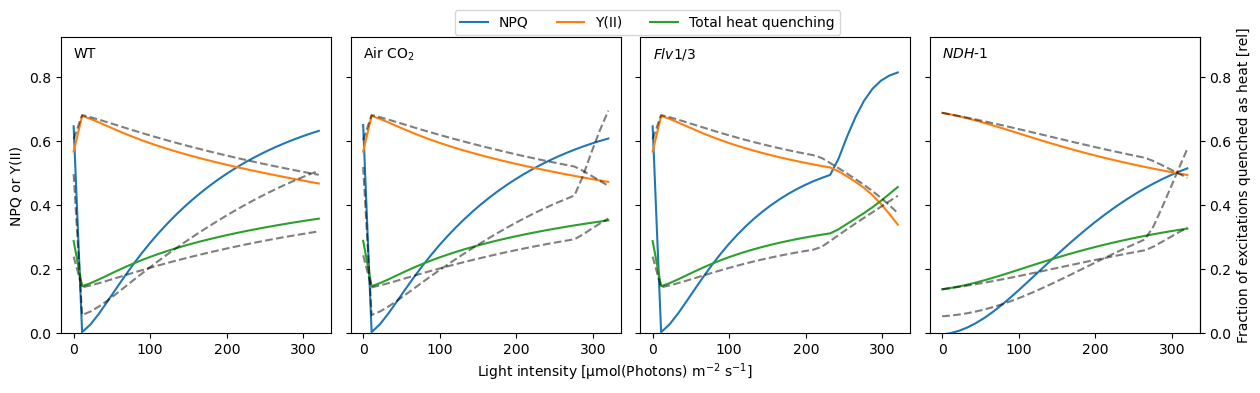

In [140]:
fig, axes = plt.subplots(1,4, figsize=(12,3.5), sharey=True)

plot_kwargs = [{}, {"ls":"--", "alpha":0.5, "c":"k"}]

for j, (_sims, _models) in enumerate(zip([sims, sims_def], [models, models_def])):
    for mdl, ax in zip(_sims.keys(), axes.flatten()):
        OCPs = np.zeros(len(_sims[mdl]))
        NPQs = np.zeros(len(_sims[mdl]))
        YIIs = np.zeros(len(_sims[mdl]))
        Heat = np.zeros(len(_sims[mdl]))

        # Get Fm as the SP after a FR light phase
        _s = Simulator(_models[mdl])
        _s.initialise(y0)
        _s.update_parameter("pfd", lip.light_gaussianLED(700, 50))
        _s.simulate(300)
        _s.update_parameter("pfd", lip.light_gaussianLED(633, 15000))
        _s.simulate(300+0.6)
        Fm = _s.get_full_results_df().loc[300:,"FPS2"].max()

        for i,s in enumerate(_sims[mdl]):
            # Get the necessary dynamic variables and parameters
            OCP, B0, B1, B2, B3, PSIIq, Ft  = list(s.get_full_results_df().loc[:,["OCP", "B0", "B1", "B2", "B3", "PSIIq", "FPS2"]].to_numpy().flatten())
            kH0, kHst, kF, k2, PSIItot = [s.model.get_parameter(x) for x in ["kH0", "kHst", "kF", "k2", "PSIItot"]]

            kH = kH0 + kHst * (PSIIq / PSIItot)

            # Simulate the fluorescence with a SP
            _s = s.copy()
            _s.update_parameter("pfd", lip.light_gaussianLED(633, 15000))

            t_end = s.get_time()[-1]
            _s.simulate(t_end+0.6)
            Fmp = _s.get_full_results_df().loc[t_end:,"FPS2"].max()

            # Fluorescence-like NPQ (Fm - Fm') / Fm'
            NPQs[i] = (Fm - Fmp) / Fmp

            # Fluorescence-like Y(II) (Fm' - Ft) / Fm'
            YIIs[i] = (Fmp - Ft) / Fmp

            # Heat quenching
            Heat[i] = (kH) / (kH + kF + k2) * (B1 / (B1 + B3)) + (kH) / (kH + kF) * (B3 / (B1 + B3))

        ax.plot(intens, NPQs, label="NPQ" if j==0 else None, **plot_kwargs[j])
        ax.plot(intens, YIIs, label="Y(II)" if j==0 else None, **plot_kwargs[j])
        ax.plot(intens, Heat, label="Total heat quenching" if j==0 else None, **plot_kwargs[j])
        # ax.plot(intens, OCPs, label="OCP")

ax.set_ylim(0, ax.get_ylim()[1]*1.05)

fig.tight_layout()

ax2 = ax.secondary_yaxis(location="right")
ax2.set_ylabel("Fraction of excitations quenched as heat [rel]")
axes[0].set_ylabel("NPQ or Y(II)")
axes[1].legend( 
        loc="center",
        bbox_to_anchor= (1.1, 1.05),
        borderaxespad= 0,
        ncol=5
        )

fig.text(x=0.5, y=0, s="Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center", va="center")

for mdl, ax in zip(_sims.keys(), axes.flatten()):
    ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

fnc.savefig_dated(fig, f"electronpaths_processes-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")


## Compare Oxygen and CO2 fluxes (Figure 6)

In [141]:
def get_O2andCO2rates(s):
    #  Get O2 and CO2 rates
    rates = {}
    res = {}

    rates["O2"] = fnc.get_stoichiometric_fluxes(s, "O2")
    rates["O2"].pop("vO2out")

    rates["CO2"] = fnc.get_stoichiometric_fluxes(s, "CO2")
    rates["CO2"].pop("vCCM")

    for cmp in ["O2", "CO2"]:
        prod = pd.DataFrame(rates[cmp].copy())
        prod[prod<0] = 0
        res[f"{cmp}_production"] = prod.sum(axis=1, skipna=False)

        cons = pd.DataFrame(rates[cmp].copy())
        cons[prod>0] = 0
        res[f"{cmp}_consumption"] = cons.sum(axis=1, skipna=False)

        res[f"{cmp}_net"] = pd.DataFrame(rates[cmp]).sum(axis=1, skipna=False)
    
    return pd.DataFrame(res)

In [142]:
# Oxygen change rates from Schuurmans2014
O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

In [143]:
# Reference values for plot
# Oxygen change rates from Schuurmans2014
O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

# Define the lights
intens = np.unique(np.sort(np.concatenate((np.linspace(0, 320, 30), O2_ref.index.to_numpy()))))
lights = [lip.light_gaussianLED(625, i) for i in intens]

# Standard model
m0,y0 = get_model_new_parameters(check_consistency=False, verbose=False)

# Standard model
mlowCO2,y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mlowCO2.update_parameter("CO2ext_pp", 0.0004)

# Adjust the lights to in-culture conditions (2 mg(Chl) l^-1 according to Schuurmans)
MChl = 893.509 # [g mol^-1]
absorption_coef = lip.get_pigment_absorption(m0.parameters["pigment_content"]).sum(axis=1) * MChl
lights = lip.get_mean_sample_light(
    lights, # [µmol(Photons) m^-2 s^-1]
    depth = 0.01,  # [m]
    absorption_coef=absorption_coef,
    chlorophyll_sample=(
        2 # [mg(Chl) l^-1] (Schuurmans2014)
        / MChl # [mol g^-1]
        * 1e3
    ) # [mmol(Chl) m^-3]
)

models = {"m0":m0, "mlowCO2":mlowCO2}
pathways = {}
sims = {}
gasrates = {}

if settings["O2_CO2_fluxes"]["recalculate"]:
    for key,model in models.items():
        print(key)
        _pathways, _sims = get_pathways_at_lights(model, y0, lights, intens)
        pathways[key] = _pathways
        sims[key] = _sims

        # Get the O2 and CO2 rates for Wild Type
        gasrates[key] = pd.concat([get_O2andCO2rates(s).iloc[-1,:] for s in _sims], axis=1)
        gasrates[key].columns = [f"{i:.2f}" for i in intens]
    fnc.save_obj_dated(gasrates, "gasrates_validation", results_path)

m0
mlowCO2


In [144]:
if settings["O2_CO2_fluxes"]["plot"]:
        
    gasrates = fnc.load_obj_dated("gasrates_validation", results_path)
    gasrates_def = fnc.load_obj_dated("gasrates_validation", default_results_path)

    # Reference values for plot
    # Oxygen change rates from Schuurmans2014
    O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

    # Carbon fixation rate from Zavrel2017
    CBB_rate = (
        -0.2 # [fg(CO2) cell^-1 s^-1]
        / 60 # [fg(Chla) cell^-1]
        / prm.M_CO2 # [g(CO2) mol^-1]
        * prm.M_chl # [g(Chl) mol^-1]
        * 1e3
        * 1e15
    )
    CBB_ref = (220, CBB_rate * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1")) # [g(CO2) cell^-1 s^-1] approximate maximal CO2 uptake rate (Zavrel2017; Fig. S-D)

    fig = paper_figs["figS15"]["subs"]["B"]
    axes = fig.subplots(2,1, sharex=True)



    # Oxygen plot
    for mdl in ["m0"]:
        ax = axes[0]
        lins1 = ax.plot(intens, gasrates[mdl].loc[["O2_consumption","O2_production"]].T * prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), label = ["O$_2$ consumption","O$_2$ production"]) 
        
        # Add the lines with default parameters
        ax.plot(intens, gasrates_def[mdl].loc[["O2_consumption","O2_production"]].T * prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), ls="--", alpha=0.5, c="k") 
        # ax.secondary_yaxis(functions=(
        #     lambda x: x/prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), 
        #     lambda x: x*prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), 
        #     ), location="right")
        ax.axhline(0,c="k")
        lins2 = ax.plot(O2_ref.loc[:,[" prod_625_highCO2", " cons_625_highCO2"]], "o", c="grey", label="Schuurmans (2014)")
        # lins3 = ax.plot(O2_ref.loc[:,[" prod_625_lowCO2", " cons_625_lowCO2"]], "o", c="grey", label="Schuurmans (2014) Low CO2")

        ax.set_ylabel("O$_2$ rate\n[µmol(O$_2$) mg(Chla)$^{-1}$ min$^{-1}$]")

        to_legend = lins1 + [lins2[0]]
        ax.legend(to_legend, [x.get_label() for x in to_legend])

        ax = axes[1]
        ax.plot(intens, gasrates[mdl].loc[["CO2_consumption","CO2_production"]].T * 1e15 * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1"), label = ["CO$_2$ consumption","CO$_2$ production"]) 
        
        # Add the lines with default parameters
        ax.plot(intens, gasrates_def[mdl].loc[["CO2_consumption","CO2_production"]].T * 1e15 * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1"), ls="--", alpha=0.5, c="k") 
        # ax.secondary_yaxis(functions=(
        #     lambda x: x/1e15/prm.unit_conv(["mmol mol(Chl)-1 -> g(CO2) cell-1"]), 
        #     lambda x: x*1e15*prm.unit_conv(["mmol mol(Chl)-1 -> g(CO2) cell-1"]), 
        #     ), location="right")
        ax.axhline(0,c="k")
    ax.scatter(*CBB_ref,c="grey", label="Zavrel (2017, fitted)")
    ax.set_ylabel("CO$_2$ rate\n[fg(CO$_2$) cell$^{-1}$ s$^{-1}$]")
    ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.legend()

    # Calculate the residuals

## Final layouting

In [145]:
# Adjust subfigure spacing
paper_figs["fig1"]["subs"]["B"].subplots_adjust(wspace=0.1, left=0.05, right=0.9)

In [146]:
# Add model scheme to Fig. 1
fig = paper_figs["fig1"]["subs"]["A"]
fig.set_dpi(300)

ax = fig.subplots()
ax.axis('off')

with Image.open('../Figures/Model_scheme_v13_lesscolor.png') as img:
    ax.imshow(img)

In [147]:
# Add ST model schemes to Fig. 3
fig = paper_figs["fig4"]["subs"]["A"]
fig.set_dpi(300)

ax = fig.subplots()
ax.axis('off')

with Image.open('../Figures/state_transition_schemes_v2.png') as img:
    ax.imshow(img)

In [148]:
# Add Photosystem schemes to Fig. S1
for fig, ps in zip(paper_figs["figS1"]["subs"].values(), ["PSII", "PSI"]):
    fig.set_dpi(300)

    ax = fig.subplots()
    ax.axis('off')

    with Image.open(f'../Figures/{ps}_scheme.png') as img:
        ax.imshow(img)

## Save all plots

In [149]:
for fig_nam in paper_figs:
    fnc.savefig_dated(paper_figs[fig_nam]["main"], fig_nam, type=plot_format, path=figure_path, bbox_inches="tight", format='%Y%m%d')